# CRAB

## Name
Cosmic Rays Artificial Background (CRAB)

## Description
This project contains machine learning methods to the study of CR noise systematics in the High Frequencies Telescope (HFT) of the LiteBIRD experiment. For the data post analysis and even to identify how to reduce the noise generated by Coscmic Rays (CR), it is necessary to simulate the response in signal, generated by them in the detector, with a sample of Time Ordered Data (TOD) representative of LiteBIRD's 3-year mission. Currently, this is accomplished with a chain of Monte Carlo (MC) simulations that requires ~30 times that of the desired TOD. The aim of the code is to generate synthetic Time Ordered Data (TOD) for data augmentation, starting from Monte Carlo simulated TOD samples. The algorithm used is a Generative Adversarial Network (GAN), which has a convulutionary discriminator and a de-convolutionary generator. The code is developed in python using TensorFlow libraries to build the Neural Networks (NN).

In [1]:
# Reset the kernel to arise the garbage traning of the NN left behind
%reset -f
import gc
gc.collect()

0

## Imports

In [2]:
# math and numpy
from math import *
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Python generic
import time
import random
import datetime

# TensorFlow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv1DTranspose, SeparableConv1D, Flatten, Reshape
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, Dropout, LeakyReLU, Lambda
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow import GradientTape
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import Mean, BinaryAccuracy
from tensorflow.math import reduce_mean
from tensorflow import clip_by_value
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)

# Image menagement
from PIL import Image

# Hyperparameters grid search
from tensorboard.plugins.hparams import api as hp

2024-08-26 14:33:07.628056: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 14:33:07.679228: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 14:33:07.723096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 14:33:07.760462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 14:33:07.772919: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 14:33:07.844092: I tensorflow/core/platform/cpu_feature_gu

TensorFlow version: 2.17.0


## TensorFlow environment initialization
- Grepping the available GPUs to execute the computing part of the NN training
- Setting fixed seeds for random generators. Because of different random generators for each library one needs to fix the seed for: python basic, numpy, tensorflow, tensorflow experimental library and tensorflow keras library random generators

In [3]:
# Check available GPUs
GPU_num = len(tf.config.list_physical_devices('GPU'))
print('Num GPUs Available: ', GPU_num)

# Clean previous models
clear_session()

# Random seeds initialization
seed = 42

# From https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    if GPU_num != 0:
        # When running on the CuDNN backend, two further options must be set
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
    print(f"Random seed set as {seed}")
    
set_seed(seed)

Num GPUs Available:  0
Random seed set as 42


## Data loading
There are 4 datasets one can load and use as training and validation samples:
- homemade_TOD = the first homemade TODs generated with our [homemade code](homemade_train_TOD.ipynb)
- real_TOD = he Samantha Stever LFT dataset used in the study of the [Simulations of systematic effects arising from cosmic rays in the LiteBIRD space telescope, and effects on the measurements of CMB B-modes](https://arxiv.org/abs/2107.00473) paper
- gui_TOD_digital = the TODs generated by Guillermo Pascual Cisneros with MC sampling of the CR impact simulation on the detector wafer, with fir filter decimation (digital) or basic undersampling (basic) (INSERIRE CONSIDERAZIONI SUL SAMPLING DA MAIL GUILLERMO)
- (AGGIUNGERE LINK O REF ALLA SIMULAZIONE DI STEFANO, ALIAS GUILLERMO+)

### Data format
The TODs are saved as numpy's data by the [homemade_train_TOD](homemade_train_TOD.ipynb) and [real_train_TOD](real_train_TOD.ipynb) scripts, respectively for our generated TODs extrapolating their shape and parameters by letterature (INSERIRE CIT DEI POAPERS) and for all the other TODs samples which use MC simulation generation methods.

The numpy file contains:
- timesteps array
- minima array
- maxima array
- TODs for training already slised in snap of 1060 timebins to be used by the GAN
- TODS for validation already slised in snap of 1060 timebins to be used by the GAN

The TODs samples have the shape (TOD's snap number, time bins, detectors number). Remember to load the data with the order illustrated above because the numpy array data has no metadata keys or sort of. So the contained data format must be know a priori, otherway one can not retrive the structure of the content of the file.

Time step exemple values (s):

0.0064102564102563875
0.0064102564102563875
0.0064102564102563875
0.0064102564102563875
0.0064102564102563875
0.0064102564102563875
0.0064102564102563875
0.0064102564102563875
0.0064102564102563875
0.0064102564102563875
The bins length within which a CR hit relaxes is: 10
Number of bolomenters used is: 127
TODs simulated by Samantha or Guillermo have the shape:  (237, 1060, 127)


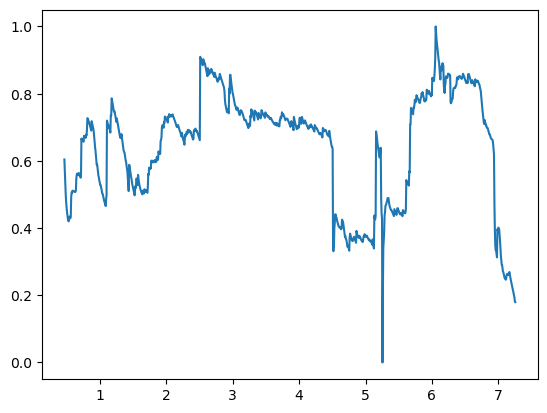

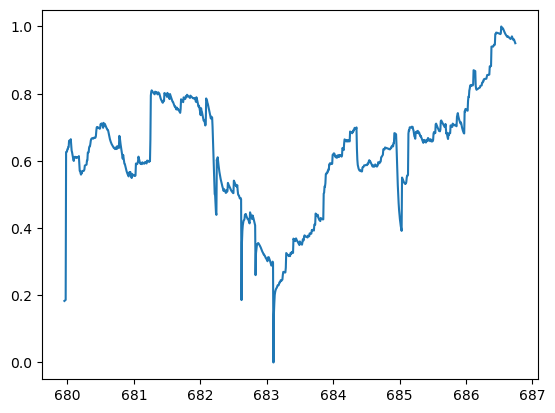

In [4]:
# Load the generated homemade TODs
data_dir = '/home/g_cavallotto/Desktop/LiteBird/NN_synthetic_TOD_code/crab/data'
data_file = 'sdellato_TOD.npy' # homemade_TOD.npy, real_TOD.npy, gui_TOD_basic.npy, gui_TOD_digital.npy, 

with open(f"{data_dir}/{data_file}", 'rb') as file:
    time_steps = np.load(file)
    mins = np.load(file)
    maxs = np.load(file)
    TODs_train = np.load(file)
    TODs_val = np.load(file)
    
# Useful parameters
hit_len = int(0.07//(time_steps[0,2,0]-time_steps[0,1,0]))
bolom_number = TODs_train.shape[2]

'''The HFT hit relax time is taken by the paper at https://www.aanda.org/articles/aa/full_html/2014/09/aa23868-14/aa23868-14.html'''

print('Time step exemple values (s):\n')
for i in range(10):
    print(time_steps[0,i*100+1,0]-time_steps[0,i*100,0])

print('The bins length within which a CR hit relaxes is:', hit_len)
print('Number of bolomenters used is:', bolom_number)
    
if bolom_number == 1:
    time_steps = time_steps[:,:,:1]
    TODs_train = TODs_train[:,:,:1]
    TODs_val = TODs_val[:,:,:1]
    
# Check the loaded homemade TOD
print('TODs simulated by Samantha or Guillermo have the shape: ', TODs_train.shape)

for i in range(time_steps.shape[0]//100):
    plt.plot(time_steps[i*100,:,0], TODs_train[i*100,:,0])
    plt.show()
    
# NNs input dimension
time_bins = len(time_steps[0,:,0])
inputnoise_bins = 100

# Shuffle the training data
TODs_train = tf.random.shuffle(TODs_train, seed=seed)

## Normalization and denormalization of the data
The normalization is done with the simple min max rescale inside the range [0,1]. There is an ad hoc normalization for the output of the generator neural network of the GAN, due to mantain the tensorflow tensor data type pretended by the keras NN layers.

In [5]:
# Normalization and absolute value of the synhtetic TOD

def normalize_synth(inputs):

    mins = tf.repeat(tf.math.reduce_min(inputs, axis=1), inputs.shape[1], axis=0)
    mins = tf.reshape(mins, tf.shape(inputs))
    maxs = tf.repeat(tf.math.reduce_max(inputs, axis=1), inputs.shape[1], axis=0)
    maxs = tf.reshape(maxs, tf.shape(inputs))
    
    return (inputs - mins)/(maxs-mins)

def abs_synth(inputs):
    
    return tf.math.abs(inputs)


# Normalization of the TODs and split in training and validation samples

def normalize(sample):

    mins = np.repeat(np.min(sample, axis=1), sample.shape[1], axis=0)
    mins = mins.reshape(sample.shape)
    maxs = np.repeat(np.max(sample, axis=1), sample.shape[1], axis=0)
    maxs = maxs.reshape(sample.shape)

    sample = (sample - mins)/(maxs-mins)
    
    return sample, mins, maxs

def denormalize(sample, mins, maxs):
    
    sample = mins + (maxs-mins)*(sample)
  
    return sample

## GAN models
There are three GAN classes implemented:
- GAN (basic first implementation of the GAN)
- GAN_1 (second perfectionaed implementation of the GAN)
- WGAN (Wasserstain GAN using the corresponding metric)

All the three classes inherit the methods from the Model class of tensorflow.keras, expecially the fit API to train the NN, even if custom training step functions are implemented for each class. More datails of how customize a model in tensorflow can be found in the the [custom GAN tutorial](https://www.tensorflow.org/tutorials/generative/dcgan)

### GAN
#### Methods


In [6]:
# GAN class wrapping generator-discriminator couple
class GAN(Model):
    """_summary_

    Args:
        Model (_type_): _description_
    """
    
    def __init__(self, generator, discriminator, time_bins, inputnoise_bins):
        
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.time_bins = time_bins
        self.inputnoise_bins = inputnoise_bins
        
    def compile(self, gen_optimizer, discr_optimizer, gen_loss, discr_loss, extra_discr=0, val_data=None):
        
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.discr_optimizer = discr_optimizer
        self.gen_loss = gen_loss
        self.discr_loss = discr_loss
        self.extra_discr = extra_discr
        self.val_data = val_data
        
        '''self.add_metric(Mean(), name="gen_loss")
        self.add_metric(Mean(), name="discr_real_loss")
        self.add_metric(Mean(), name="discr_fake_loss")
        self.add_metric(BinaryAccuracy(), name="gen_acc")
        self.add_metric(BinaryAccuracy(), name="discr_real_acc")
        self.add_metric(BinaryAccuracy(), name="discr_fake_acc")'''
        
        self.gen_loss_tracker = Mean(name="gen_loss")
        self.discr_real_loss_tracker = Mean(name="discr_real_loss")
        self.discr_fake_loss_tracker = Mean(name="discr_fake_loss")
        
        self.gen_loss_val_tracker = Mean(name="gen_loss_val")
        self.discr_real_val_loss_tracker = Mean(name="discr_real_loss_val")
        self.discr_synth_val_loss_tracker = Mean(name="discr_synth_loss_val")
        
        self.gen_acc_tracker = BinaryAccuracy(name="gen_acc", threshold=0.5)
        self.discr_real_acc_tracker = BinaryAccuracy(name="discr_real_acc", threshold=0.5)
        self.discr_synth_acc_tracker = BinaryAccuracy(name="discr_synth_acc", threshold=0.5)
        
    @property
    def metrics(self):
        
        return [self.gen_loss_tracker, self.discr_real_loss_tracker, self.discr_fake_loss_tracker,
                self.gen_loss_val_tracker, self.discr_real_val_loss_tracker, self.discr_synth_val_loss_tracker,
                self.gen_acc_tracker, self.discr_real_acc_tracker, self.discr_synth_acc_tracker]
    
    @tf.function    
    def train_step(self, real_data):
        
        #real_data, val_data = train_test_split(real_data, test_size=val_split)
        
        val_size = self.val_data.shape[0]
        batch_size = real_data.shape[0]
        inputnoise = np.random.normal(size=(batch_size, self.inputnoise_bins))
                
        # Train the discriminator
        for i in range(self.extra_discr+1):
            
            with GradientTape() as disc_real_tape, GradientTape() as disc_fake_tape:

                fake_data = self.generator(inputnoise, training=False)
                real_preds = self.discriminator(real_data, training=True)
                fake_preds = self.discriminator(fake_data, training=True)

                discr_real_loss, discr_fake_loss = self.discr_loss(real_preds, fake_preds)

            discr_real_grad = disc_real_tape.gradient(discr_real_loss, self.discriminator.trainable_variables)      
            _ = self.discr_optimizer.apply_gradients(zip(discr_real_grad, self.discriminator.trainable_variables))

            discr_fake_grad = disc_fake_tape.gradient(discr_fake_loss, self.discriminator.trainable_variables)      
            _ = self.discr_optimizer.apply_gradients(zip(discr_fake_grad, self.discriminator.trainable_variables))
        
        # Train the generator
        with GradientTape() as gen_tape:
            
            synth_TODs = self.generator(inputnoise, training=True)
            synth_preds = self.discriminator(synth_TODs, training=False)

            gen_loss = self.gen_loss(synth_preds)

        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        _ = self.gen_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        
        # Validation
        inputnoise = np.random.normal(size=(val_size, self.inputnoise_bins))
        synth_TODs_val = self.generator(inputnoise, training=False)
        real_preds_val = self.discriminator(self.val_data, training=False)
        synth_preds_val = self.discriminator(synth_TODs_val, training=False)
        
        gen_loss_val = self.gen_loss(synth_preds_val)
        discr_real_loss_val, discr_fake_loss_val = self.discr_loss(real_preds_val, synth_preds_val)
        
        # Update of the metrics
        for m in self.metrics:
            if m.name == 'gen_loss':
                m.update_state(gen_loss)
            if m.name == 'discr_real_loss':
                m.update_state(discr_real_loss)
            if m.name == 'discr_fake_loss':
                m.update_state(discr_fake_loss)
                
            if m.name == 'gen_loss_val':
                m.update_state(gen_loss_val)
            if m.name == 'discr_real_loss_val':
                m.update_state(discr_real_loss_val)
            if m.name == 'discr_synth_loss_val':
                m.update_state(discr_fake_loss_val)
                
            if m.name == 'gen_acc':
                m.update_state(np.ones(val_size), synth_preds_val)
            if m.name == 'discr_real_acc':
                m.update_state(np.ones(val_size), real_preds_val)
            if m.name == 'discr_synth_acc':
                m.update_state(np.zeros(val_size), synth_preds_val)
        
        '''self.gen_loss_tracker.update_state(gen_loss)
        self.discr_real_loss_tracker.update_state(discr_real_loss)
        self.discr_fake_loss_tracker.update_state(discr_fake_loss)
        
        self.gen_acc_tracker.update_state(np.ones(batch_size), synth_preds)
        self.discr_real_acc_tracker.update_state(np.ones(batch_size), real_preds)
        self.discr_fake_acc_tracker.update_state(np.zeros(batch_size), fake_preds)'''
        
        return {m.name: m.result() for m in self.metrics}
    
        '''"gen_loss": self.gen_loss_tracker.result(), "discr_real_loss": self.discr_real_loss_tracker.result(),
        "discr_fake_loss": self.discr_fake_loss_tracker.result(),'''

In [7]:
# GAN_1 class wrapping generator-discriminator couple
class GAN_1(Model):
    
    def __init__(self, generator, discriminator, time_bins, inputnoise_bins):
        
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.time_bins = time_bins
        self.inputnoise_bins = inputnoise_bins
        
    def compile(self, gen_optimizer, discr_optimizer, gen_loss, discr_loss, synth_weight=1, extra_discr=1, val_data=None, logdir=None):
        
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.discr_optimizer = discr_optimizer
        self.gen_loss = gen_loss
        self.discr_loss = discr_loss
        self.synth_weight = synth_weight
        self.extra_discr = extra_discr
        self.val_data = val_data
        
        self.gen_loss_tracker = Mean(name="gen_loss")
        self.discr_loss_tracker = Mean(name="discr_loss")
        
        self.gen_loss_val_tracker = Mean(name="gen_loss_val")
        self.discr_val_loss_tracker = Mean(name="discr_loss_val")

        self.gen_acc_tracker = BinaryAccuracy(name="gen_acc", threshold=0.5)
        self.discr_acc_tracker = BinaryAccuracy(name="discr_acc", threshold=0.5)

        self.epoch_counter = 0
        self.logdir = logdir
        if logdir is not None:
            self.writer = tf.summary.create_file_writer(logdir)
        
    @property
    def metrics(self):
        
        return [self.gen_loss_tracker, self.discr_loss_tracker,
                self.gen_loss_val_tracker, self.discr_val_loss_tracker,
                self.gen_acc_tracker, self.discr_acc_tracker]
    
    #@tf.function    
    def train_step(self, real_data):
        
        val_size = self.val_data.shape[0]

        inputnoise = np.random.normal(size=(real_data.shape[0], self.inputnoise_bins))
        
        # Use the pre-trained discriminator
        if self.extra_discr == 0:
            with GradientTape() as disc_tape:

                fake_data = self.generator(inputnoise, training=False)
                real_preds = self.discriminator(real_data, training=False)
                fake_preds = self.discriminator(fake_data, training=False)

                discr_loss = self.discr_loss(real_preds, fake_preds, self.synth_weight)

        # Train the discriminator
        else:
            for i in range(self.extra_discr):
                with GradientTape() as disc_tape:

                    fake_data = self.generator(inputnoise, training=False)
                    real_preds = self.discriminator(real_data, training=True)
                    fake_preds = self.discriminator(fake_data, training=True)
                    discr_loss = self.discr_loss(real_preds, fake_preds, self.synth_weight)

                discr_grad = disc_tape.gradient(discr_loss, self.discriminator.trainable_variables)
                _ = self.discr_optimizer.apply_gradients((discr_grad, self.discriminator.trainable_variables))

        # Train the generator
        with GradientTape() as gen_tape:
            
            synth_TODs = self.generator(inputnoise, training=True)
            synth_preds = self.discriminator(synth_TODs, training=False)

            gen_loss = self.gen_loss(synth_preds)

        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        _ = self.gen_optimizer.apply_gradients((gen_grad, self.generator.trainable_variables))
        
        # Validation
        inputnoise = np.random.normal(size=(val_size, self.inputnoise_bins))
        synth_TODs_val = self.generator(inputnoise, training=False)
        real_preds_val = self.discriminator(self.val_data, training=False)
        synth_preds_val = self.discriminator(synth_TODs_val, training=False)
        
        gen_loss_val = self.gen_loss(synth_preds_val)
        discr_loss_val = self.discr_loss(real_preds_val, synth_preds_val, self.synth_weight)
        
        # Update of the metrics
        for m in self.metrics:
            if m.name == 'gen_loss':
                m.update_state(gen_loss)
            if m.name == 'discr_loss':
                m.update_state(discr_loss)
                
            if m.name == 'gen_loss_val':
                m.update_state(gen_loss_val)
            if m.name == 'discr_loss_val':
                m.update_state(discr_loss_val)
                
            if m.name == 'gen_acc':
                m.update_state(np.ones(val_size), synth_preds_val)
            if m.name == 'discr_acc':
                m.update_state(tf.concat([np.ones(val_size), np.zeros(val_size)], 0), tf.concat([real_preds_val, synth_preds_val], 0))

        # Send metrics to tf summary writer
        if self.logdir is not None:
            with self.writer.as_default():
                for m in self.metrics:
                    hp.hparams(hparams)
                    tf.summary.scalar(m.name, m.result(), step=self.epoch_counter)
                
        return {m.name: m.result() for m in self.metrics}

    '''# Train process (equivalent to fit general tf function) with intermediete TODs production
    def train(self, time_steps, real_data, batch_size, epochs, save=False, image_dir=None):
        # Create a tensorflow dataset
        dataset = tf.data.Dataset.from_tensor_slices(real_data)
        N_bol = real_data.shape[2]

        for epoch in range(epochs):
            start = time.time()
            train_dataset = dataset.shuffle(buffer_size=real_data.shape[0], reshuffle_each_iteration=True, seed=seed).batch(batch_size)

            for batch_train in train_dataset:
                history = self.train_step(batch_train, batch_size)
            
            # Save the model every 20 epochs
            if (epoch + 1) % 20 == 0:
                #checkpoint.save(file_prefix = checkpoint_prefix)

                # Produce TOD at a given epoch for the GIF as you go
                inputnoise = np.random.normal(size=(1, self.inputnoise_bins))
                self.generate_and_save_TOD(self.generator, epoch, time_steps, inputnoise, save=save, image_dir=image_dir)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start), '\n')

        return history'''

In [8]:
# WGAN class wrapping generator-critic couple
class WGAN(Model):
    
    def __init__(self, generator, discriminator, time_bins, inputnoise_bins):
        
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.time_bins = time_bins
        self.inputnoise_bins = inputnoise_bins
        
    def compile(self, gen_optimizer, discr_optimizer, gen_loss, discr_loss, synth_weight=1, extra_discr=1, val_data=None):
        
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.discr_optimizer = discr_optimizer
        self.gen_loss = gen_loss
        self.discr_loss = discr_loss
        self.synth_weight = synth_weight
        self.extra_discr = extra_discr
        self.val_data = val_data
        
        self.gen_loss_tracker = Mean(name="gen_loss")
        self.discr_loss_tracker = Mean(name="discr_loss")
        
        self.gen_loss_val_tracker = Mean(name="gen_loss_val")
        self.discr_val_loss_tracker = Mean(name="discr_loss_val")

        self.gen_response_tracker = Mean(name="gen_response")
        self.discr_real_response_tracker = Mean(name="discr_real_response")
        self.discr_synth_response_tracker = Mean(name="discr_synth_response")

        
    @property
    def metrics(self):
        
        return [self.gen_loss_tracker, self.discr_loss_tracker,
                self.gen_loss_val_tracker, self.discr_val_loss_tracker,
                self.gen_response_tracker, self.discr_real_response_tracker, self.discr_synth_response_tracker]
    
    @tf.function    
    def train_step(self, real_data, batch_size):
        
        val_size = self.val_data.shape[0]
        
        inputnoise = np.random.normal(size=(batch_size, self.inputnoise_bins))
        
        # Use the pre-trained discriminator
        if self.extra_discr == 0:

            with GradientTape() as disc_tape:

                fake_data = self.generator(inputnoise, training=False)
                real_preds = self.discriminator(real_data, training=False)
                fake_preds = self.discriminator(fake_data, training=False)

                discr_loss = self.discr_loss(real_preds, fake_preds, self.synth_weight)

        # Train the discriminator
        else:
            
            for i in range(self.extra_discr):

                with GradientTape() as disc_tape:

                    fake_data = self.generator(inputnoise, training=False)
                    real_preds = self.discriminator(real_data, training=True)
                    fake_preds = self.discriminator(fake_data, training=True)

                    discr_loss = self.discr_loss(real_preds, fake_preds, self.synth_weight)

                discr_grad = disc_tape.gradient(discr_loss, self.discriminator.trainable_variables)      
                _ = self.discr_optimizer.apply_gradients(zip(discr_grad, self.discriminator.trainable_variables))

                for w in self.discriminator.trainable_variables:
                
                    w.assign(clip_by_value(w, -1., 1.))

        # Train the generator
        with GradientTape() as gen_tape:
            
            synth_TODs = self.generator(inputnoise, training=True)
            synth_preds = self.discriminator(synth_TODs, training=False)

            gen_loss = self.gen_loss(synth_preds)

        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        _ = self.gen_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))

        for w in self.discriminator.trainable_variables:
                
                w.assign(clip_by_value(w, -1., 1.))
        
        # Validation
        inputnoise = np.random.normal(size=(val_size, self.inputnoise_bins))
        synth_TODs_val = self.generator(inputnoise, training=False)
        real_preds_val = self.discriminator(self.val_data, training=False)
        synth_preds_val = self.discriminator(synth_TODs_val, training=False)
        
        gen_loss_val = self.gen_loss(synth_preds_val)
        discr_loss_val = self.discr_loss(real_preds_val, synth_preds_val, self.synth_weight)
        
        # Update of the metrics
        for m in self.metrics:
            if m.name == 'gen_loss':
                m.update_state(gen_loss)
            if m.name == 'discr_loss':
                m.update_state(discr_loss)
                
            if m.name == 'gen_loss_val':
                m.update_state(gen_loss_val)
            if m.name == 'discr_loss_val':
                m.update_state(discr_loss_val)
                
            if m.name == 'gen_response':
                m.update_state(synth_preds_val)
            if m.name == 'discr_real_response':
                m.update_state(real_preds_val)
            if m.name == 'discr_synth_response':
                m.update_state(fake_preds)
            
        return {m.name: m.result() for m in self.metrics}

## NN sequential models
- 
- 

In [9]:
# Custom sparsely connected layer
class SparseFullyConnected(tf.keras.layers.Layer):
    def __init__(self, out_dim, conn, activation=None):
        super().__init__()
        self.out_dim = out_dim
        self.conn = conn
        self.activation = activation

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=(input_shape[-1], self.out_dim), initializer="glorot_uniform")
        self.bias = self.add_weight("bias", shape=(self.out_dim,), initializer="zeros")

    def call(self, inputs):
        connected_values = tf.math.top_k(inputs, k=self.conn).values
        output = tf.matmul(connected_values, self.kernel) + self.bias

        if self.activation is not None:
            output = self.activation(output)

        return output

class NN_list():
    
    def __init__(self, time_bins, inputnoise_bins, hit_len):
        
        super().__init__()
        self.generator_names = ['simple_generator_model', 'empty_generator_model', 'real_generator_model', 'real_empty_generator_model', 'wide_generator_model']
        self.discriminator_names = ['simple_discriminator_model', 'simple_critic_model_relu', 'simple_critic_model_smooth', 'real_discriminator_model']
        self.generators = [simple_generator_model(time_bins, inputnoise_bins, hit_len), empty_generator_model(time_bins, inputnoise_bins), real_generator_model(time_bins, inputnoise_bins, hit_len), real_empty_generator_model(time_bins, inputnoise_bins), wide_generator_model(time_bins, inputnoise_bins, hit_len)]
        self.discriminators = [simple_discriminator_model(time_bins), simple_critic_model_relu(time_bins), simple_critic_model_smooth(time_bins), real_discriminator_model(time_bins, hit_len)]

# ----------------------------------------------------

# Define simplest Generator and discriminator models of GAN
def simple_generator_model(time_bins, inputnoise_bins, hit_len):
    
    model = Sequential([
        Input(shape=(inputnoise_bins,)),
        Dense(time_bins//6),
        LeakyReLU(),
        Reshape((time_bins//6, 1)),
        Conv1DTranspose(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(32, hit_len, padding='same', strides = 3, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        SeparableConv1D(1, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        Lambda(abs_synth),
        Lambda(normalize_synth)],
        name='Generator')
    
    return model

def simple_discriminator_model(time_bins):
    
    model = Sequential([
        Input(shape=(time_bins, 1)),
        Conv1D(8, 2*hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(32, hit_len, padding='same', strides = hit_len//2, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Flatten(),
        Dense(1, activation='sigmoid')],
        name='Discriminator')
    
    return model

def simple_critic_model_relu(time_bins):
    
    model = Sequential([
        Input(shape=(time_bins, 1)),
        Conv1D(10, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1D(10, hit_len, padding='same', strides = hit_len, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1D(10, hit_len//2, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1D(10, hit_len//2, padding='same', strides = hit_len//2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Flatten(),
        Dense(1, activation='linear')],
        name='Critic')

    
    return model

def simple_critic_model_smooth(time_bins):
    
    model = Sequential([
        Input(shape=(time_bins, 1)),
        Conv1D(10, hit_len//2, padding='same', strides = 1, data_format='channels_last', activation='tanh'),
        BatchNormalization(),
        Conv1D(10, hit_len, padding='same', strides = 1, data_format='channels_last', activation='tanh'),
        BatchNormalization(),
        Conv1D(10, hit_len//2, padding='same', strides = 2, data_format='channels_last', activation='tanh'),
        BatchNormalization(),
        Conv1D(10, hit_len, padding='same', strides = hit_len//2, data_format='channels_last', activation='tanh'),
        BatchNormalization(),
        Flatten(),
        Dense(1, activation='linear')],
        name='Critic')

    
    return model

# Define a test empty generator
def empty_generator_model(time_bins, inputnoise_bins):
    
    model = Sequential([
        Input(shape=(inputnoise_bins,)),
        Dense(time_bins//12, trainable=False),
        Reshape((time_bins//12, 1)),
        Conv1DTranspose(1, 12, padding='same', strides = 12, data_format='channels_last', trainable=False)],
        name='Empty_generator')
    
    return model

# ----------------------------------------------------

# Define the Generator and discriminator models of GAN for the Samantah and Guillermo data
def real_generator_model(time_bins, inputnoise_bins, hit_len):
    
    model = Sequential([
        Input(shape=(inputnoise_bins,)),
        Dense(time_bins//4),
        LeakyReLU(),
        Reshape((time_bins//4, 1)),
        Conv1DTranspose(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(32, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        SeparableConv1D(bolom_number, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        #Lambda(abs_synth),
        Lambda(normalize_synth)],
        name='Generator')
    
    return model

def real_discriminator_model(time_bins, hit_len):
    
    model = Sequential([
        Input(shape=(time_bins, bolom_number,)),
        Conv1D(8, 2*hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(32, hit_len, padding='same', strides = hit_len//2, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Flatten(),
        Dense(1, activation='sigmoid')],
        name='Discriminator')
    
    return model
    
# Define a test empty generator
def real_empty_generator_model(time_bins, inputnoise_bins):
    
    model = Sequential([
        Input(shape=(inputnoise_bins,)),
        Dense(time_bins//10, trainable=False),
        Reshape((time_bins//10, 1)),
        Conv1DTranspose(bolom_number, 10, padding='same', strides = 10, data_format='channels_last', trainable=False),
        Lambda(normalize_synth)],
        name='Empty_generator')
    
    return model

# ----------------------------------------------------

# Define wide Generator and discriminator models of GAN
def wide_generator_model(time_bins, inputnoise_bins, hit_len):
    
    model = Sequential([
        Input(shape=(inputnoise_bins,)),
        Dense(time_bins//4),
        LeakyReLU(),
        Reshape((time_bins//4, 1)),
        Conv1DTranspose(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(32, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        SeparableConv1D(bolom_number, hit_len, padding='same', strides = 1, data_format='channels_last'),
        Reshape((bolom_number*time_bins,)),
        Dense(bolom_number*time_bins),
        LeakyReLU(),
        Reshape((time_bins, bolom_number,)),
        Lambda(abs_synth),
        Lambda(normalize_synth)],
        name='Generator')
    
    return model

# ----------------------------------------------------

# Define the Generator and discriminator models of GAN for the Samantah and Guillermo data and their transformated
def multiple_generator_model(time_bins, inputnoise_bins, hit_len):
    
    model = Sequential([
        Input(shape=(inputnoise_bins,)),
        Dense(time_bins//4),
        LeakyReLU(),
        Reshape((time_bins//4, 1)),
        Conv1DTranspose(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1DTranspose(32, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        SeparableConv1D(bolom_number, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        Lambda(abs_synth),
        Lambda(normalize_synth)],
        name='Generator')
    
    return model

def multiple_discriminator_model(time_bins, hit_len):
    
    model = Sequential([
        Input(shape=(time_bins, bolom_number,)),
        Conv1D(8, 2*hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(8, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Conv1D(32, hit_len, padding='same', strides = hit_len//2, data_format='channels_last'),
        LeakyReLU(),
        LayerNormalization(),
        Flatten(),
        Dense(1, activation='sigmoid')],
        name='Discriminator')
    
    return model
    
# Define a test empty generator
def multiple_empty_generator_model(time_bins, inputnoise_bins):
    
    model = Sequential([
        Input(shape=(inputnoise_bins,)),
        Dense(time_bins//10, trainable=False),
        Reshape((time_bins//10, 1)),
        Conv1DTranspose(bolom_number, 10, padding='same', strides = 10, data_format='channels_last', trainable=False)],
        name='Empty_generator')
    
    return model

# Show the implemented NN structures for the GAN model
# models_list = NN_list(time_bins, inputnoise_bins, hit_len)

print(f'The structure of the generator simple_generator_model model is:')
simple_generator_model(time_bins, inputnoise_bins, hit_len).summary()
print(f'The structure of the generator empty_generator_model model is:')
empty_generator_model(time_bins, inputnoise_bins).summary()
print(f'The structure of the generator real_generator_model model is:')
real_generator_model(time_bins, inputnoise_bins, hit_len).summary()
print(f'The structure of the generator real_empty_generator_model model is:')
real_empty_generator_model(time_bins, inputnoise_bins).summary()
# print(f'The structure of the generator wide_generator_model model is:')
# wide_generator_model(time_bins, inputnoise_bins, hit_len).summary()
print(f'The structure of the generator simple_discriminator_model model is:')
simple_discriminator_model(time_bins).summary()
print(f'The structure of the generator simple_critic_model_relu model is:')
simple_critic_model_relu(time_bins).summary()
print(f'The structure of the generator simple_critic_model_smooth model is:')
simple_critic_model_smooth(time_bins).summary()
print(f'The structure of the generator real_discriminator_model model is:')
real_discriminator_model(time_bins, hit_len).summary()

'''for i in range(len(models_list.generator_names)):
    print(f'The structure of the generator {models_list.generator_names[i]} model is:')
    show_model = models_list.generators[i]
    show_model.summary()
    
for i in range(len(models_list.discriminator_names)):
    print(f'The structure of the generator {models_list.discriminator_names[i]} model is:\n')
    models_list.discriminators[i].summary()'''

The structure of the generator simple_generator_model model is:


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 176)            │        17,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 176)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 176, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 176, 8)         │            88 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 176, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 176, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 352, 16)        │         1,296 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 352, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 352, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 1056, 32)       │         5,152 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1056, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1056, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d                │ (None, 1056, 1)        │           353 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1056, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1056, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1056, 1)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,889 (97.22 KB)

 Trainable params: 24,777 (96.79 KB)

 Non-trainable params: 112 (448.00 B)

The structure of the generator empty_generator_model model is:


Model: "Empty_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 88)             │         8,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 88, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 1056, 1)        │            13 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,901 (34.77 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,901 (34.77 KB)

The structure of the generator real_generator_model model is:


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 265)            │        26,765 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 265)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 265, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 265, 8)         │            88 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 265, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 265, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 530, 16)        │         1,296 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 530, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 530, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_6              │ (None, 1060, 32)       │         5,152 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 1060, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1060, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_1              │ (None, 1060, 127)      │         4,511 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 1060, 127)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 1060, 127)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,036 (148.58 KB)

 Trainable params: 37,924 (148.14 KB)

 Non-trainable params: 112 (448.00 B)

The structure of the generator real_empty_generator_model model is:


Model: "Empty_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 106)            │        10,706 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 106, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_7              │ (None, 1060, 127)      │         1,397 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 1060, 127)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,103 (47.28 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,103 (47.28 KB)

The structure of the generator simple_discriminator_model model is:


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1060, 8)        │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 1060, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 1060, 8)        │            16 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1060, 8)        │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 1060, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 1060, 8)        │            16 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 530, 16)        │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 530, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 530, 16)        │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 106, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 106, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 106, 32)        │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3392)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         3,393 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,785 (42.13 KB)

 Trainable params: 10,785 (42.13 KB)

 Non-trainable params: 0 (0.00 B)

The structure of the generator simple_critic_model_relu model is:


Model: "Critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 1060, 10)       │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 1060, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1060, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 106, 10)        │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 106, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 106, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 53, 10)         │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 53, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 53, 10)         │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 11, 10)         │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 11, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 11, 10)         │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 110)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411 (9.42 KB)

 Trainable params: 2,331 (9.11 KB)

 Non-trainable params: 80 (320.00 B)

The structure of the generator simple_critic_model_smooth model is:


Model: "Critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 1060, 10)       │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1060, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 1060, 10)       │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1060, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 530, 10)        │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 530, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 106, 10)        │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 106, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1060)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │         1,061 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,811 (14.89 KB)

 Trainable params: 3,731 (14.57 KB)

 Non-trainable params: 80 (320.00 B)

The structure of the generator real_discriminator_model model is:


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 1060, 8)        │        20,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 1060, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 1060, 8)        │            16 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 1060, 8)        │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 1060, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 1060, 8)        │            16 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 530, 16)        │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 530, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 530, 16)        │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 106, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 106, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 106, 32)        │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3392)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │         3,393 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,945 (120.88 KB)

 Trainable params: 30,945 (120.88 KB)

 Non-trainable params: 0 (0.00 B)

"for i in range(len(models_list.generator_names)):\n    print(f'The structure of the generator {models_list.generator_names[i]} model is:')\n    show_model = models_list.generators[i]\n    show_model.summary()\n    \nfor i in range(len(models_list.discriminator_names)):\n    print(f'The structure of the generator {models_list.discriminator_names[i]} model is:\n')\n    models_list.discriminators[i].summary()"

## Loss functions

In [10]:
# Definition of loss functions with binary cross entropy between the NNs predictions and correct labels for
# both GAN and WGAN
model_struct = 'GAN_1'

#label smooting of the prediction for generator and discriminator loss computation
gen_label_smoothing = 0
discr_label_smoothing = 0

if model_struct == 'GAN':
    
    cross_entropy = BinaryCrossentropy(from_logits=False)

    def gen_loss(synth_preds):

        return cross_entropy(np.ones(synth_preds.shape), synth_preds)

    def discr_loss(real_preds, synth_preds):

        real_loss = cross_entropy(np.ones(real_preds.shape), real_preds)
        synth_loss = cross_entropy(np.zeros(synth_preds.shape), synth_preds)

        return real_loss, synth_loss
    
if model_struct == 'GAN_1':
    
    cross_entropy_gen = BinaryCrossentropy(from_logits=False, label_smoothing=gen_label_smoothing)
    cross_entropy_discr = BinaryCrossentropy(from_logits=False, label_smoothing=discr_label_smoothing)

    def gen_loss(synth_preds):

        return cross_entropy_gen(np.ones(synth_preds.shape), synth_preds)

    def discr_loss(real_preds, synth_preds, synth_weight):

        real_loss = cross_entropy_discr(np.ones(real_preds.shape), real_preds, sample_weight=1)
        synth_loss = cross_entropy_discr(np.zeros(synth_preds.shape), synth_preds, sample_weight=synth_weight)

        return real_loss + synth_loss

if model_struct == 'WGAN':

    def gen_loss(synth_preds):

        return - reduce_mean(synth_preds)

    def discr_loss(real_preds, synth_preds, sample_weight):

        real_loss = reduce_mean(real_preds)
        synth_loss = sample_weight*reduce_mean(synth_preds)

        return synth_loss - real_loss

## Custom callback functions

In [11]:
class ShowTODCallback(Callback):
    def __init__(self, gan, time_steps, inputnoise_bins, real_TOD, epoch_snapshow=20):
        
        super().__init__()
        self.gan = gan
        self.inputnoise_bins = inputnoise_bins
        self.time_steps = time_steps
        self.real_TOD = real_TOD
        self.epoch_snapshow = epoch_snapshow
        self.TOD_im_array = []
        self.resp_im_array = []
        
    # Custom lines to be executed at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        # Save the model every 20 epochs
        if (epoch + 1) % self.epoch_snapshow == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)

            # Produce TOD at a given epoch for the GIF as you go
            inputnoise1 = np.random.normal(size=(1, self.inputnoise_bins))
            inputnoise2 = np.random.normal(size=(self.time_steps.shape[0], self.inputnoise_bins))
            self.generate_intermediate_TOD(self.gan.generator, epoch, self.time_steps, inputnoise1)
            self.generate_intermediate_response(self.gan.generator, self.gan.discriminator, epoch, self.time_steps, inputnoise2, self.real_TOD)

    # Generate a TOD at a given epoch (with the first timestep snap)
    def generate_intermediate_TOD(self, generator, epoch, time_steps, test_inputnoise):
        prediction = generator(test_inputnoise, training=False)

        rows = int(np.sqrt(prediction.shape[2]))
        cols = prediction.shape[2]//rows
        if rows == 1:
            fig, ax = plt.subplots(figsize = (5,5))
            fig.suptitle(f'Generated TOD examples at epoch {epoch+1}')
            plt.tight_layout()

            TOD_id = int(np.random.rand()*time_steps.shape[0])

            
            ax.set_ylabel('Normilized power', loc='center')
            ax.set_xlabel('Time (s)', loc='center')
            ax.plot(time_steps[TOD_id,:,0], prediction[0,:,0])

        else:
            fig, ax = plt.subplots(rows, cols, figsize = (16,11), sharex=True, sharey=True)
            fig.suptitle(f'Generated TOD examples at epoch {epoch+1}')
            plt.tight_layout()

            TOD_id = int(np.random.rand()*time_steps.shape[0])

            for i in range (rows):
                ax[i, 0].set_ylabel('Normilized power', loc='center')
                for k in range(cols):
                    ax[rows-1, k].set_xlabel('Time (s)', loc='center')
                    ax[i,k].plot(time_steps[TOD_id,:,k+i*cols], prediction[0,:,k+i*cols])
        
        plt.show()
        plt.close()

        '''# Save the figure to the array
        fig.canvas.draw()  # Update the figure
        im = np.array(fig.canvas.renderer.buffer_rgba())  # Convert figure to numpy array
        # Convert the numpy array to a PIL image
        pil_im = Image.fromarray(im)
        self.TOD_im_array.append(pil_im)
        plt.close(fig)'''

    # Plot the discriminator response on a generated and real sample of TODs at a given epoch
    def generate_intermediate_response(self, generator, discriminator, epoch, time_steps, test_inputnoise, real_TOD):
        prediction = generator(test_inputnoise, training=False)
        test_response_synth = discriminator.predict(prediction)
        test_response_real = discriminator.predict(real_TOD)

        fig, ax = plt.subplots(figsize = (6, 6))

        ax.hist(test_response_synth, label="Synthetic", range=(0,1), bins=100, alpha=0.5)
        ax.hist(test_response_real, label="Real", range=(0,1), bins=100, alpha=0.5)
        # ax.plot(test_response_synth - test_response_real, label="Difference")
        ax.set_title("Discriminator response")
        ax.legend()
        plt.show()
        
        '''# Save the figure to the array
        fig.canvas.draw()  # Update the figure
        im = np.array(fig.canvas.renderer.buffer_rgba())  # Convert figure to numpy array
        # Convert the numpy array to a PIL image
        pil_im = Image.fromarray(im)
        self.resp_im_array.append(pil_im)
        plt.close(fig)'''

'''class TfSummaryCallback(Callback):

    def __init__(self, logdir=None, writer, gen_loss, discr_loss, gen_loss_val, discr_loss_val, gen_acc, discr_acc):
        
        super().__init__()
        self.logdir = logdir
        self.writer = writer 
        self.gen_loss =  gen_loss 
        self.discr_loss =  discr_loss 
        self.gen_loss_val =  gen_loss_val 
        self.discr_loss_val =  discr_loss_val 
        self.gen_acc =  gen_acc 
        self.discr_acc =  discr_acc

    def on_epoch_end(self, epoch, logs=None):
        if self.logdir in not None:
            with writer.as_default():
                    tf.summary.scalar('gen_loss', self.gen_loss, step=epoch)
                    tf.summary.scalar('discr_loss', self.discr_loss, step=epoch)
                    tf.summary.scalar('gen_loss_val', self.gen_loss_val, step=epoch)
                    tf.summary.scalar('discr_loss_val', self.discr_loss_val, step=epoch)
                    tf.summary.scalar('gen_acc', self.gen_acc, step=epoch)
                    tf.summary.scalar('discr_acc', self.discr_acc, step=epoch)'''

class EpochCounter(Callback):

    def __init__(self, epoch_counter, verbose=False):
        super().__init__()
        self.verbose = verbose
        self.epoch_counter = epoch_counter

    def on_epoch_begin(self, epoch, logs=None):
        if self.verbose:
            print(f'Training epoch {epoch} start')
        self.epoch_counter = epoch

In [12]:
# Set the optimizers and train parameters
batch_size1 = 64
epochs = 20
lr = 1e-3
momentum = 0.5
synth_weight = 0.5

# Optimizer
optim = 'Adam'

if optim == 'SGD':
    gen_optimizer = SGD(learning_rate=lr, momentum=momentum)
    discr_optimizer = SGD(learning_rate=lr, momentum=momentum)
    
if optim == 'Adam':
    gen_optimizer = Adam(learning_rate=lr)
    discr_optimizer = Adam(learning_rate=lr)
    
if optim == 'Nadam':
    gen_optimizer = Nadam(learning_rate=lr)
    discr_optimizer = Nadam(learning_rate=lr)

val_split = 0.1

# Create the directory to save the result plots
model_dir = '../models/sdellato_complete_gan_34'
! rm -r {model_dir}
! mkdir {model_dir}

# Build the GAN (only discriminator)
gen_empty = real_empty_generator_model(time_bins, inputnoise_bins)
discr_pretrain = real_discriminator_model(time_bins, hit_len)
gen_empty.summary()
discr_pretrain.summary()

with open(model_dir + '/model_summary.txt', 'w') as f:
    gen_empty.summary(print_fn=lambda x: f.write(x + '\n'))
    discr_pretrain.summary(print_fn=lambda x: f.write(x + '\n'))

if model_struct == 'GAN_1':
    gan_pretrain = GAN_1(gen_empty, discr_pretrain, time_bins, inputnoise_bins)

if model_struct == 'WGAN':
    gan_pretrain = WGAN(gen_empty, discr_pretrain, time_bins, inputnoise_bins)

gan_pretrain.compile(gen_optimizer, discr_optimizer, gen_loss, discr_loss, synth_weight, val_data=TODs_val)

Model: "Empty_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 106)            │        10,706 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 106, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_8              │ (None, 1060, 127)      │         1,397 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 1060, 127)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,103 (47.28 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,103 (47.28 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 1060, 8)        │        20,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 1060, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 1060, 8)        │            16 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 1060, 8)        │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 1060, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (None, 1060, 8)        │            16 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 530, 16)        │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 530, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_10          │ (None, 530, 16)        │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 106, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 106, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_11          │ (None, 106, 32)        │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3392)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         3,393 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,945 (120.88 KB)

 Trainable params: 30,945 (120.88 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Turn interactive plotting off
plt.ioff()

# Adjust the dataset sample to be a multiple of the batch size (instead there is a training crash!)
last_data = (TODs_train.shape[0]//batch_size1)*batch_size1
TODs_train_cut = TODs_train[:last_data]
print('Train dataset has the shape: ', TODs_train_cut.shape, '\n')

# Image array where store the intermediate training stages of generated TODs
epoch_snapshow1 = 5
custom_callback1 = ShowTODCallback(gan_pretrain, time_steps, inputnoise_bins, TODs_train, epoch_snapshow=epoch_snapshow1)

# Pre-train and validate the discriminator and save its weights
history1 = gan_pretrain.fit(TODs_train_cut, batch_size=batch_size1, epochs=epochs, callbacks=[custom_callback1])
gan_pretrain.discriminator.save_weights(model_dir + '/pretrained_discr.h5')

# Save pre-trained weights
gan_pretrain_weights = gan_pretrain.discriminator.weights

Train dataset has the shape:  (192, 1060, 127) 

Epoch 1/20


ValueError: too many values to unpack (expected 2)

In [ ]:
intermediete_plot = False
if intermediete_plot:
    # Turn interactive plotting off
    plt.ioff()

    # GIF of the intermediate training stages of generated TODs
    TOD_im_array1 = custom_callback1.TOD_im_array
    print('Number of intemediete snapshots taken = ', np.shape(TOD_im_array1)[0])

    for i in range(np.shape(TOD_im_array1)[0]):
        fig_gif, ax_gif = plt.subplots()
        ax_gif.set_title(f'Generated TOD examples at epoch {(i+1)*epoch_snapshow1}')
        plt.imshow(TOD_im_array1[i])
        plt.axis('off')

    resp_im_array1 = custom_callback1.resp_im_array

    for i in range(np.shape(resp_im_array1)[0]):
        fig_gif, ax_gif = plt.subplots()
        ax_gif.set_title(f'Discriminator response examples at epoch {(i+1)*epoch_snapshow1}')
        ax_gif.imshow(resp_im_array1[i])

    '''def update_im(i):
        ax_gif.imshow(im_array1[i])
        ax_gif.set_title(f'Generated TOD examples at epoch {i*epoch_snapshow1}')
        return ax_gif
    '''
    # Create the animation object
    # animation_fig1 = FuncAnimation(fig_gif, update_im, frames=np.shape(im_array1)[0], interval=200, repeat_delay=10)

    # Show and save the animation
    plt.show()
    #animation_fig.save(f"{model_dir}/pretrain_intermediate_TOD.gif")

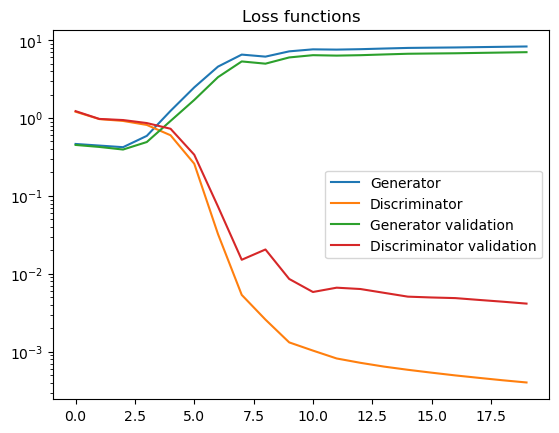

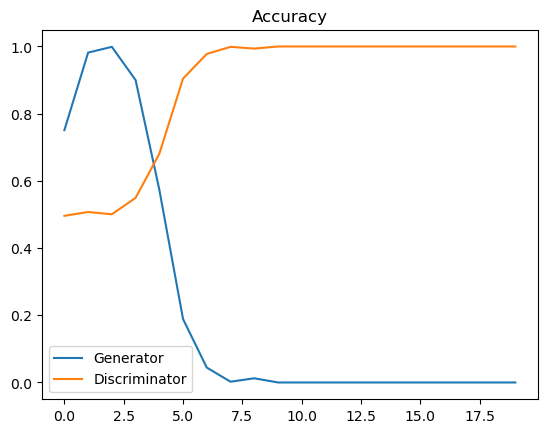

In [ ]:
# Plot the training losses along the epochs
if model_struct == 'GAN_1':

    plt.plot(history1.history["gen_loss"], label="Generator")
    plt.plot(history1.history["discr_loss"], label="Discriminator")
    plt.plot(history1.history["gen_loss_val"], label="Generator validation")
    plt.plot(history1.history["discr_loss_val"], label="Discriminator validation")
    plt.yscale("log")
    plt.title("Loss functions")
    plt.legend()
    plt.savefig(model_dir + '/loss_pretrain.pdf')
    plt.show()

    # Plot the accuracy along the epochs
    plt.plot(history1.history["gen_acc"], label="Generator")
    plt.plot(history1.history["discr_acc"], label="Discriminator")
    plt.title("Accuracy")
    plt.legend()
    plt.savefig(model_dir + '/acc_pretrain.pdf')
    plt.show()

if model_struct == 'WGAN':

    plt.plot(history1.history["gen_loss"], label="Generator")
    plt.plot(history1.history["discr_loss"], label="Discriminator")
    plt.plot(history1.history["gen_loss_val"], label="Generator validation")
    plt.plot(history1.history["discr_loss_val"], label="Discriminator validation")
    # plt.yscale("log")
    plt.title("Loss functions")
    plt.legend()
    plt.savefig(model_dir + '/loss_pretrain.pdf')
    plt.show()

    # Plot the accuracy along the epochs
    plt.plot(history1.history["gen_response"], label="Generator")
    plt.plot(history1.history["discr_real_response"], label="Discriminator on real")
    plt.plot(history1.history["discr_synth_response"], label="Discriminator on synthetic")
    plt.title("Responses")
    plt.legend()
    plt.savefig(model_dir + '/resp_pretrain.pdf')
    plt.show()

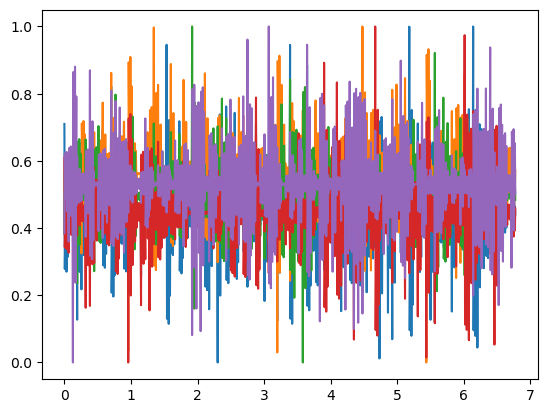

3/3 [==============================] - 0s 5ms/step


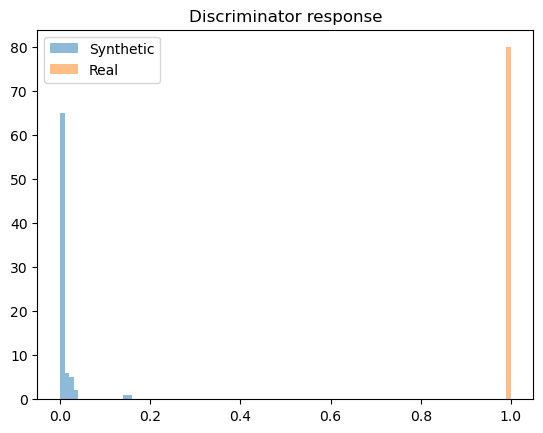

In [ ]:
# Plot some synthetic TOD after the training
test_inputnoise = np.random.normal(size=(TODs_val.shape[0], inputnoise_bins))
test_synth_TODs = gan_pretrain.generator(test_inputnoise)

for i in range(5):
    plt.plot(time_steps[0,:,0], test_synth_TODs[i*TODs_val.shape[0]//5,:,0])
plt.show()

# TEst the Discriminator response for synthetic TOD
#test_response_synth = gan_toy.discriminator(test_synth_TODs)
#test_response_real = gan_toy.discriminator(TODs_val)
test_response_synth = gan_pretrain.discriminator.predict(test_synth_TODs)
test_response_real = gan_pretrain.discriminator.predict(TODs_val)
plt.hist(test_response_synth, label="Synthetic", range=(0,1), bins=100, alpha=0.5)
plt.hist(test_response_real, label="Real", range=(0,1), bins=100, alpha=0.5)
#plt.plot(test_response_synth - test_response_real, label="Difference")
plt.title("Discriminator response")
plt.legend()

plt.savefig(model_dir + '/response_pretrain.pdf')
plt.show()

#print(reduce_mean(test_response_real))
#print(reduce_mean(test_response_synth))
#print(reduce_mean(test_response_synth) - reduce_mean(test_response_real))

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 265)               26765     
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 265)               0         
                                                                 
 reshape_8 (Reshape)         (None, 265, 1)            0         
                                                                 
 conv1d_transpose_12 (Conv1  (None, 265, 8)            88        
 DTranspose)                                                     
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 265, 8)            0         
                                                                 
 batch_normalization_17 (Ba  (None, 265, 8)            32        
 tchNormalization)                                       

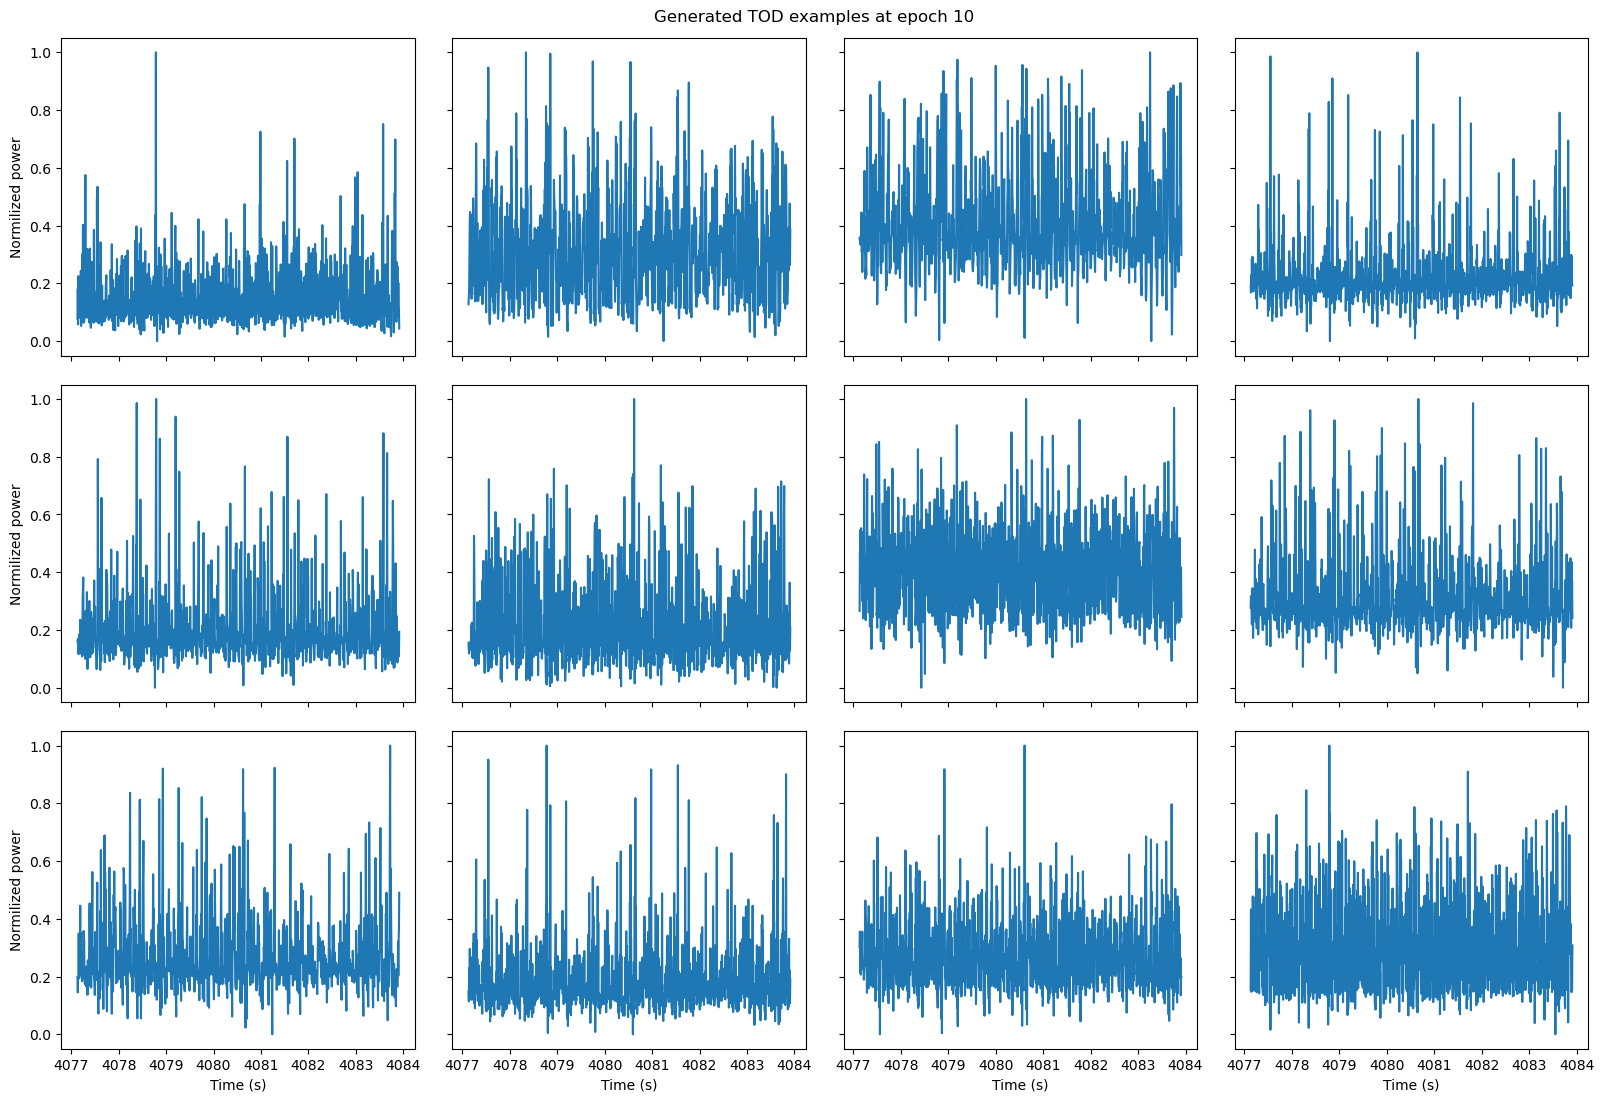

23/23 [==============================] - 0s 5ms/step


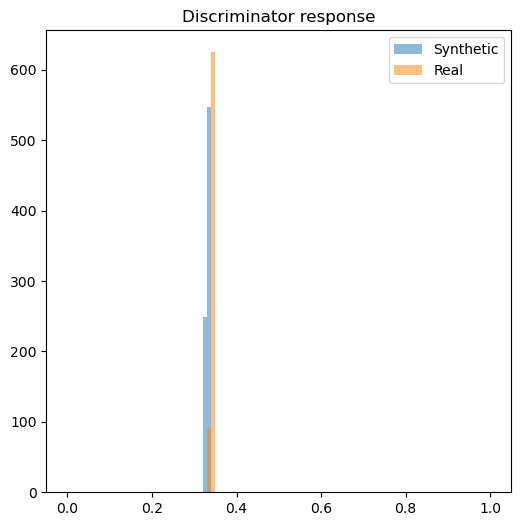

11/11 [==============================] - 9s 806ms/step - gen_loss: 1.1081 - discr_loss: 1.8893 - gen_loss_val: 1.1009 - discr_loss_val: 1.8936 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 11/200
11/11 [==============================] - 6s 590ms/step - gen_loss: 1.1472 - discr_loss: 1.8074 - gen_loss_val: 1.1148 - discr_loss_val: 1.8250 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 12/200
11/11 [==============================] - 7s 596ms/step - gen_loss: 1.6098 - discr_loss: 1.6106 - gen_loss_val: 1.1080 - discr_loss_val: 2.2726 - gen_acc: 0.1557 - discr_acc: 0.6222
Epoch 13/200
11/11 [==============================] - 7s 599ms/step - gen_loss: 1.1950 - discr_loss: 1.7146 - gen_loss_val: 1.2011 - discr_loss_val: 1.6910 - gen_acc: 0.0000e+00 - discr_acc: 0.5625
Epoch 14/200
11/11 [==============================] - 7s 600ms/step - gen_loss: 1.5983 - discr_loss: 2.4912 - gen_loss_val: 1.5032 - discr_loss_val: 2.0560 - gen_acc: 0.1977 - discr_acc: 0.5375
Epoch 15/200
11/11 [===========

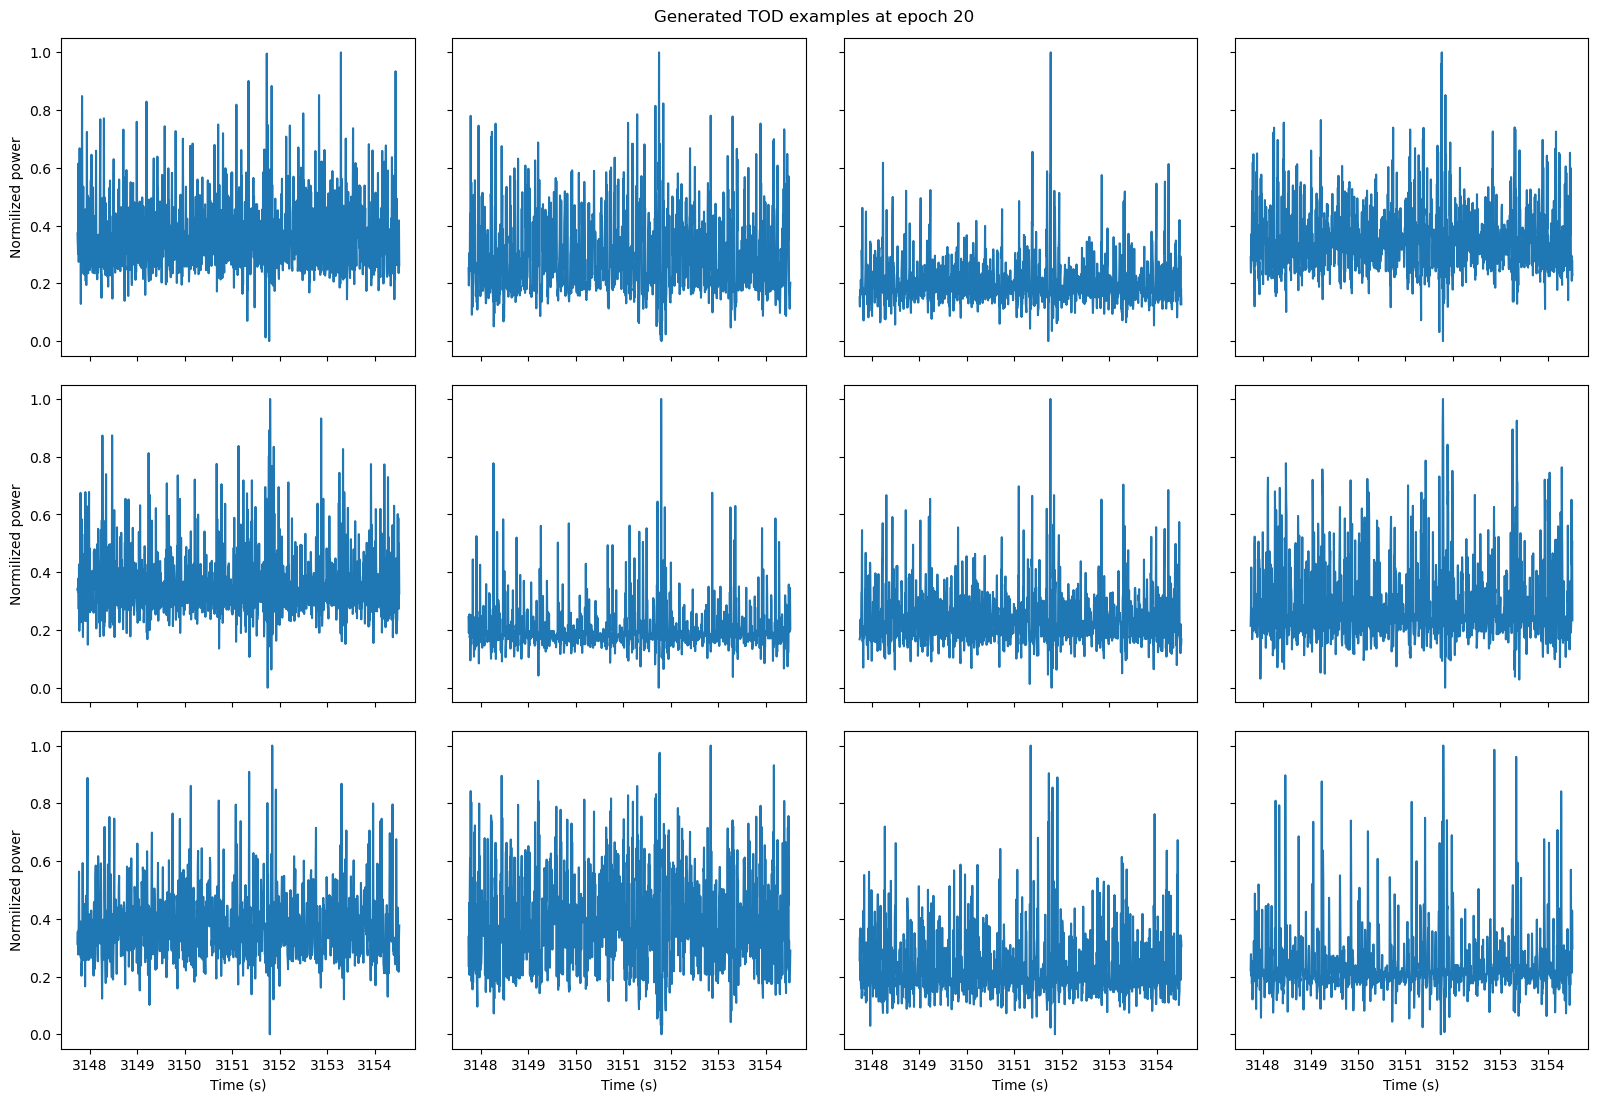

23/23 [==============================] - 0s 5ms/step


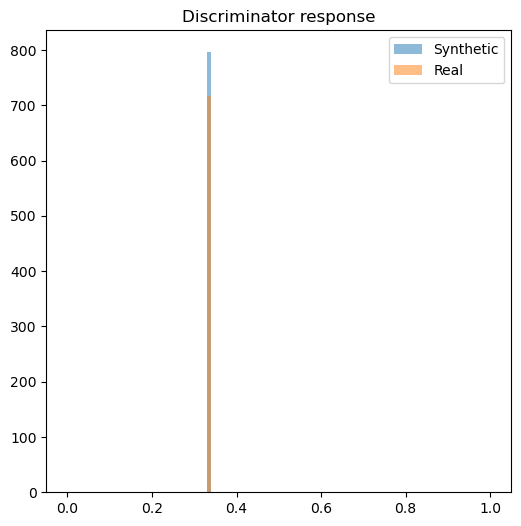

11/11 [==============================] - 8s 781ms/step - gen_loss: 1.0876 - discr_loss: 1.9176 - gen_loss_val: 1.0876 - discr_loss_val: 1.9238 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 21/200
11/11 [==============================] - 7s 602ms/step - gen_loss: 1.0997 - discr_loss: 1.9092 - gen_loss_val: 1.0997 - discr_loss_val: 1.9092 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 22/200
11/11 [==============================] - 7s 590ms/step - gen_loss: 1.0993 - discr_loss: 1.9081 - gen_loss_val: 1.0991 - discr_loss_val: 1.9083 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 23/200
11/11 [==============================] - 7s 601ms/step - gen_loss: 1.0997 - discr_loss: 1.9069 - gen_loss_val: 1.0994 - discr_loss_val: 1.9072 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 24/200
11/11 [==============================] - 7s 596ms/step - gen_loss: 1.1002 - discr_loss: 1.9054 - gen_loss_val: 1.0996 - discr_loss_val: 1.9060 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 25/200
11/11 [===

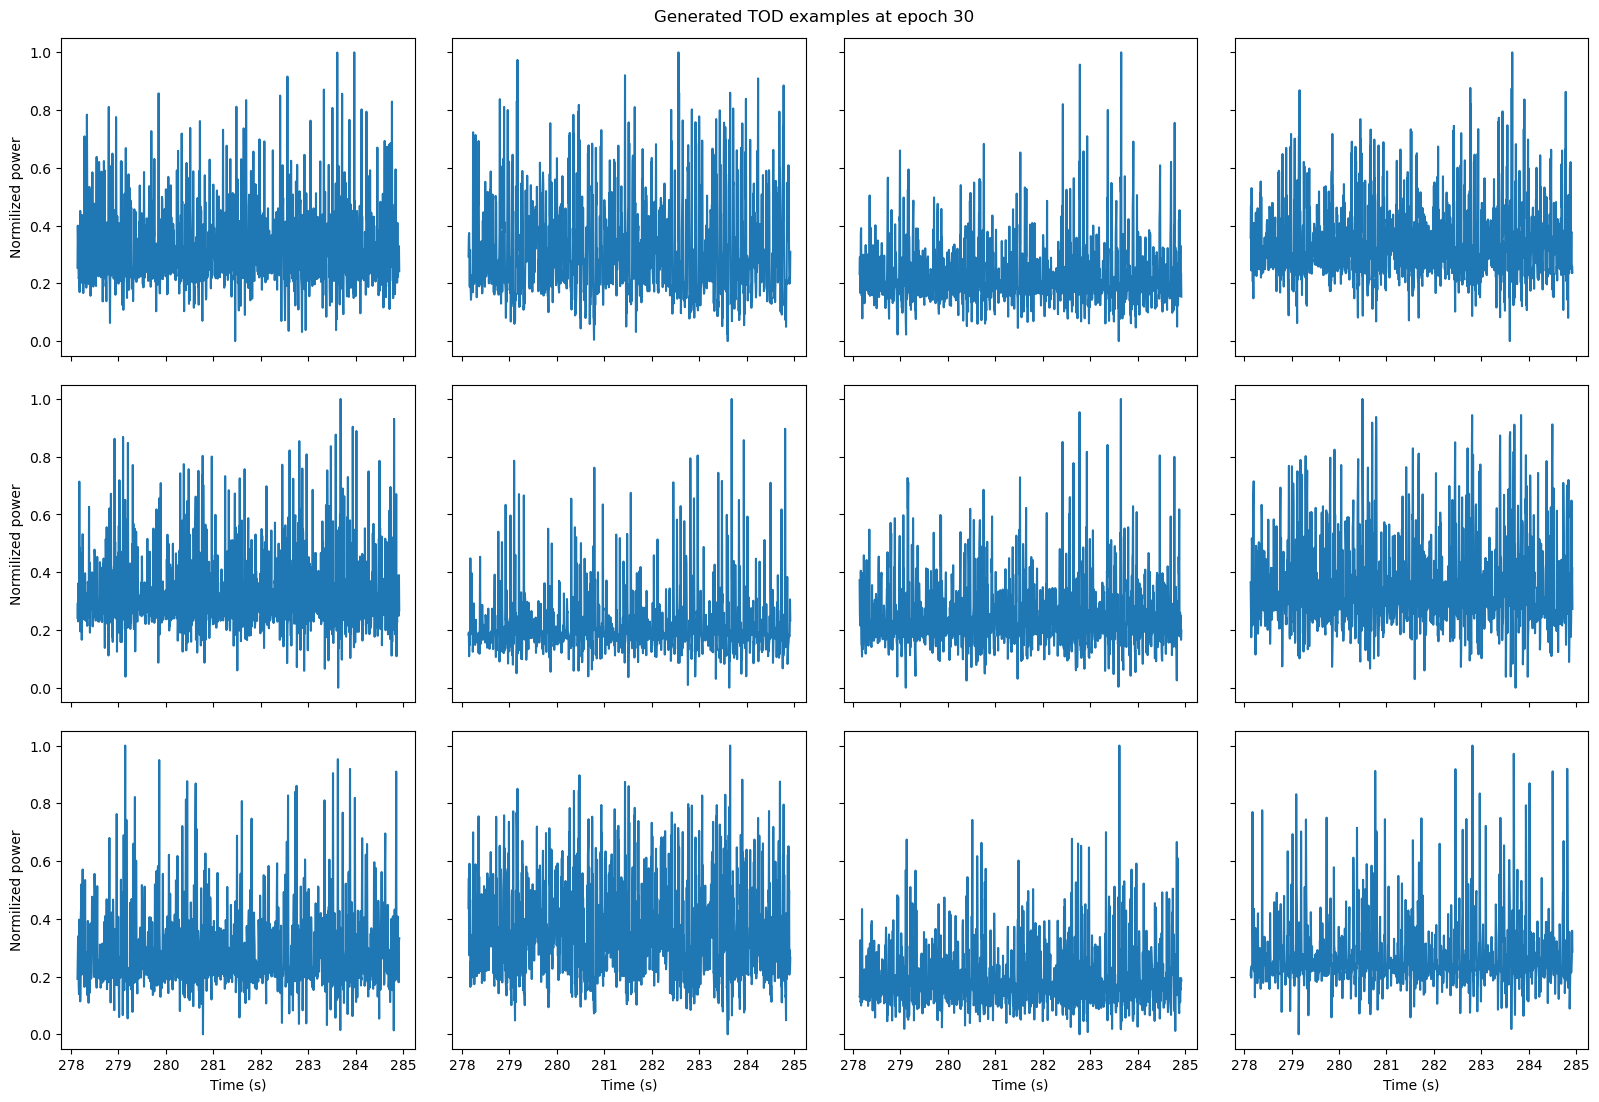

23/23 [==============================] - 0s 5ms/step


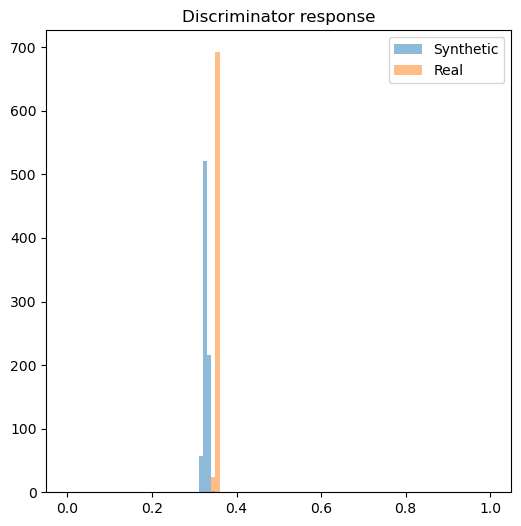

11/11 [==============================] - 8s 759ms/step - gen_loss: 1.1174 - discr_loss: 1.8535 - gen_loss_val: 1.1112 - discr_loss_val: 1.8594 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 31/200
11/11 [==============================] - 6s 585ms/step - gen_loss: 1.2403 - discr_loss: 1.6068 - gen_loss_val: 1.2073 - discr_loss_val: 1.6112 - gen_acc: 0.0000e+00 - discr_acc: 0.5886
Epoch 32/200
11/11 [==============================] - 6s 584ms/step - gen_loss: 4.9251 - discr_loss: 4.8818 - gen_loss_val: 4.6546 - discr_loss_val: 4.9271 - gen_acc: 0.2727 - discr_acc: 0.6364
Epoch 33/200
11/11 [==============================] - 6s 590ms/step - gen_loss: 1.0935 - discr_loss: 1.9261 - gen_loss_val: 1.0915 - discr_loss_val: 1.9244 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 34/200
11/11 [==============================] - 7s 597ms/step - gen_loss: 1.1016 - discr_loss: 1.9035 - gen_loss_val: 1.0991 - discr_loss_val: 1.9060 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 35/200
11/11 [=======

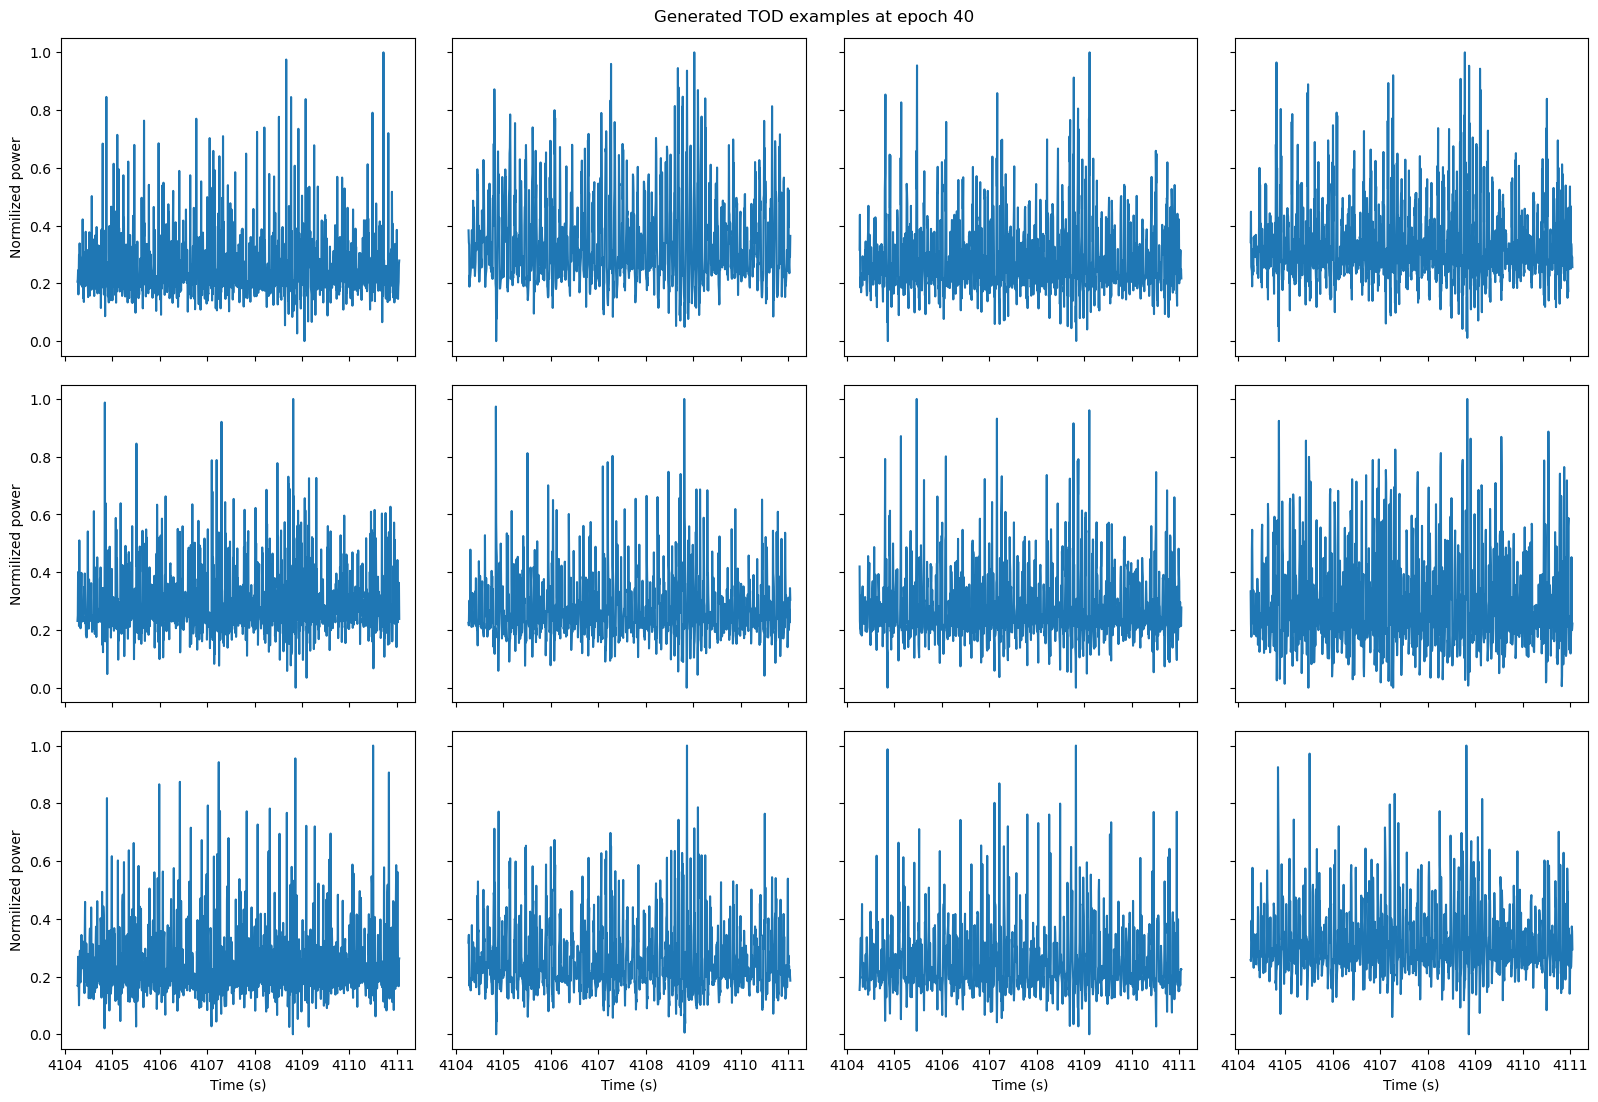

23/23 [==============================] - 0s 5ms/step


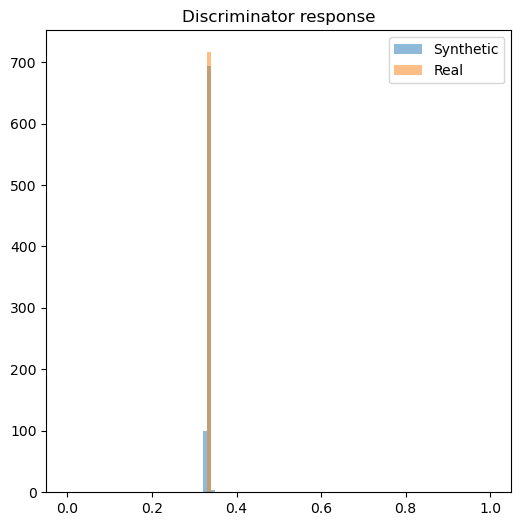

11/11 [==============================] - 8s 781ms/step - gen_loss: 1.1011 - discr_loss: 1.9014 - gen_loss_val: 1.0991 - discr_loss_val: 1.9034 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 41/200
11/11 [==============================] - 7s 606ms/step - gen_loss: 1.1009 - discr_loss: 1.9021 - gen_loss_val: 1.0995 - discr_loss_val: 1.9036 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 42/200
11/11 [==============================] - 6s 584ms/step - gen_loss: 1.1005 - discr_loss: 1.9034 - gen_loss_val: 1.0999 - discr_loss_val: 1.9041 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 43/200
11/11 [==============================] - 7s 595ms/step - gen_loss: 1.1001 - discr_loss: 1.9051 - gen_loss_val: 1.1004 - discr_loss_val: 1.9048 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 44/200
11/11 [==============================] - 6s 588ms/step - gen_loss: 1.0994 - discr_loss: 1.9071 - gen_loss_val: 1.1009 - discr_loss_val: 1.9057 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 45/200
11/11 [===

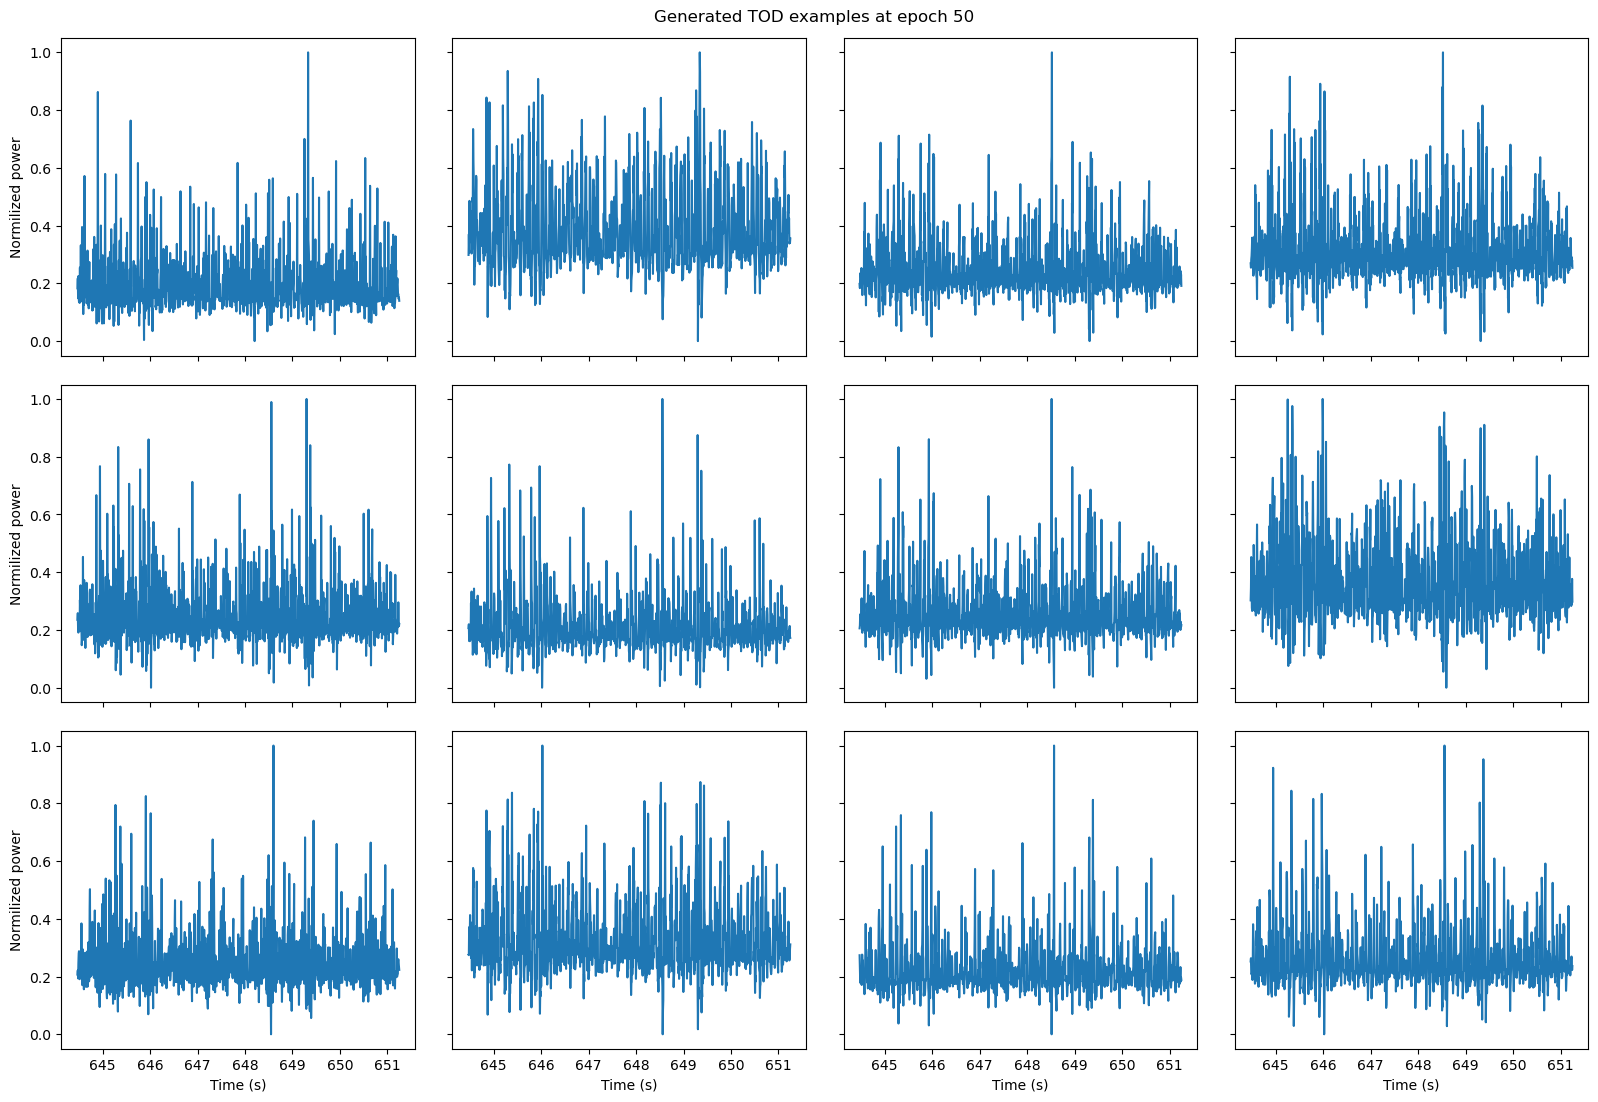

23/23 [==============================] - 0s 6ms/step


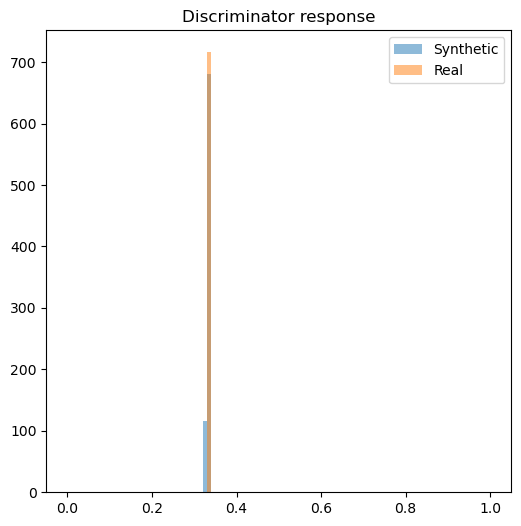

11/11 [==============================] - 9s 822ms/step - gen_loss: 1.0967 - discr_loss: 1.9160 - gen_loss_val: 1.1017 - discr_loss_val: 1.9109 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 51/200
11/11 [==============================] - 7s 594ms/step - gen_loss: 1.0967 - discr_loss: 1.9159 - gen_loss_val: 1.1016 - discr_loss_val: 1.9111 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 52/200
11/11 [==============================] - 7s 594ms/step - gen_loss: 1.0968 - discr_loss: 1.9156 - gen_loss_val: 1.1013 - discr_loss_val: 1.9110 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 53/200
11/11 [==============================] - 7s 611ms/step - gen_loss: 1.0970 - discr_loss: 1.9150 - gen_loss_val: 1.1011 - discr_loss_val: 1.9109 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 54/200
11/11 [==============================] - 7s 597ms/step - gen_loss: 1.0971 - discr_loss: 1.9144 - gen_loss_val: 1.1008 - discr_loss_val: 1.9107 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 55/200
11/11 [===

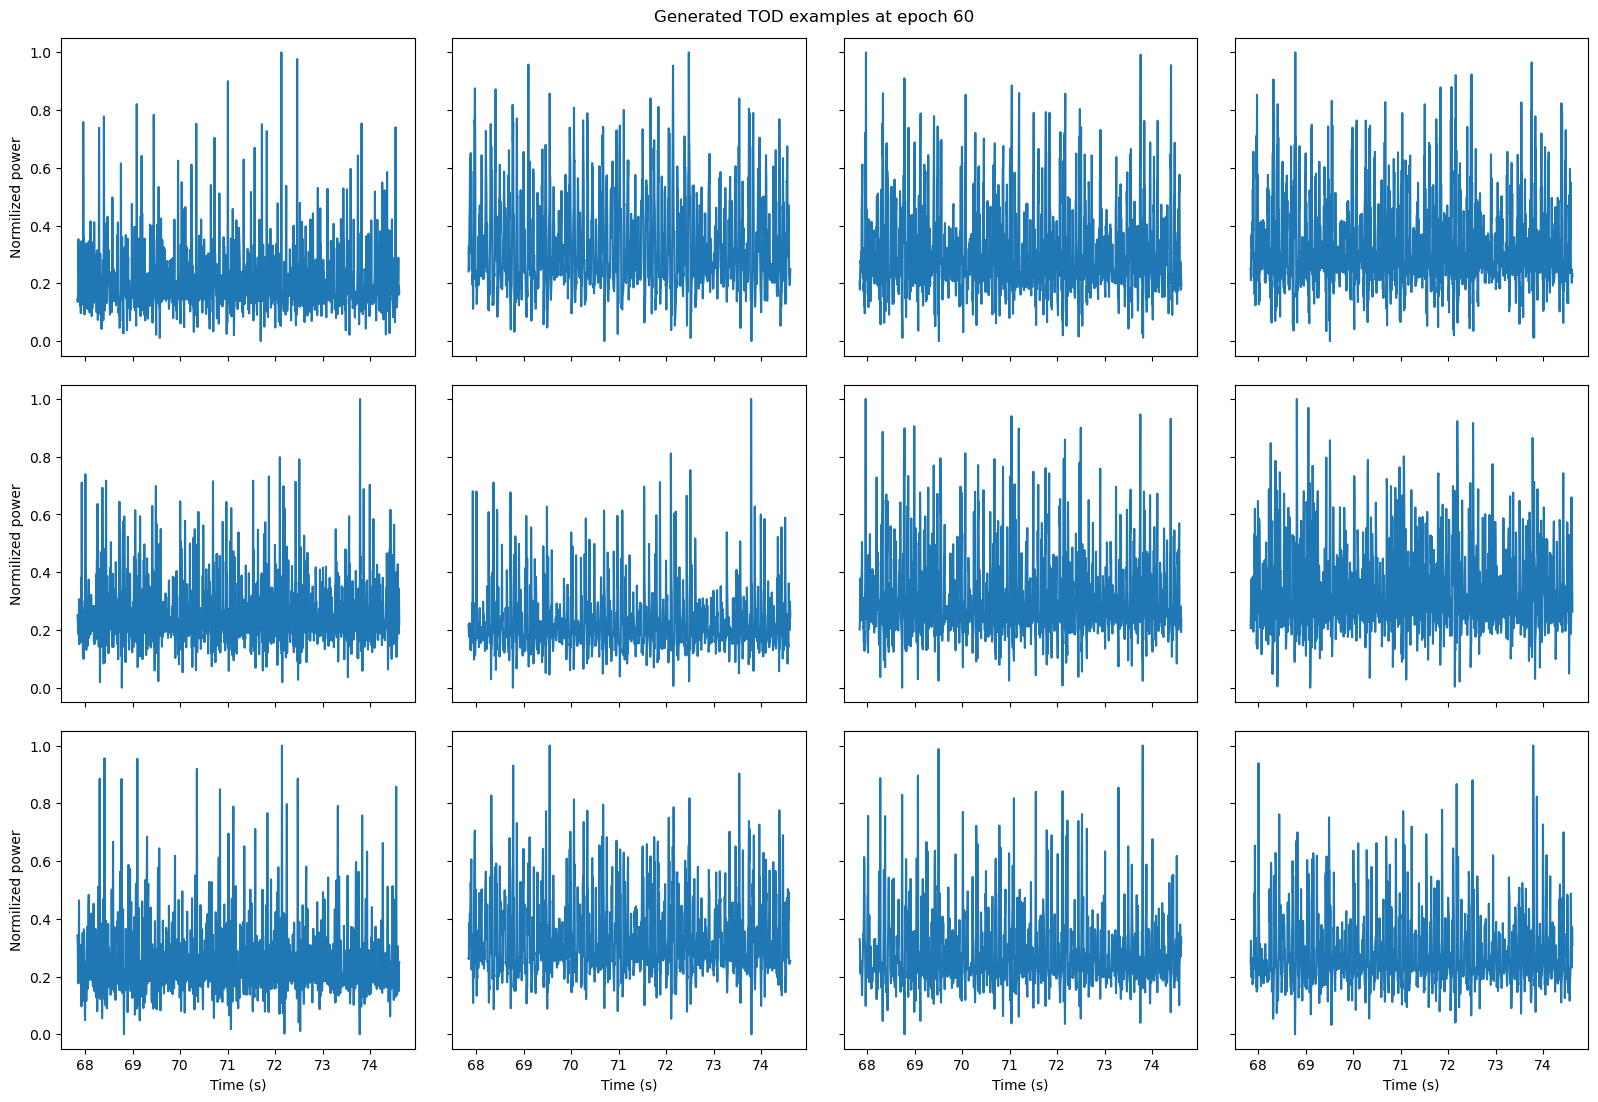

23/23 [==============================] - 0s 7ms/step


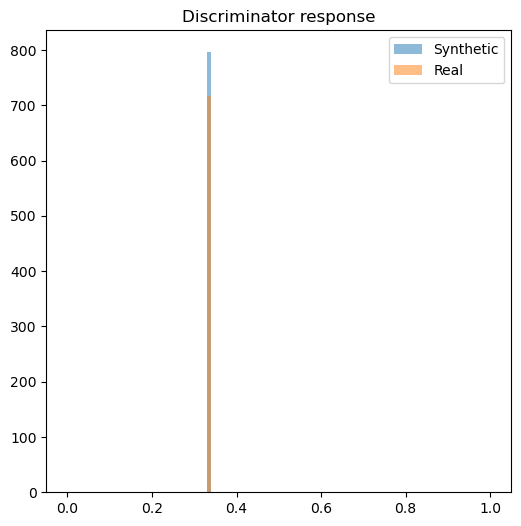

11/11 [==============================] - 9s 808ms/step - gen_loss: 1.0982 - discr_loss: 1.9107 - gen_loss_val: 1.0992 - discr_loss_val: 1.9097 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 61/200
11/11 [==============================] - 7s 641ms/step - gen_loss: 1.0984 - discr_loss: 1.9102 - gen_loss_val: 1.0989 - discr_loss_val: 1.9096 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 62/200
11/11 [==============================] - 7s 602ms/step - gen_loss: 1.0986 - discr_loss: 1.9097 - gen_loss_val: 1.0987 - discr_loss_val: 1.9095 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 63/200
11/11 [==============================] - 7s 593ms/step - gen_loss: 1.0988 - discr_loss: 1.9091 - gen_loss_val: 1.0984 - discr_loss_val: 1.9094 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 64/200
11/11 [==============================] - 7s 618ms/step - gen_loss: 1.0990 - discr_loss: 1.9085 - gen_loss_val: 1.0981 - discr_loss_val: 1.9093 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 65/200
11/11 [===

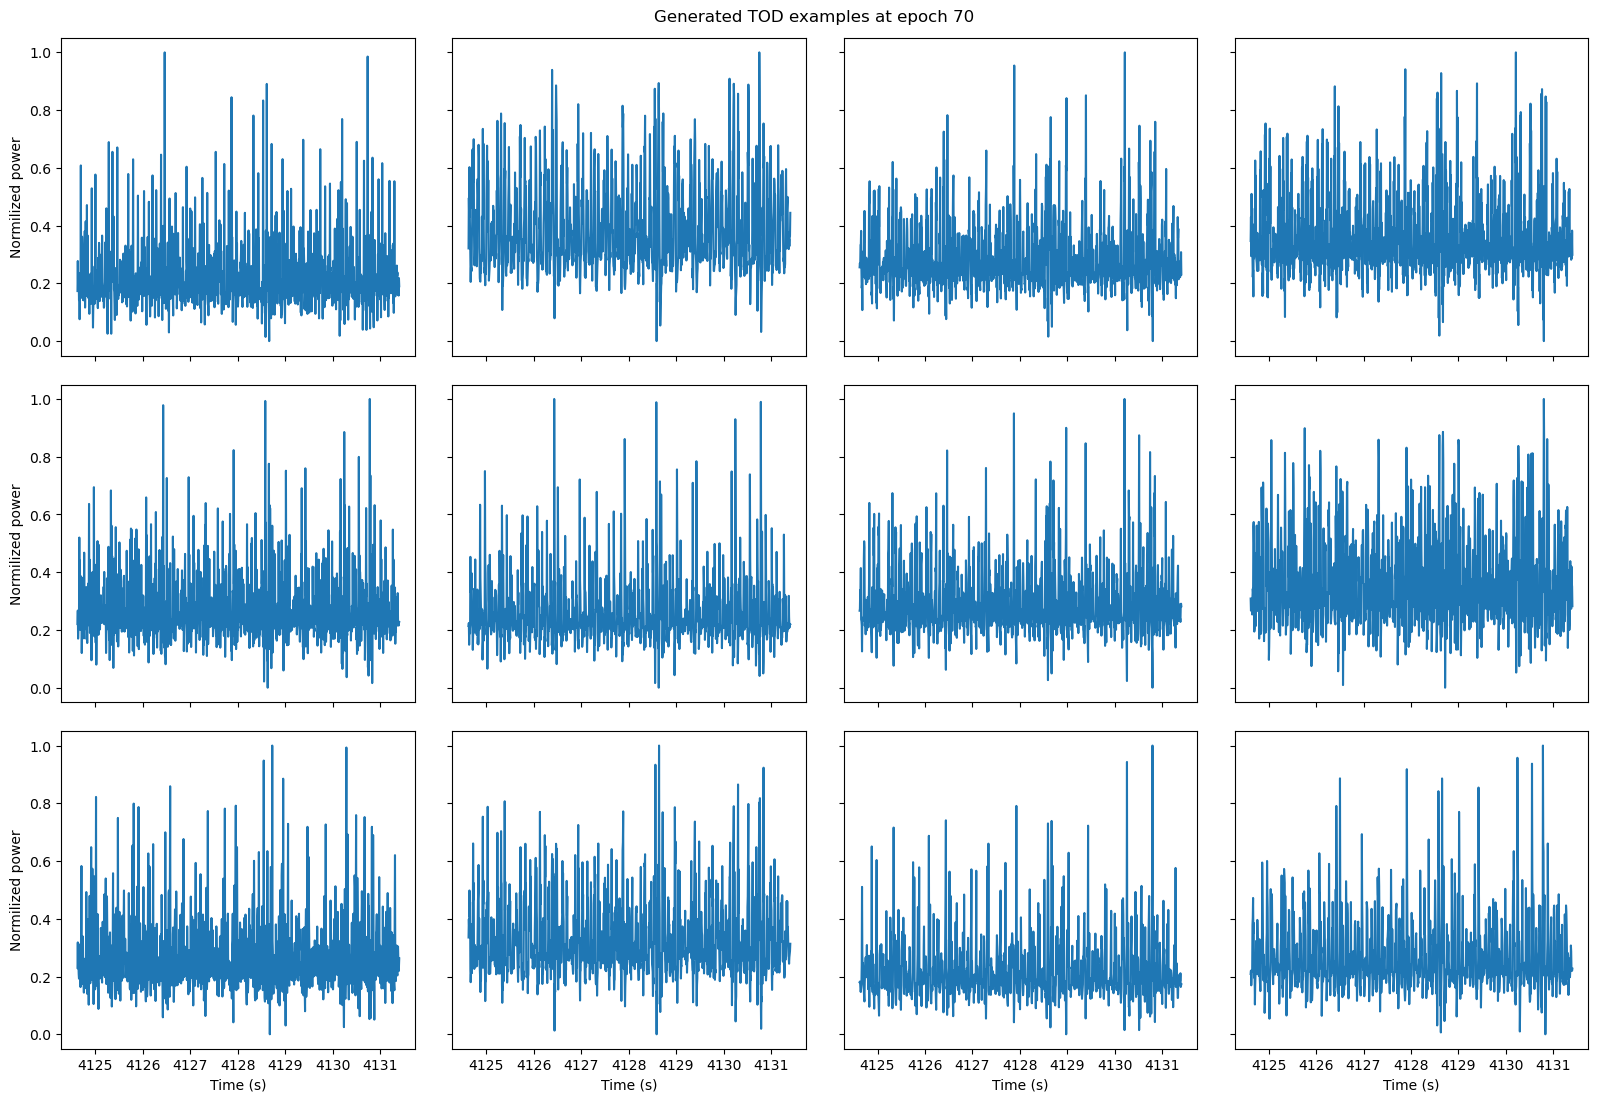

23/23 [==============================] - 0s 5ms/step


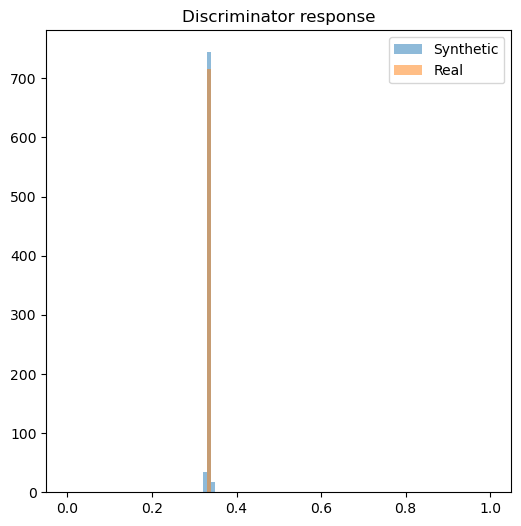

11/11 [==============================] - 8s 780ms/step - gen_loss: 1.1023 - discr_loss: 1.8988 - gen_loss_val: 1.0950 - discr_loss_val: 1.9058 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 71/200
11/11 [==============================] - 7s 614ms/step - gen_loss: 1.1045 - discr_loss: 1.8934 - gen_loss_val: 1.0942 - discr_loss_val: 1.9034 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 72/200
11/11 [==============================] - 7s 615ms/step - gen_loss: 1.1078 - discr_loss: 1.8848 - gen_loss_val: 1.0927 - discr_loss_val: 1.8992 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 73/200
11/11 [==============================] - 7s 603ms/step - gen_loss: 1.1117 - discr_loss: 1.8858 - gen_loss_val: 1.0900 - discr_loss_val: 1.8981 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 74/200
11/11 [==============================] - 7s 604ms/step - gen_loss: 1.1133 - discr_loss: 1.8986 - gen_loss_val: 1.0982 - discr_loss_val: 1.9115 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 75/200
11/11 [===

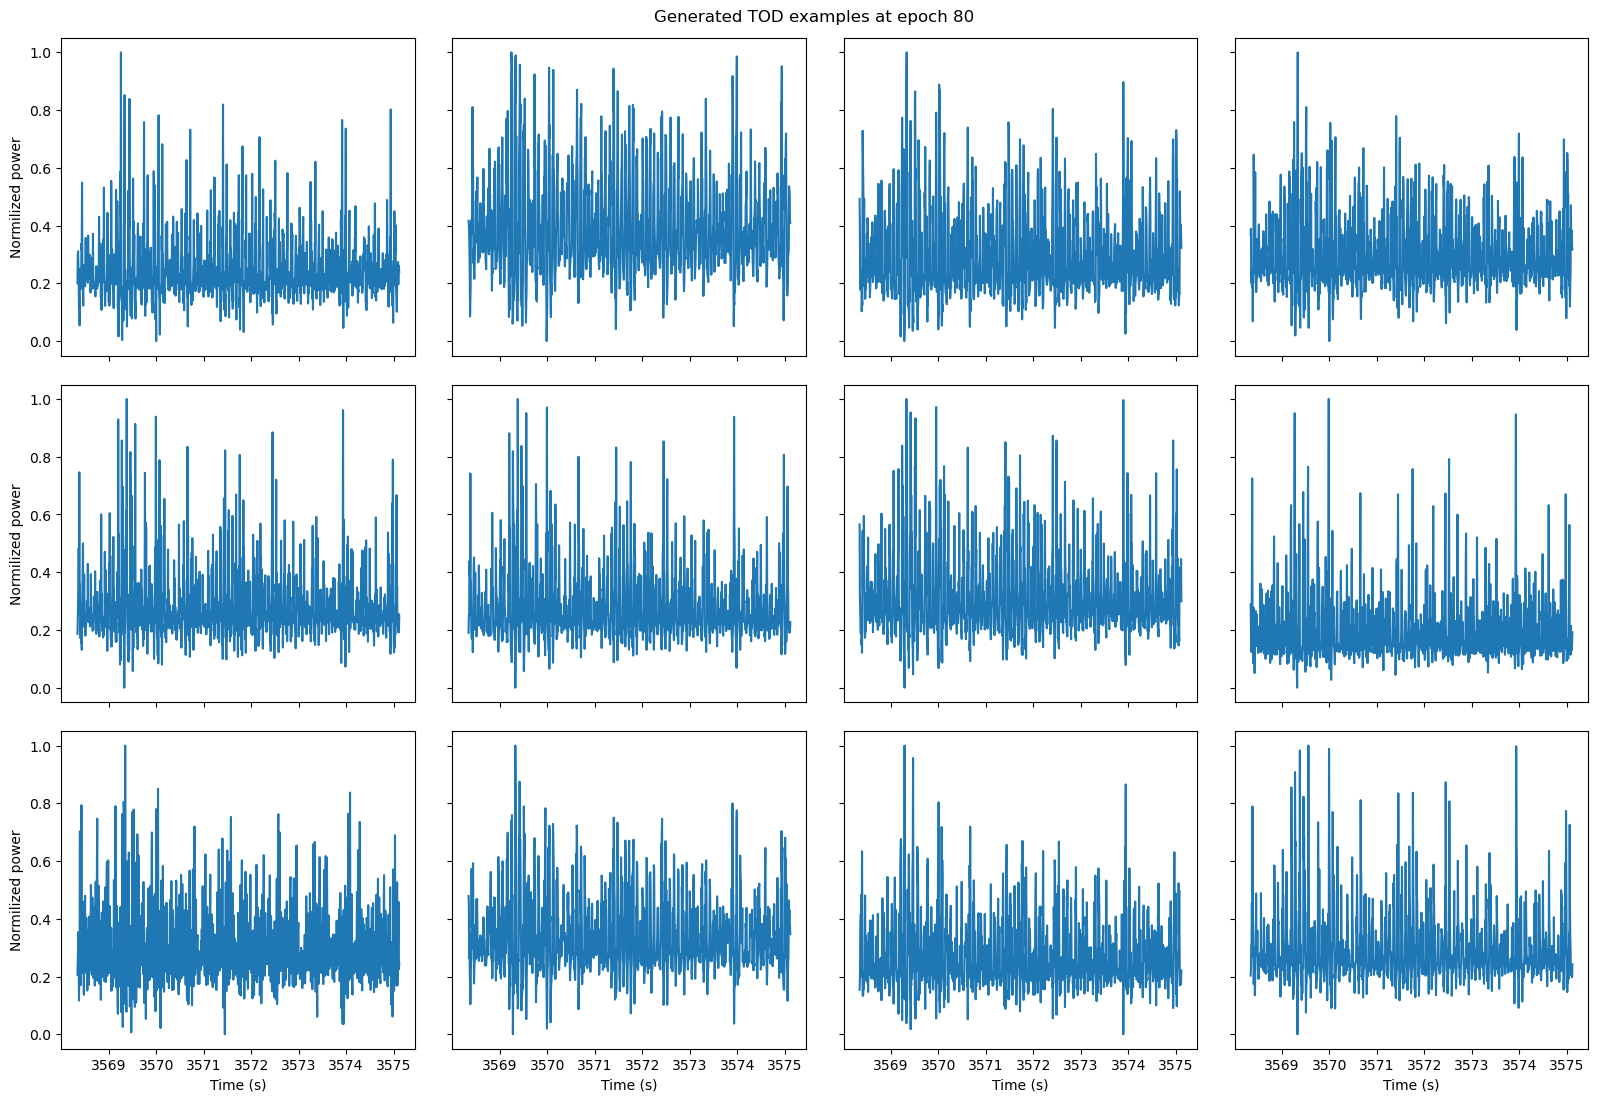

23/23 [==============================] - 0s 6ms/step


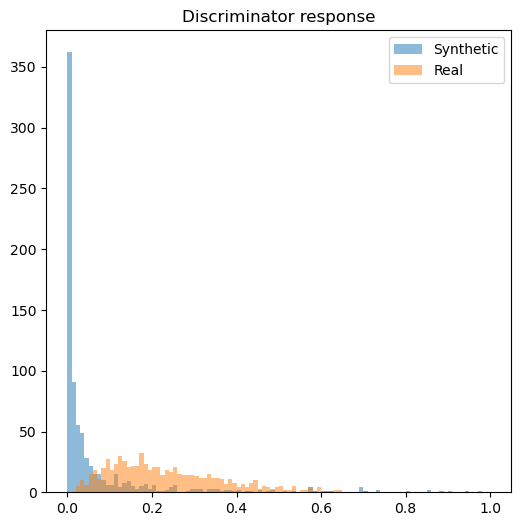

11/11 [==============================] - 9s 841ms/step - gen_loss: 2.5047 - discr_loss: 1.2924 - gen_loss_val: 1.9313 - discr_loss_val: 1.5782 - gen_acc: 0.2375 - discr_acc: 0.6938
Epoch 81/200
11/11 [==============================] - 7s 603ms/step - gen_loss: 7.9793 - discr_loss: 0.6240 - gen_loss_val: 6.9241 - discr_loss_val: 0.2080 - gen_acc: 0.0193 - discr_acc: 0.9864
Epoch 82/200
11/11 [==============================] - 7s 597ms/step - gen_loss: 1.4315 - discr_loss: 2.1307 - gen_loss_val: 1.6202 - discr_loss_val: 1.6262 - gen_acc: 0.0477 - discr_acc: 0.6102
Epoch 83/200
11/11 [==============================] - 7s 597ms/step - gen_loss: 3.8901 - discr_loss: 0.6356 - gen_loss_val: 4.3808 - discr_loss_val: 0.6650 - gen_acc: 0.0523 - discr_acc: 0.9136
Epoch 84/200
11/11 [==============================] - 7s 600ms/step - gen_loss: 4.2084 - discr_loss: 0.6861 - gen_loss_val: 3.1245 - discr_loss_val: 0.8347 - gen_acc: 0.1432 - discr_acc: 0.8619
Epoch 85/200
11/11 [=======================

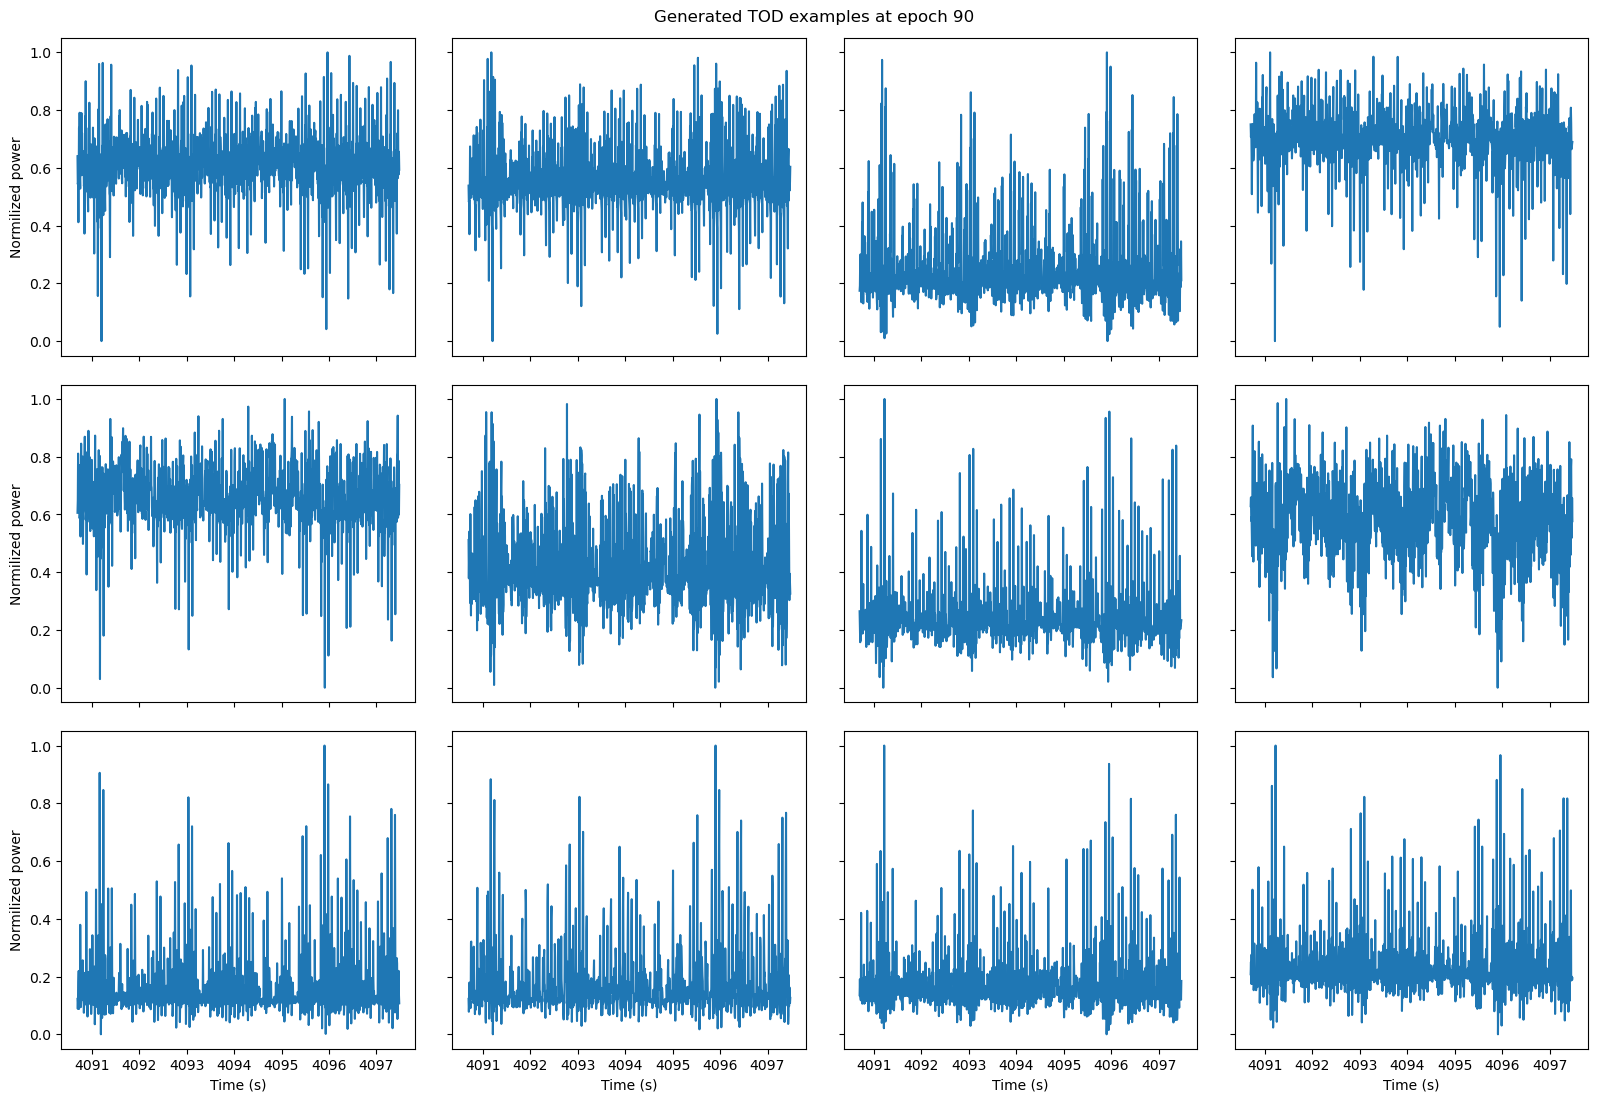

23/23 [==============================] - 0s 5ms/step


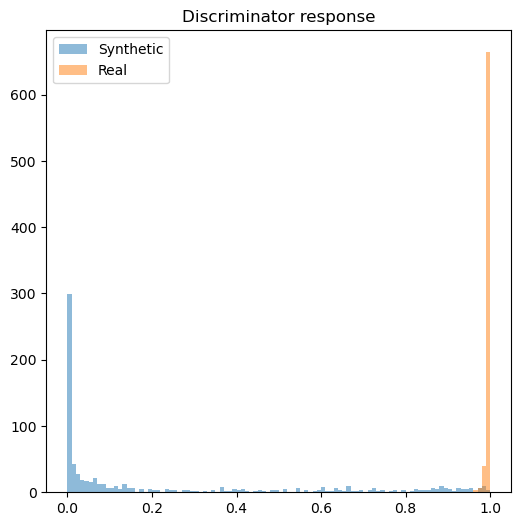

11/11 [==============================] - 8s 768ms/step - gen_loss: 7.2274 - discr_loss: 0.0267 - gen_loss_val: 4.2052 - discr_loss_val: 0.2848 - gen_acc: 0.0364 - discr_acc: 0.9818
Epoch 91/200
11/11 [==============================] - 7s 592ms/step - gen_loss: 16.2898 - discr_loss: 0.0171 - gen_loss_val: 12.1344 - discr_loss_val: 1.0077 - gen_acc: 0.0909 - discr_acc: 0.9085
Epoch 92/200
11/11 [==============================] - 6s 581ms/step - gen_loss: 10.8229 - discr_loss: 0.2495 - gen_loss_val: 9.6776 - discr_loss_val: 0.4511 - gen_acc: 0.1000 - discr_acc: 0.9364
Epoch 93/200
11/11 [==============================] - 7s 590ms/step - gen_loss: 2.9187 - discr_loss: 1.5812 - gen_loss_val: 2.3187 - discr_loss_val: 1.3853 - gen_acc: 0.2125 - discr_acc: 0.7733
Epoch 94/200
11/11 [==============================] - 6s 587ms/step - gen_loss: 7.0731 - discr_loss: 0.0644 - gen_loss_val: 8.0412 - discr_loss_val: 0.0376 - gen_acc: 0.0000e+00 - discr_acc: 1.0000
Epoch 95/200
11/11 [================

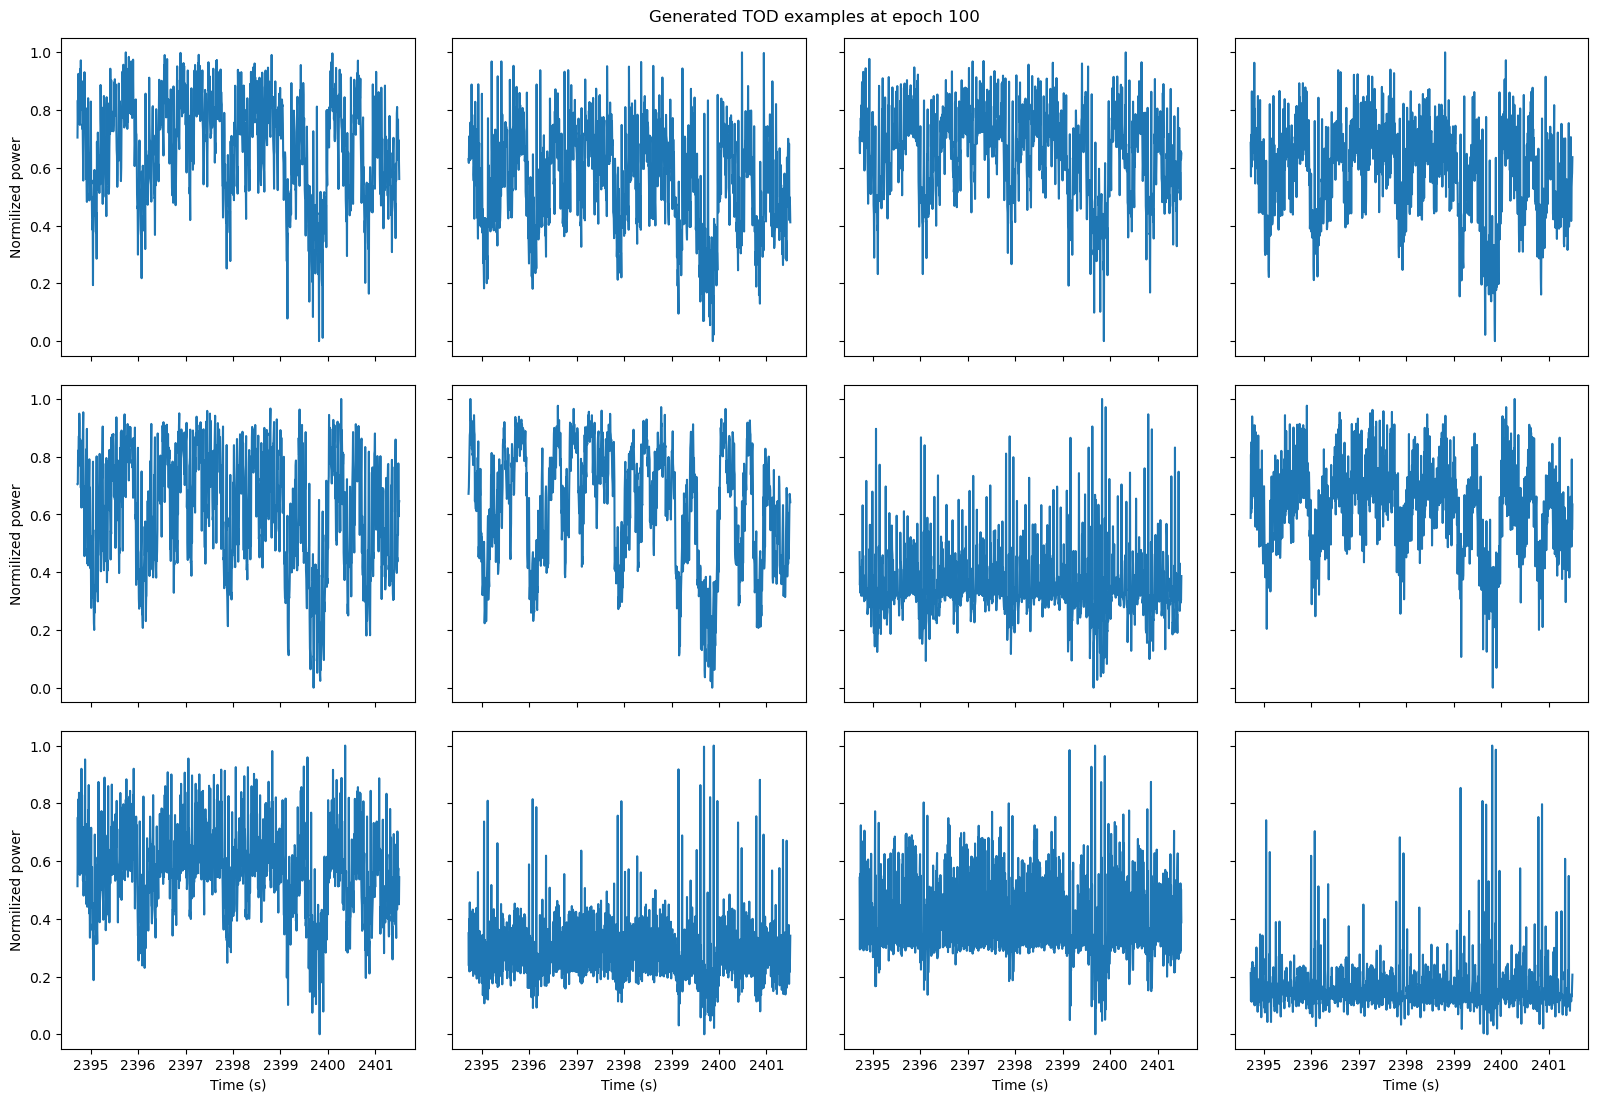

23/23 [==============================] - 0s 5ms/step


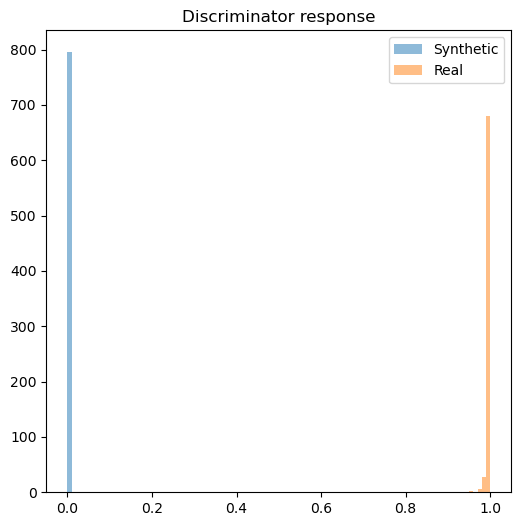

11/11 [==============================] - 8s 768ms/step - gen_loss: 3.3584 - discr_loss: 0.5611 - gen_loss_val: 3.9127 - discr_loss_val: 0.4947 - gen_acc: 0.0000e+00 - discr_acc: 0.9142
Epoch 101/200
11/11 [==============================] - 7s 598ms/step - gen_loss: 4.1414 - discr_loss: 0.0526 - gen_loss_val: 4.5813 - discr_loss_val: 0.1339 - gen_acc: 0.0068 - discr_acc: 0.9937
Epoch 102/200
11/11 [==============================] - 6s 590ms/step - gen_loss: 7.4190 - discr_loss: 0.8384 - gen_loss_val: 5.7940 - discr_loss_val: 1.3942 - gen_acc: 0.2205 - discr_acc: 0.8886
Epoch 103/200
11/11 [==============================] - 7s 594ms/step - gen_loss: 5.1492 - discr_loss: 0.2971 - gen_loss_val: 2.9713 - discr_loss_val: 1.5522 - gen_acc: 0.2795 - discr_acc: 0.8108
Epoch 104/200
11/11 [==============================] - 6s 590ms/step - gen_loss: 5.4982 - discr_loss: 0.1261 - gen_loss_val: 5.8229 - discr_loss_val: 0.1166 - gen_acc: 0.0011 - discr_acc: 0.9955
Epoch 105/200
11/11 [==============

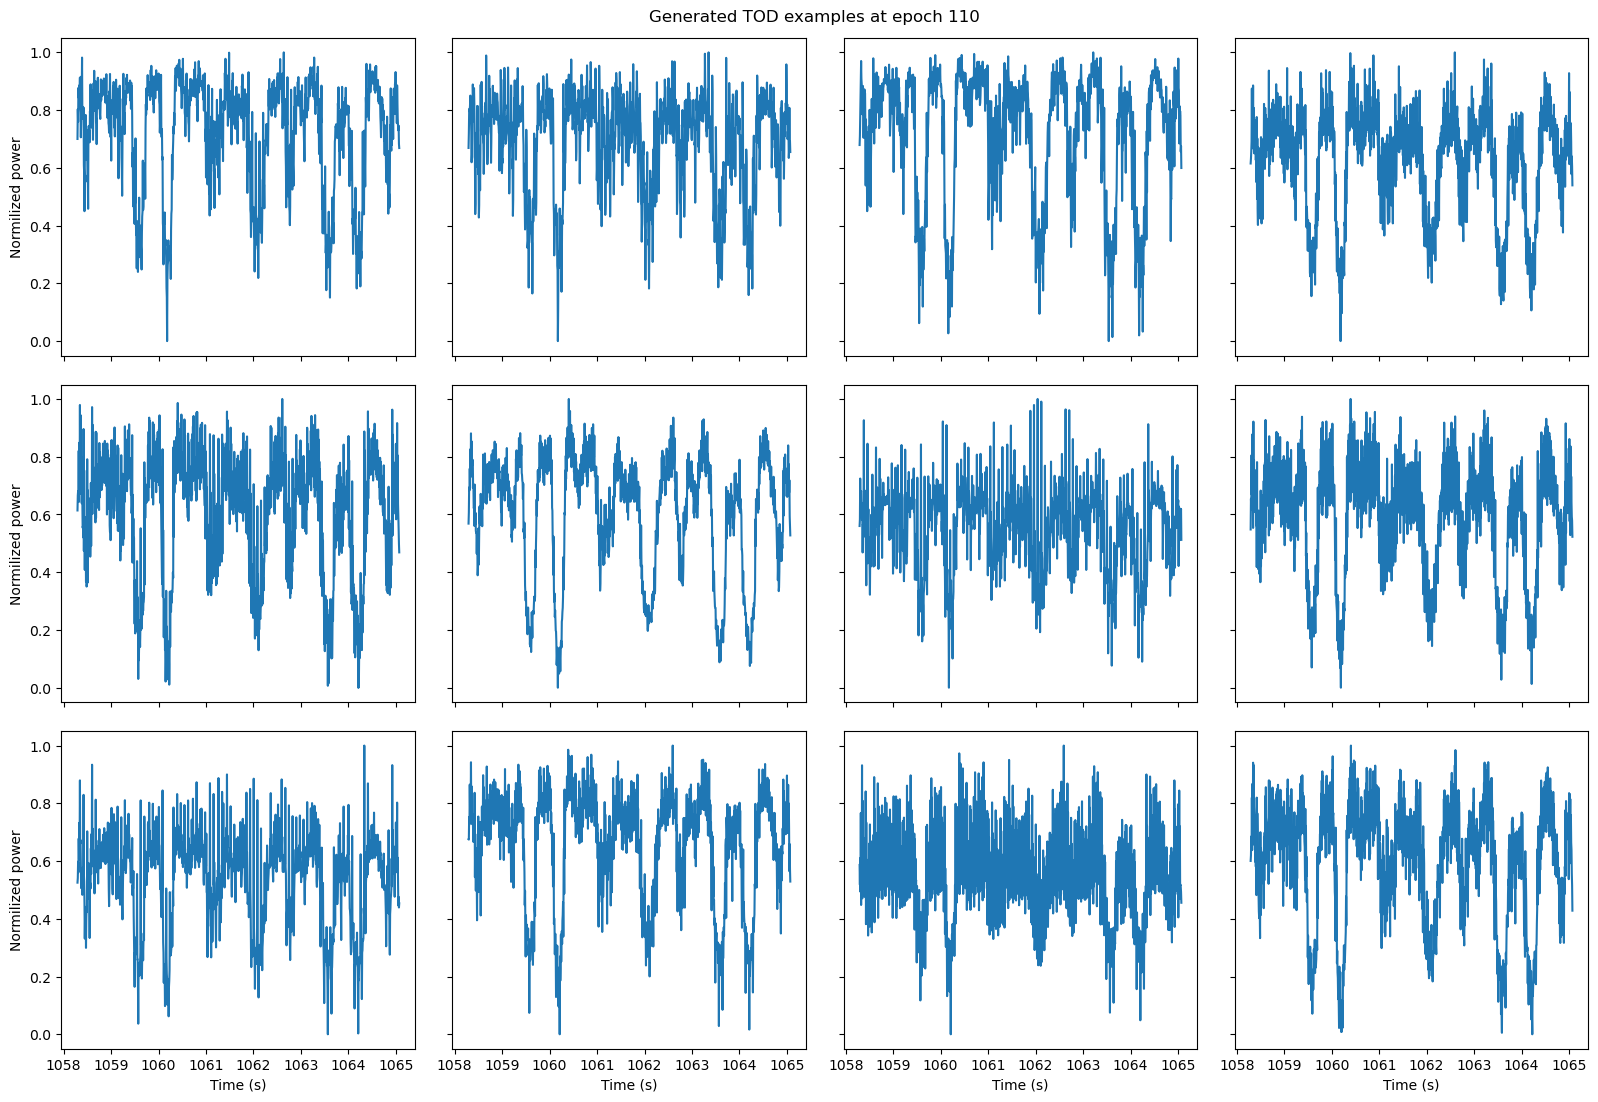

23/23 [==============================] - 0s 5ms/step


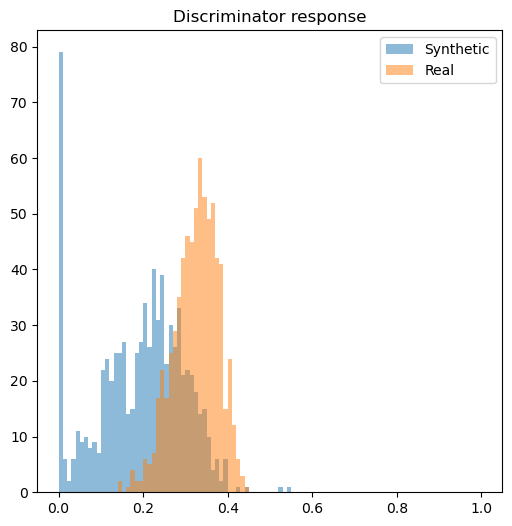

11/11 [==============================] - 8s 765ms/step - gen_loss: 2.3574 - discr_loss: 1.9685 - gen_loss_val: 3.8053 - discr_loss_val: 1.4172 - gen_acc: 0.0102 - discr_acc: 0.6307
Epoch 111/200
11/11 [==============================] - 6s 581ms/step - gen_loss: 1.2552 - discr_loss: 1.7923 - gen_loss_val: 3.1480 - discr_loss_val: 1.3373 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 112/200
11/11 [==============================] - 6s 586ms/step - gen_loss: 2.5212 - discr_loss: 1.1784 - gen_loss_val: 12.6006 - discr_loss_val: 0.5998 - gen_acc: 0.0000e+00 - discr_acc: 0.8125
Epoch 113/200
11/11 [==============================] - 6s 577ms/step - gen_loss: 3.4769 - discr_loss: 0.6377 - gen_loss_val: 33.0540 - discr_loss_val: 1.3728 - gen_acc: 0.0375 - discr_acc: 0.9585
Epoch 114/200
11/11 [==============================] - 7s 597ms/step - gen_loss: 3.9804 - discr_loss: 0.2031 - gen_loss_val: 29.8571 - discr_loss_val: 10.6692 - gen_acc: 0.2420 - discr_acc: 0.8693
Epoch 115/200
11/11 [======

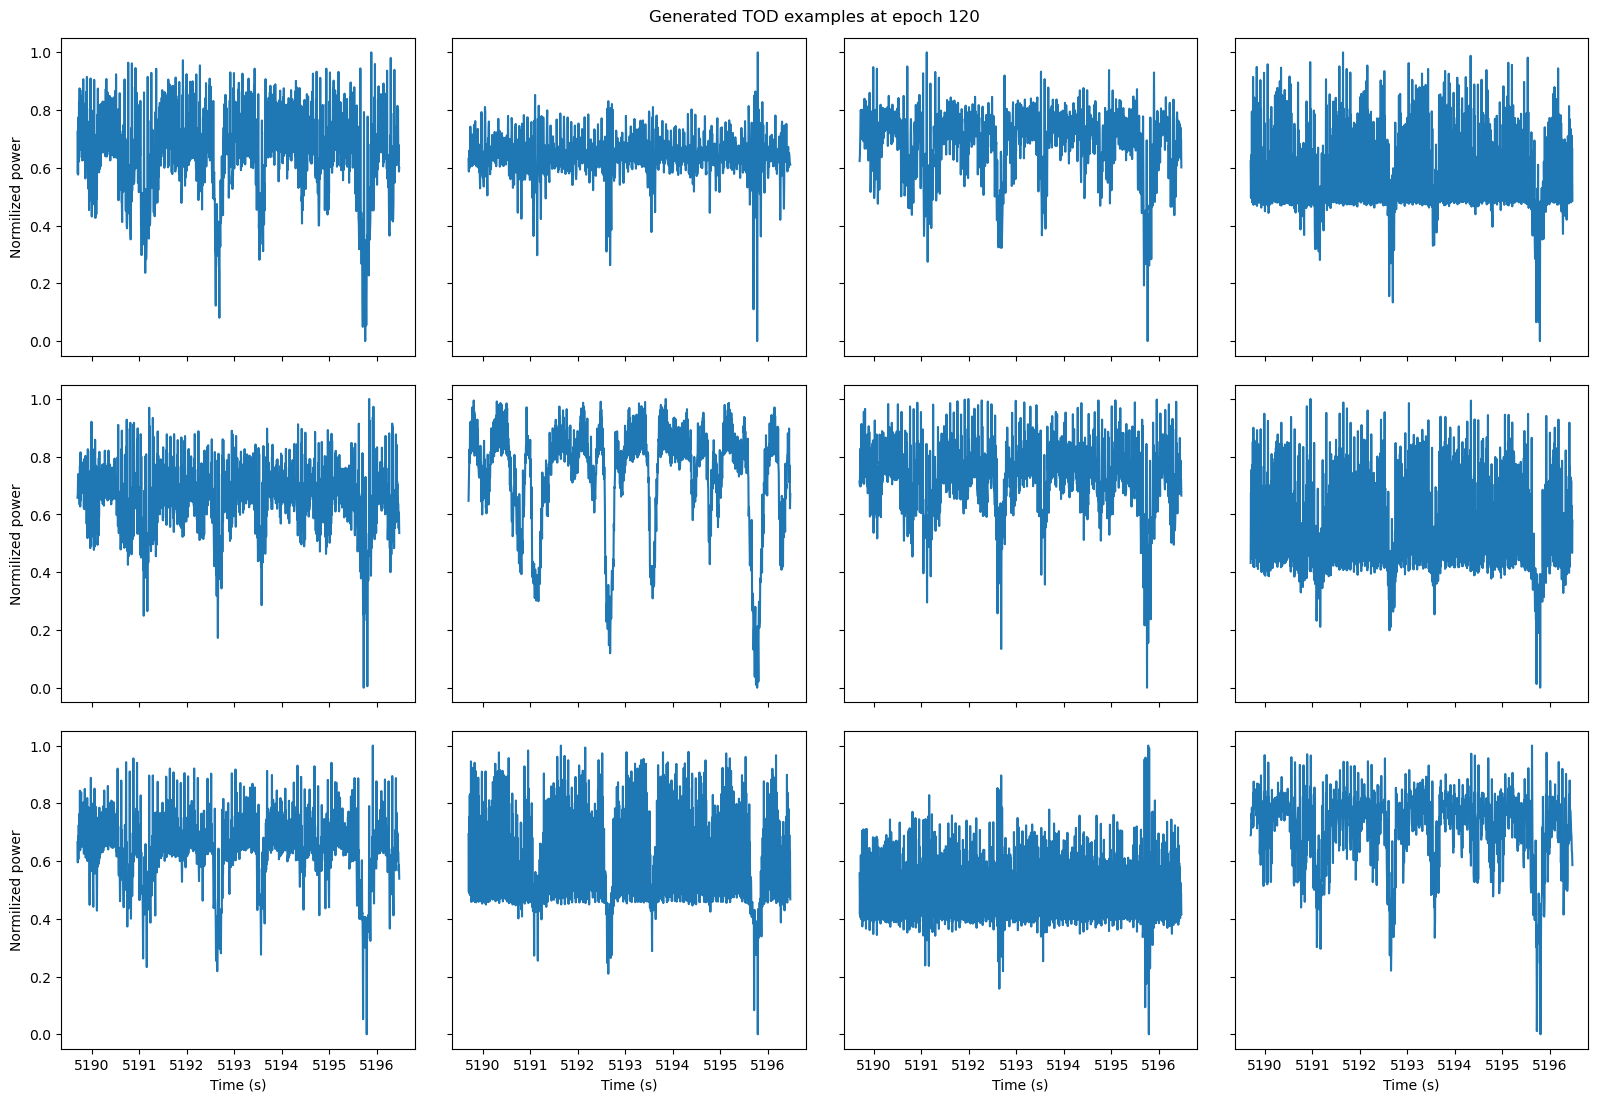

23/23 [==============================] - 0s 5ms/step


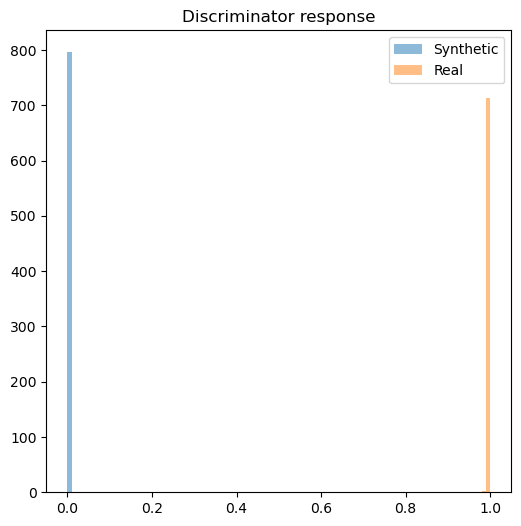

11/11 [==============================] - 9s 816ms/step - gen_loss: 2.6749 - discr_loss: 0.8728 - gen_loss_val: 7.0897 - discr_loss_val: 0.6341 - gen_acc: 0.0000e+00 - discr_acc: 0.8125
Epoch 121/200
11/11 [==============================] - 7s 589ms/step - gen_loss: 3.3179 - discr_loss: 2.9568 - gen_loss_val: 7.9600 - discr_loss_val: 2.2965 - gen_acc: 0.0045 - discr_acc: 0.6341
Epoch 122/200
11/11 [==============================] - 7s 594ms/step - gen_loss: 1.3247 - discr_loss: 1.5114 - gen_loss_val: 1.1204 - discr_loss_val: 1.7476 - gen_acc: 0.0557 - discr_acc: 0.5830
Epoch 123/200
11/11 [==============================] - 6s 583ms/step - gen_loss: 5.7541 - discr_loss: 2.4293 - gen_loss_val: 2.1186 - discr_loss_val: 2.7353 - gen_acc: 0.1511 - discr_acc: 0.6000
Epoch 124/200
11/11 [==============================] - 6s 590ms/step - gen_loss: 1.1386 - discr_loss: 1.9106 - gen_loss_val: 1.1647 - discr_loss_val: 1.9001 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 125/200
11/11 [==========

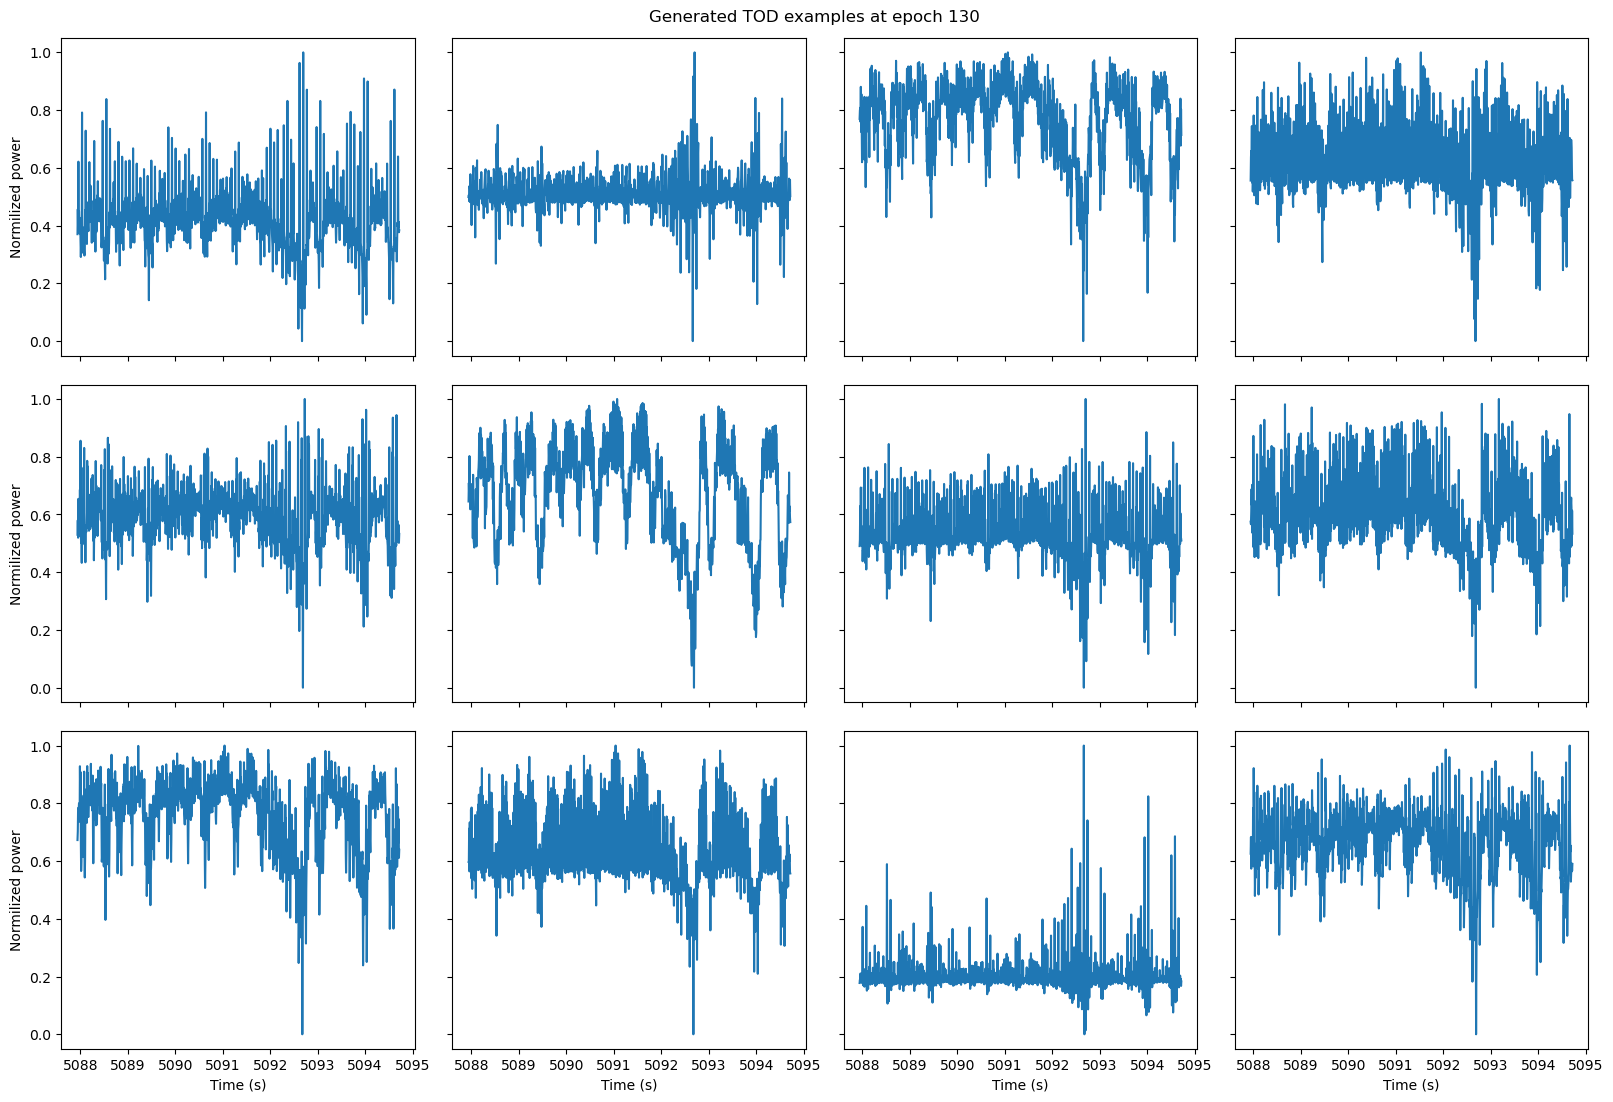

23/23 [==============================] - 0s 5ms/step


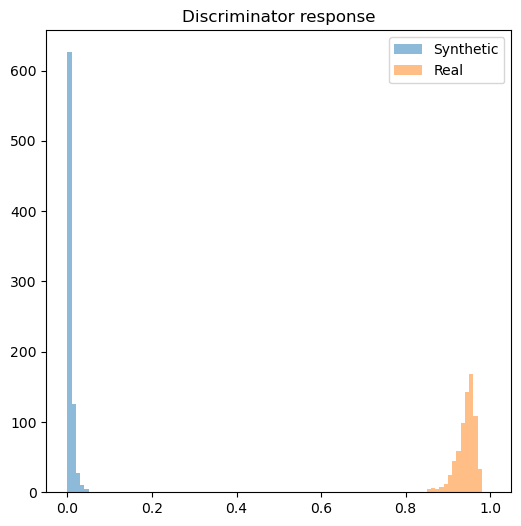

11/11 [==============================] - 8s 786ms/step - gen_loss: 1.9985 - discr_loss: 1.1028 - gen_loss_val: 2.6460 - discr_loss_val: 0.9151 - gen_acc: 0.0000e+00 - discr_acc: 0.8449
Epoch 131/200
11/11 [==============================] - 6s 582ms/step - gen_loss: 5.4602 - discr_loss: 0.0314 - gen_loss_val: 8.7015 - discr_loss_val: 0.0139 - gen_acc: 0.0000e+00 - discr_acc: 1.0000
Epoch 132/200
11/11 [==============================] - 7s 598ms/step - gen_loss: 6.3554 - discr_loss: 4.5377 - gen_loss_val: 7.2789 - discr_loss_val: 1.8886 - gen_acc: 0.0852 - discr_acc: 0.7864
Epoch 133/200
11/11 [==============================] - 7s 598ms/step - gen_loss: 3.8917 - discr_loss: 0.3824 - gen_loss_val: 1.5728 - discr_loss_val: 1.0034 - gen_acc: 0.1500 - discr_acc: 0.8795
Epoch 134/200
11/11 [==============================] - 6s 587ms/step - gen_loss: 3.1940 - discr_loss: 0.5775 - gen_loss_val: 0.6662 - discr_loss_val: 4.5429 - gen_acc: 0.7420 - discr_acc: 0.6159
Epoch 135/200
11/11 [==========

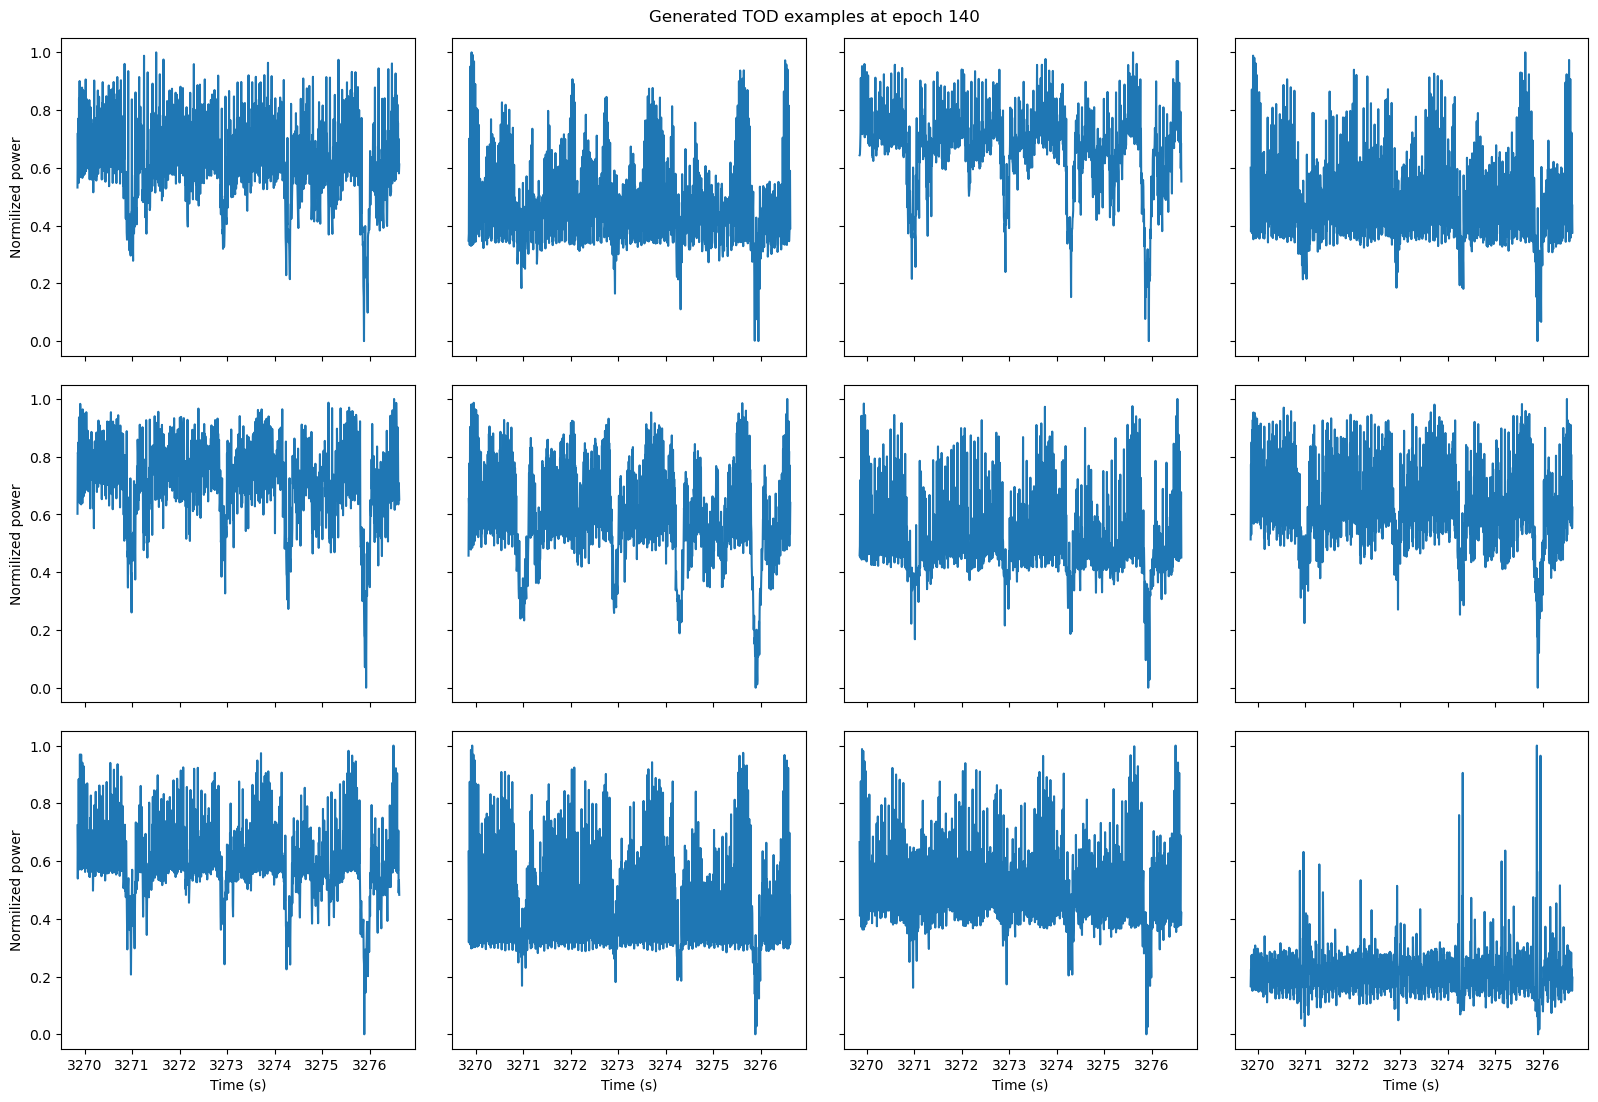

23/23 [==============================] - 0s 5ms/step


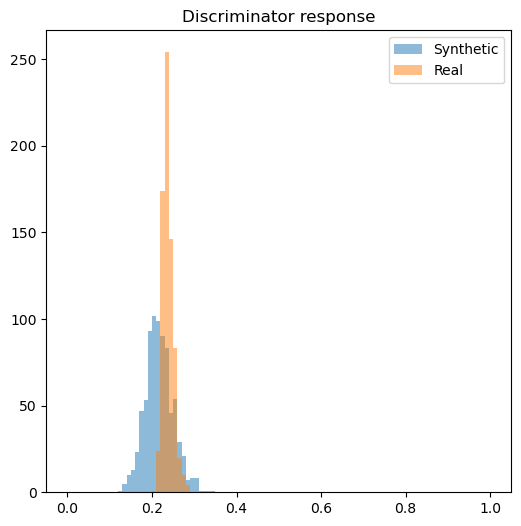

11/11 [==============================] - 8s 745ms/step - gen_loss: 5.9920 - discr_loss: 7.6018 - gen_loss_val: 5.7584 - discr_loss_val: 5.3289 - gen_acc: 0.1773 - discr_acc: 0.5835
Epoch 141/200
11/11 [==============================] - 6s 564ms/step - gen_loss: 1.1454 - discr_loss: 1.7487 - gen_loss_val: 0.8930 - discr_loss_val: 2.1689 - gen_acc: 0.2239 - discr_acc: 0.3966
Epoch 142/200
11/11 [==============================] - 6s 568ms/step - gen_loss: 1.2072 - discr_loss: 1.5873 - gen_loss_val: 0.5196 - discr_loss_val: 3.2621 - gen_acc: 0.6955 - discr_acc: 0.2210
Epoch 143/200
11/11 [==============================] - 6s 561ms/step - gen_loss: 1.9285 - discr_loss: 1.0567 - gen_loss_val: 0.2067 - discr_loss_val: 8.0408 - gen_acc: 0.9284 - discr_acc: 0.2790
Epoch 144/200
11/11 [==============================] - 6s 555ms/step - gen_loss: 1.8281 - discr_loss: 1.8851 - gen_loss_val: 0.1232 - discr_loss_val: 12.2787 - gen_acc: 0.9659 - discr_acc: 0.1449
Epoch 145/200
11/11 [=================

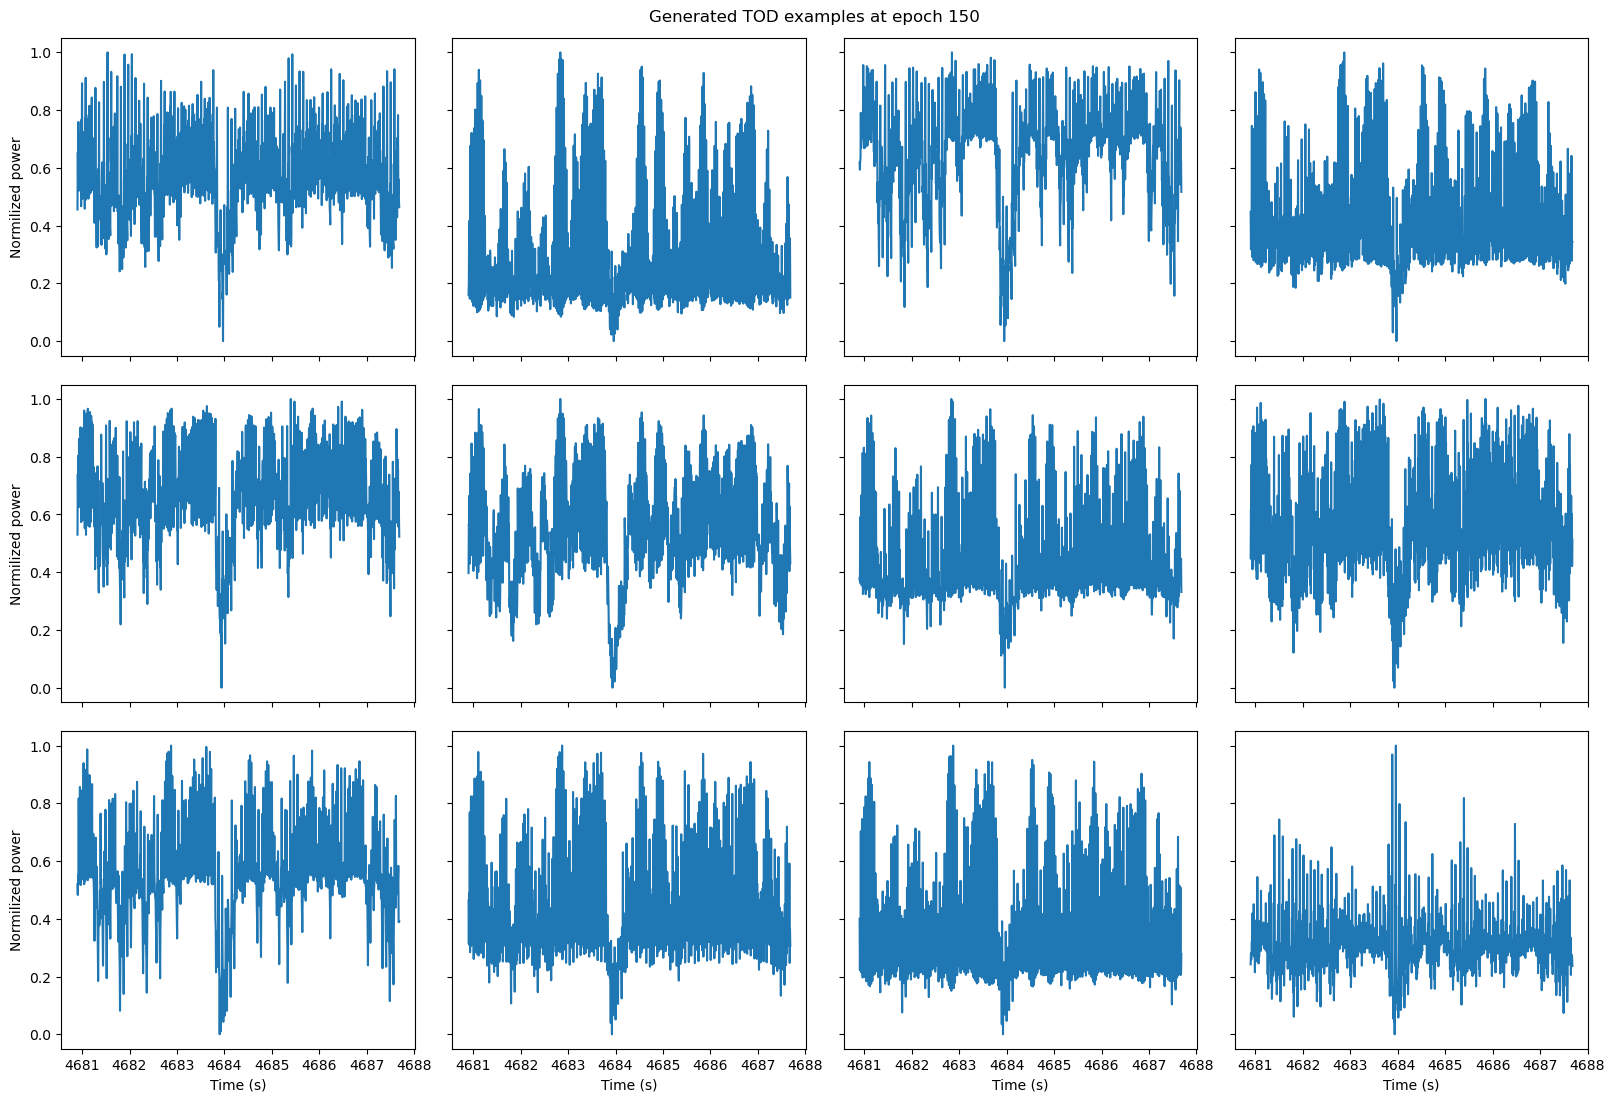

23/23 [==============================] - 0s 5ms/step


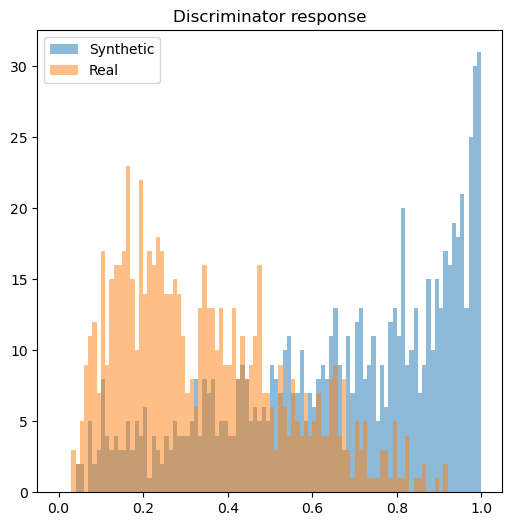

11/11 [==============================] - 9s 825ms/step - gen_loss: 3.1791 - discr_loss: 1.4019 - gen_loss_val: 0.7766 - discr_loss_val: 12.1018 - gen_acc: 0.6932 - discr_acc: 0.3670
Epoch 151/200
11/11 [==============================] - 6s 590ms/step - gen_loss: 1.0416 - discr_loss: 2.2187 - gen_loss_val: 0.7792 - discr_loss_val: 3.0297 - gen_acc: 0.3568 - discr_acc: 0.3375
Epoch 152/200
11/11 [==============================] - 6s 583ms/step - gen_loss: 1.3473 - discr_loss: 1.4640 - gen_loss_val: 1.8604 - discr_loss_val: 1.2407 - gen_acc: 0.0000e+00 - discr_acc: 0.6761
Epoch 153/200
11/11 [==============================] - 7s 595ms/step - gen_loss: 3.0326 - discr_loss: 0.4740 - gen_loss_val: 7.7497 - discr_loss_val: 0.2584 - gen_acc: 0.0011 - discr_acc: 0.9642
Epoch 154/200
11/11 [==============================] - 6s 590ms/step - gen_loss: 2.2935 - discr_loss: 2.2644 - gen_loss_val: 5.8941 - discr_loss_val: 1.5822 - gen_acc: 0.0477 - discr_acc: 0.6886
Epoch 155/200
11/11 [=============

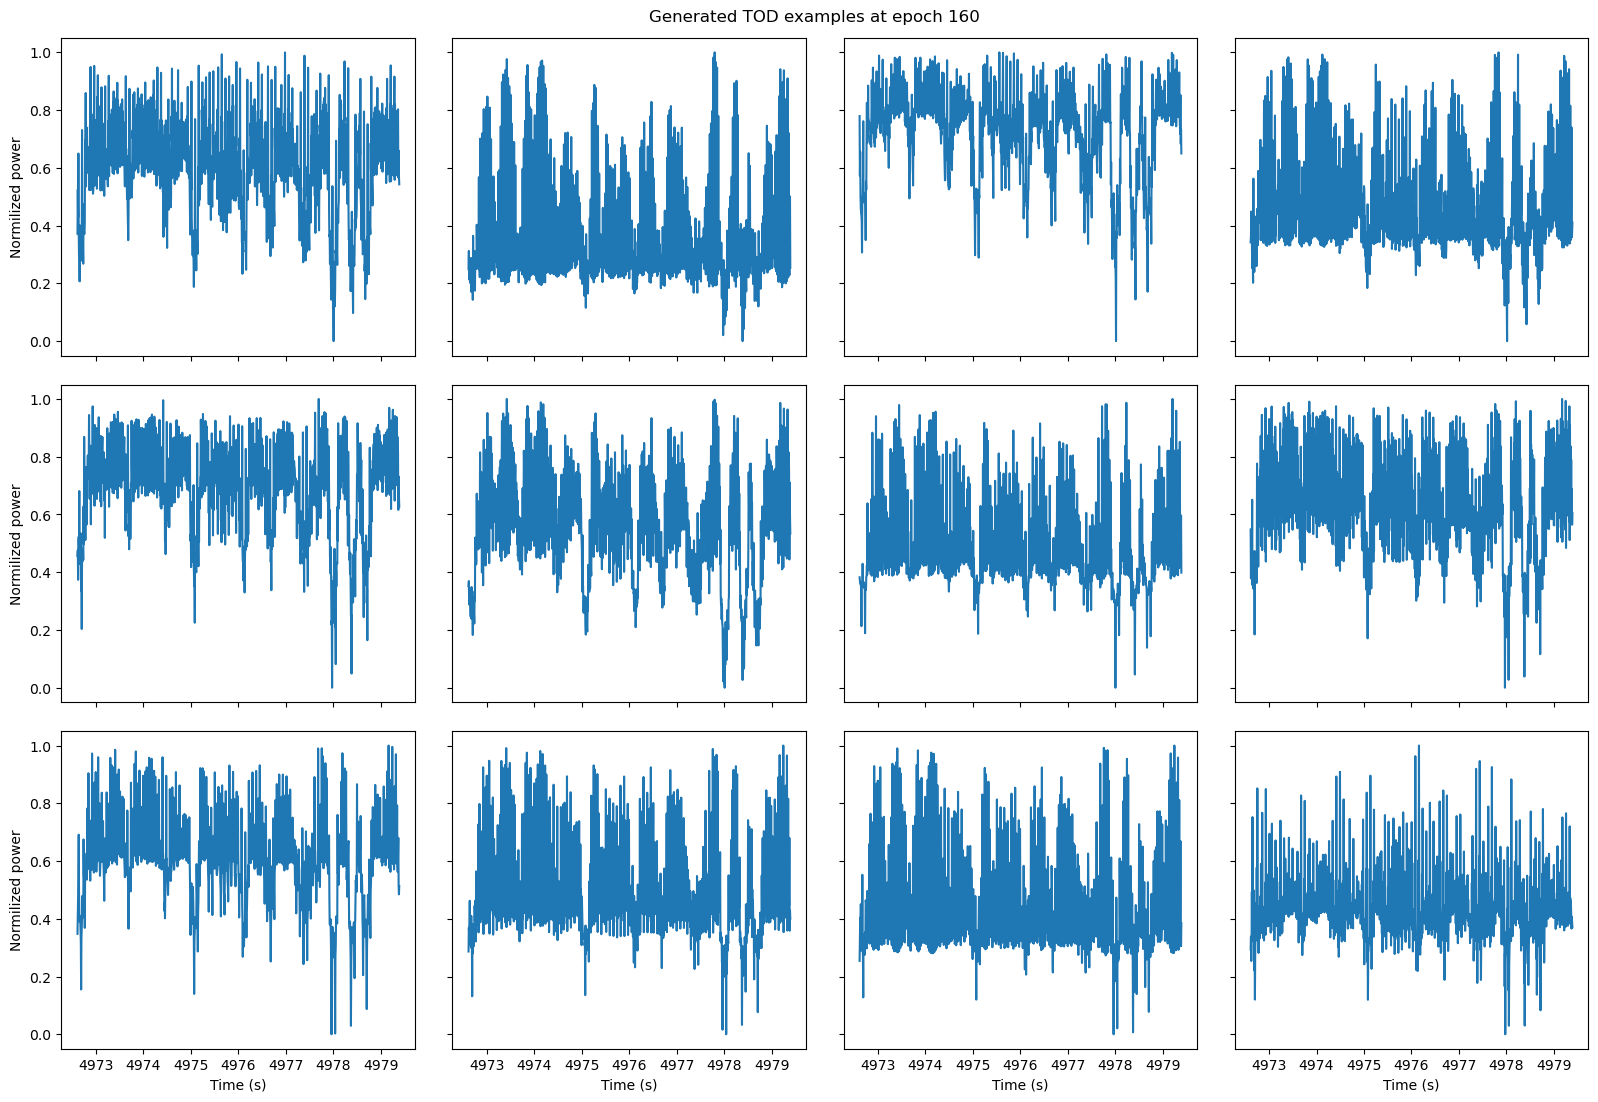

23/23 [==============================] - 0s 6ms/step


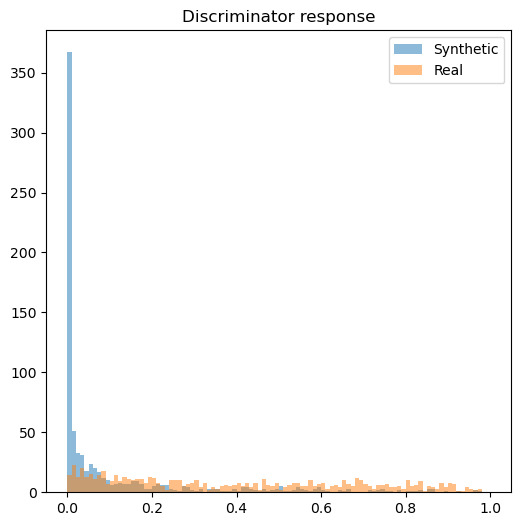

11/11 [==============================] - 8s 780ms/step - gen_loss: 4.4668 - discr_loss: 0.8343 - gen_loss_val: 11.3409 - discr_loss_val: 0.7947 - gen_acc: 0.0170 - discr_acc: 0.9028
Epoch 161/200
11/11 [==============================] - 7s 585ms/step - gen_loss: 1.0245 - discr_loss: 2.1178 - gen_loss_val: 1.2871 - discr_loss_val: 2.0046 - gen_acc: 0.1102 - discr_acc: 0.5250
Epoch 162/200
11/11 [==============================] - 6s 589ms/step - gen_loss: 2.2134 - discr_loss: 0.7078 - gen_loss_val: 2.0732 - discr_loss_val: 1.0435 - gen_acc: 0.0705 - discr_acc: 0.8494
Epoch 163/200
11/11 [==============================] - 6s 579ms/step - gen_loss: 3.5169 - discr_loss: 0.5319 - gen_loss_val: 3.0567 - discr_loss_val: 1.9094 - gen_acc: 0.1943 - discr_acc: 0.8108
Epoch 164/200
11/11 [==============================] - 7s 592ms/step - gen_loss: 2.1655 - discr_loss: 2.6034 - gen_loss_val: 2.1409 - discr_loss_val: 3.3097 - gen_acc: 0.1852 - discr_acc: 0.4756
Epoch 165/200
11/11 [=================

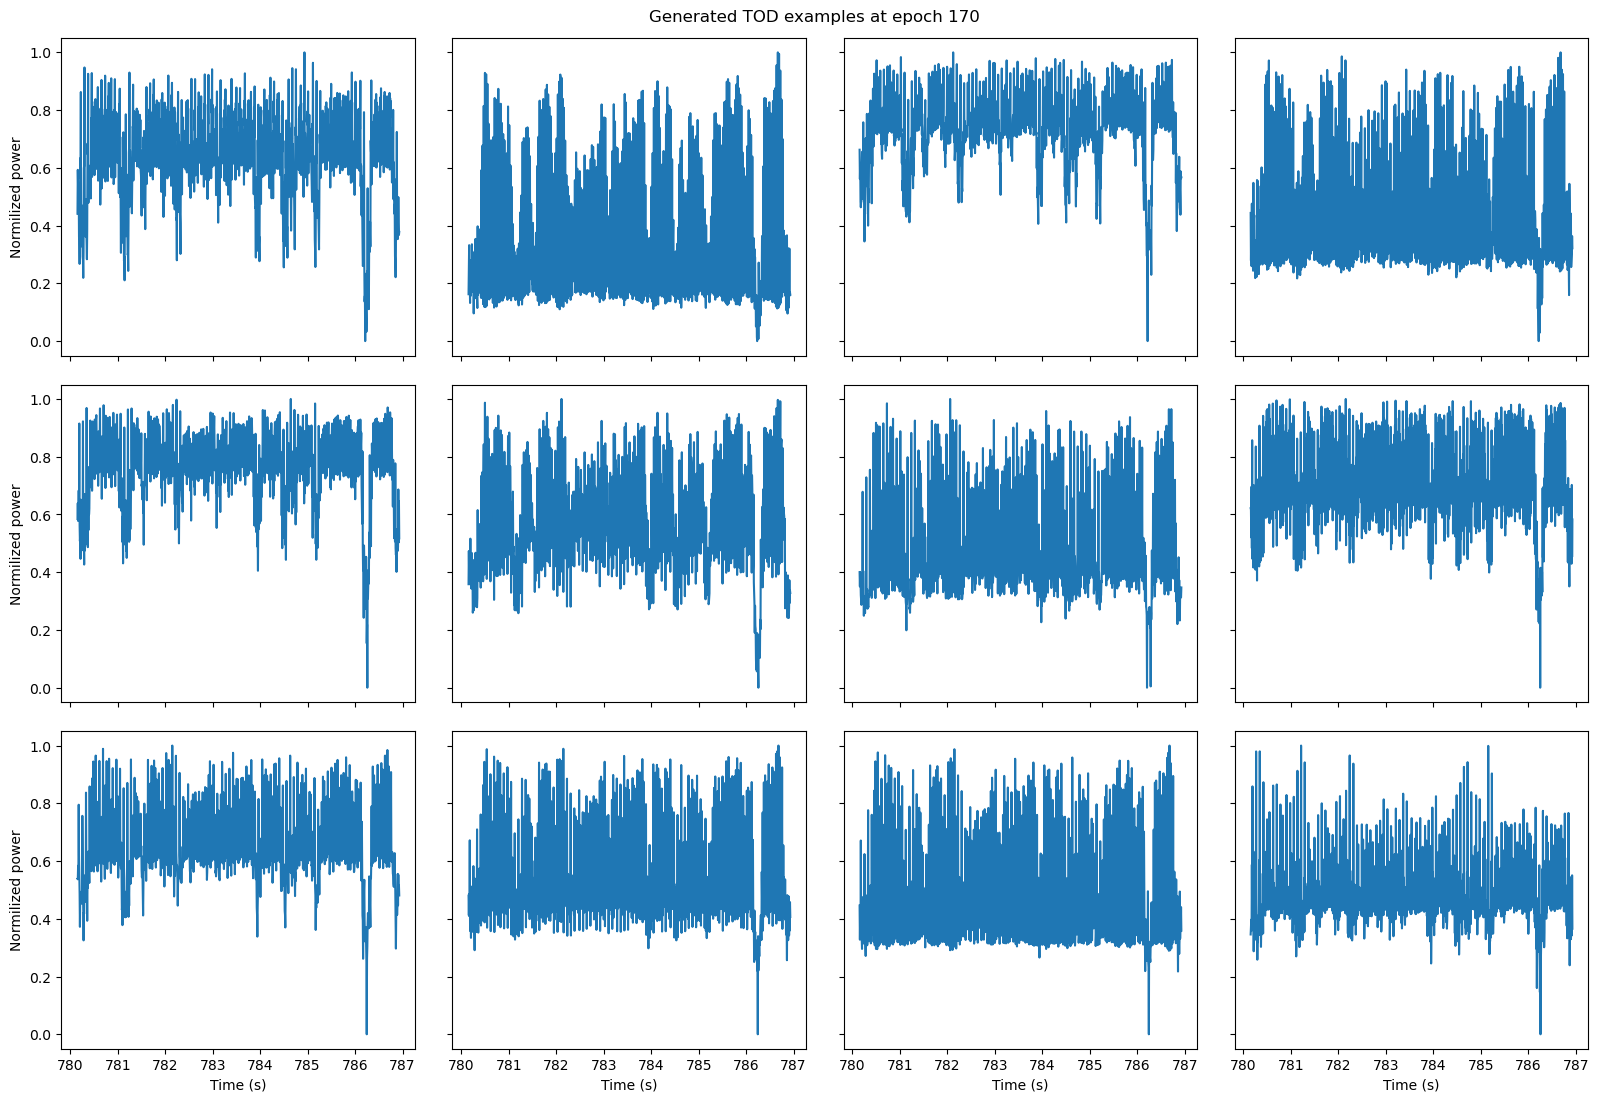

23/23 [==============================] - 0s 6ms/step


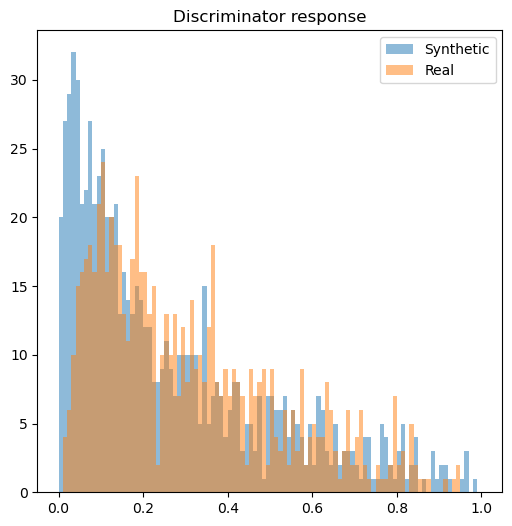

11/11 [==============================] - 9s 802ms/step - gen_loss: 2.1188 - discr_loss: 1.6664 - gen_loss_val: 2.2446 - discr_loss_val: 3.2548 - gen_acc: 0.3159 - discr_acc: 0.5295
Epoch 171/200
11/11 [==============================] - 7s 596ms/step - gen_loss: 1.0927 - discr_loss: 2.0188 - gen_loss_val: 1.2668 - discr_loss_val: 2.0604 - gen_acc: 0.0682 - discr_acc: 0.4864
Epoch 172/200
11/11 [==============================] - 7s 611ms/step - gen_loss: 1.3258 - discr_loss: 1.5054 - gen_loss_val: 1.4151 - discr_loss_val: 1.4769 - gen_acc: 0.0557 - discr_acc: 0.6648
Epoch 173/200
11/11 [==============================] - 6s 591ms/step - gen_loss: 2.2069 - discr_loss: 0.8349 - gen_loss_val: 4.8725 - discr_loss_val: 0.6987 - gen_acc: 0.0761 - discr_acc: 0.8841
Epoch 174/200
11/11 [==============================] - 7s 612ms/step - gen_loss: 1.3208 - discr_loss: 2.1224 - gen_loss_val: 3.1153 - discr_loss_val: 1.5903 - gen_acc: 0.1341 - discr_acc: 0.7028
Epoch 175/200
11/11 [==================

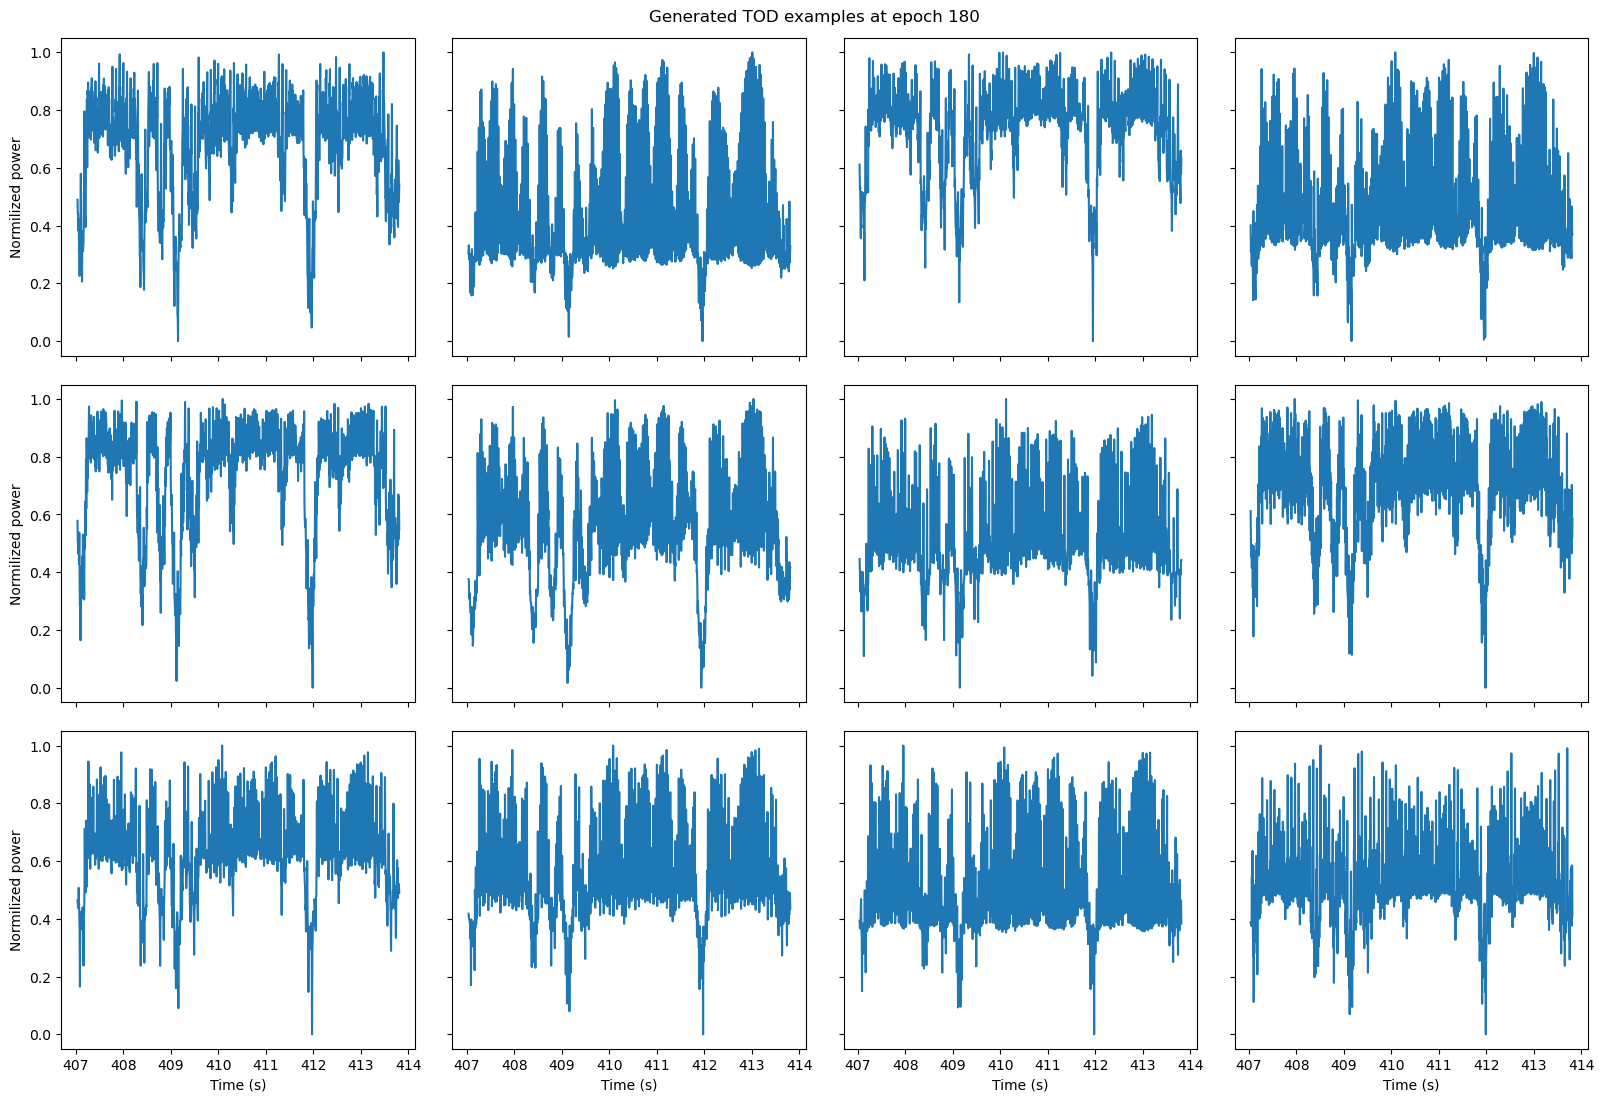

23/23 [==============================] - 0s 5ms/step


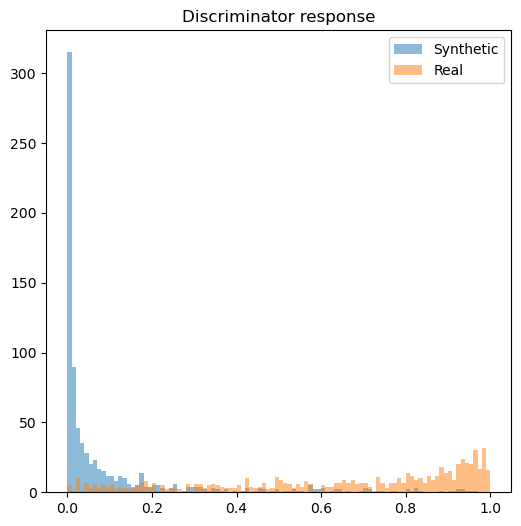

11/11 [==============================] - 8s 782ms/step - gen_loss: 1.9778 - discr_loss: 1.3347 - gen_loss_val: 4.0974 - discr_loss_val: 0.8745 - gen_acc: 0.0625 - discr_acc: 0.8386
Epoch 181/200
11/11 [==============================] - 7s 605ms/step - gen_loss: 1.4053 - discr_loss: 1.7784 - gen_loss_val: 4.2329 - discr_loss_val: 1.0953 - gen_acc: 0.0341 - discr_acc: 0.7563
Epoch 182/200
11/11 [==============================] - 6s 591ms/step - gen_loss: 1.5904 - discr_loss: 1.4907 - gen_loss_val: 1.3940 - discr_loss_val: 2.2653 - gen_acc: 0.2341 - discr_acc: 0.5000
Epoch 183/200
11/11 [==============================] - 7s 594ms/step - gen_loss: 2.0971 - discr_loss: 1.7519 - gen_loss_val: 1.8749 - discr_loss_val: 2.7357 - gen_acc: 0.2318 - discr_acc: 0.5398
Epoch 184/200
11/11 [==============================] - 7s 600ms/step - gen_loss: 1.1685 - discr_loss: 1.8868 - gen_loss_val: 1.4352 - discr_loss_val: 1.8704 - gen_acc: 0.0534 - discr_acc: 0.5063
Epoch 185/200
11/11 [==================

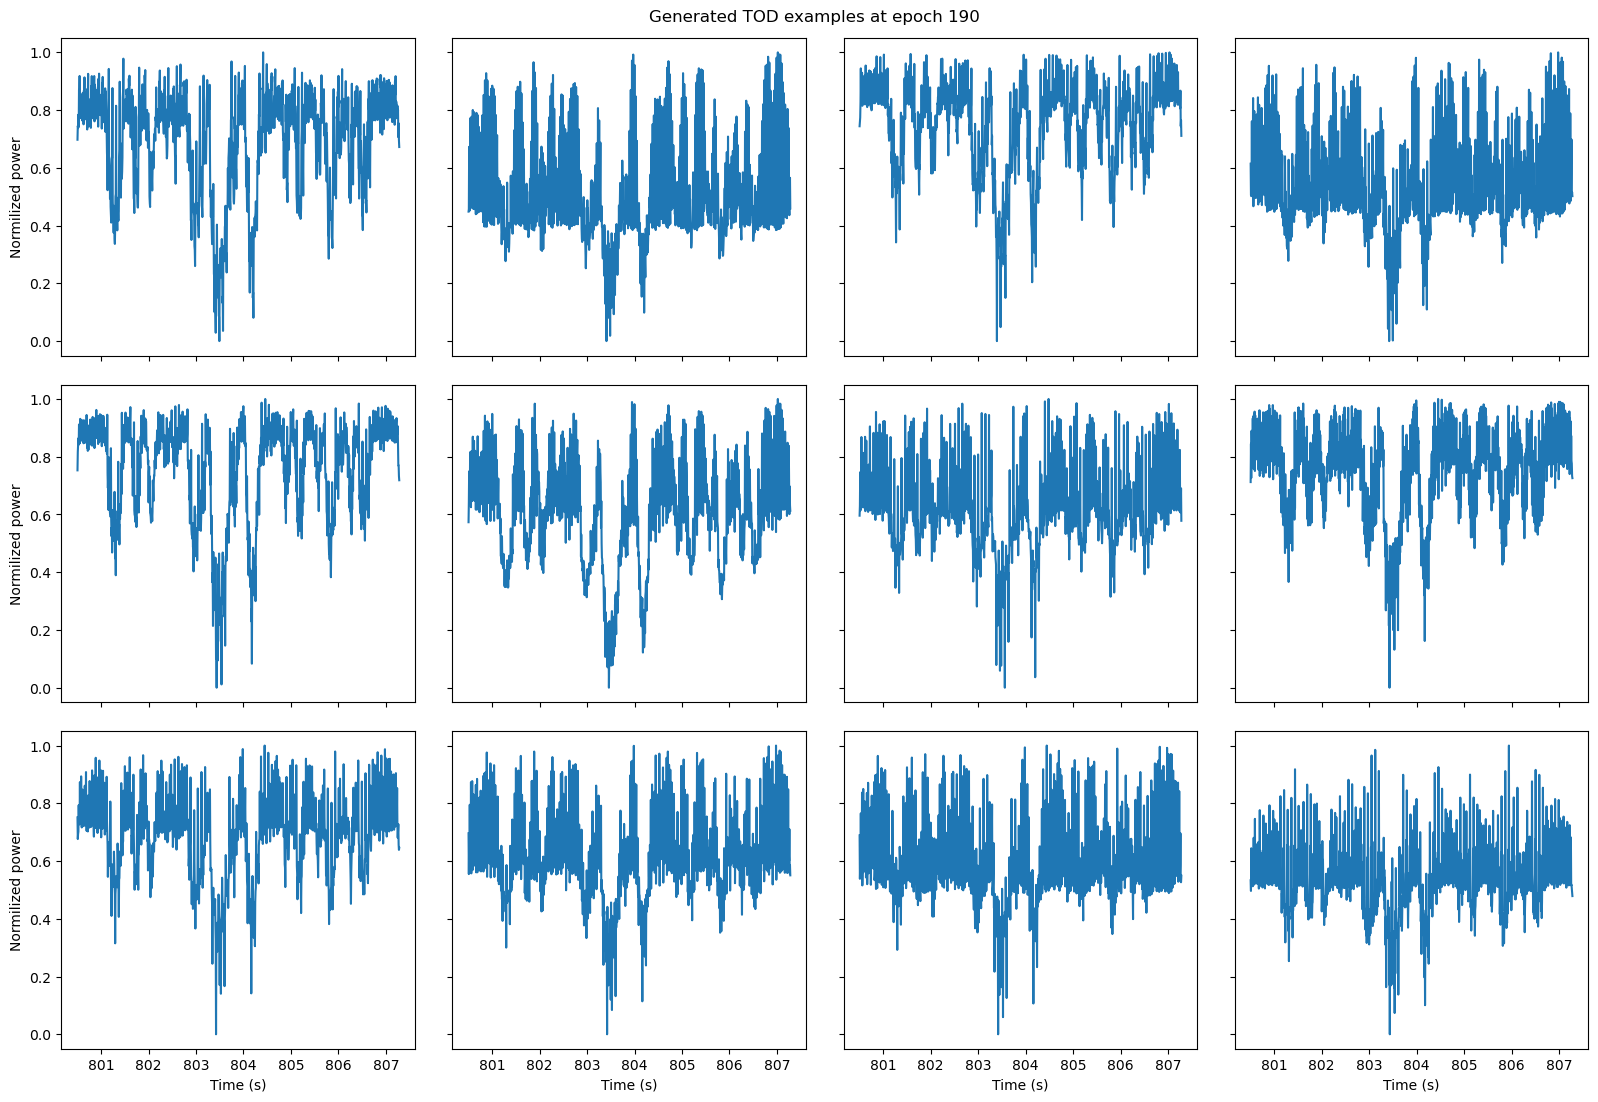

23/23 [==============================] - 0s 5ms/step


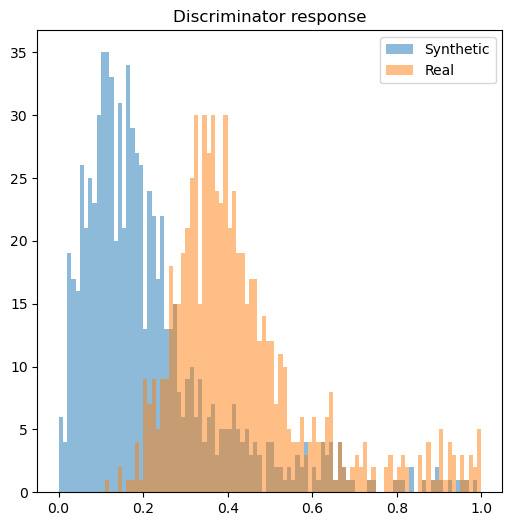

11/11 [==============================] - 9s 823ms/step - gen_loss: 1.3088 - discr_loss: 1.6395 - gen_loss_val: 2.1470 - discr_loss_val: 1.4619 - gen_acc: 0.0534 - discr_acc: 0.5619
Epoch 191/200
11/11 [==============================] - 7s 608ms/step - gen_loss: 0.9750 - discr_loss: 1.7171 - gen_loss_val: 1.5820 - discr_loss_val: 1.3839 - gen_acc: 0.1148 - discr_acc: 0.7170
Epoch 192/200
11/11 [==============================] - 6s 588ms/step - gen_loss: 1.1448 - discr_loss: 1.6992 - gen_loss_val: 2.5123 - discr_loss_val: 0.9697 - gen_acc: 0.0648 - discr_acc: 0.7955
Epoch 193/200
11/11 [==============================] - 7s 603ms/step - gen_loss: 4.0615 - discr_loss: 3.5291 - gen_loss_val: 5.7272 - discr_loss_val: 3.4879 - gen_acc: 0.1295 - discr_acc: 0.6858
Epoch 194/200
11/11 [==============================] - 7s 598ms/step - gen_loss: 1.1290 - discr_loss: 1.9070 - gen_loss_val: 1.1895 - discr_loss_val: 1.8490 - gen_acc: 0.0000e+00 - discr_acc: 0.5000
Epoch 195/200
11/11 [==============

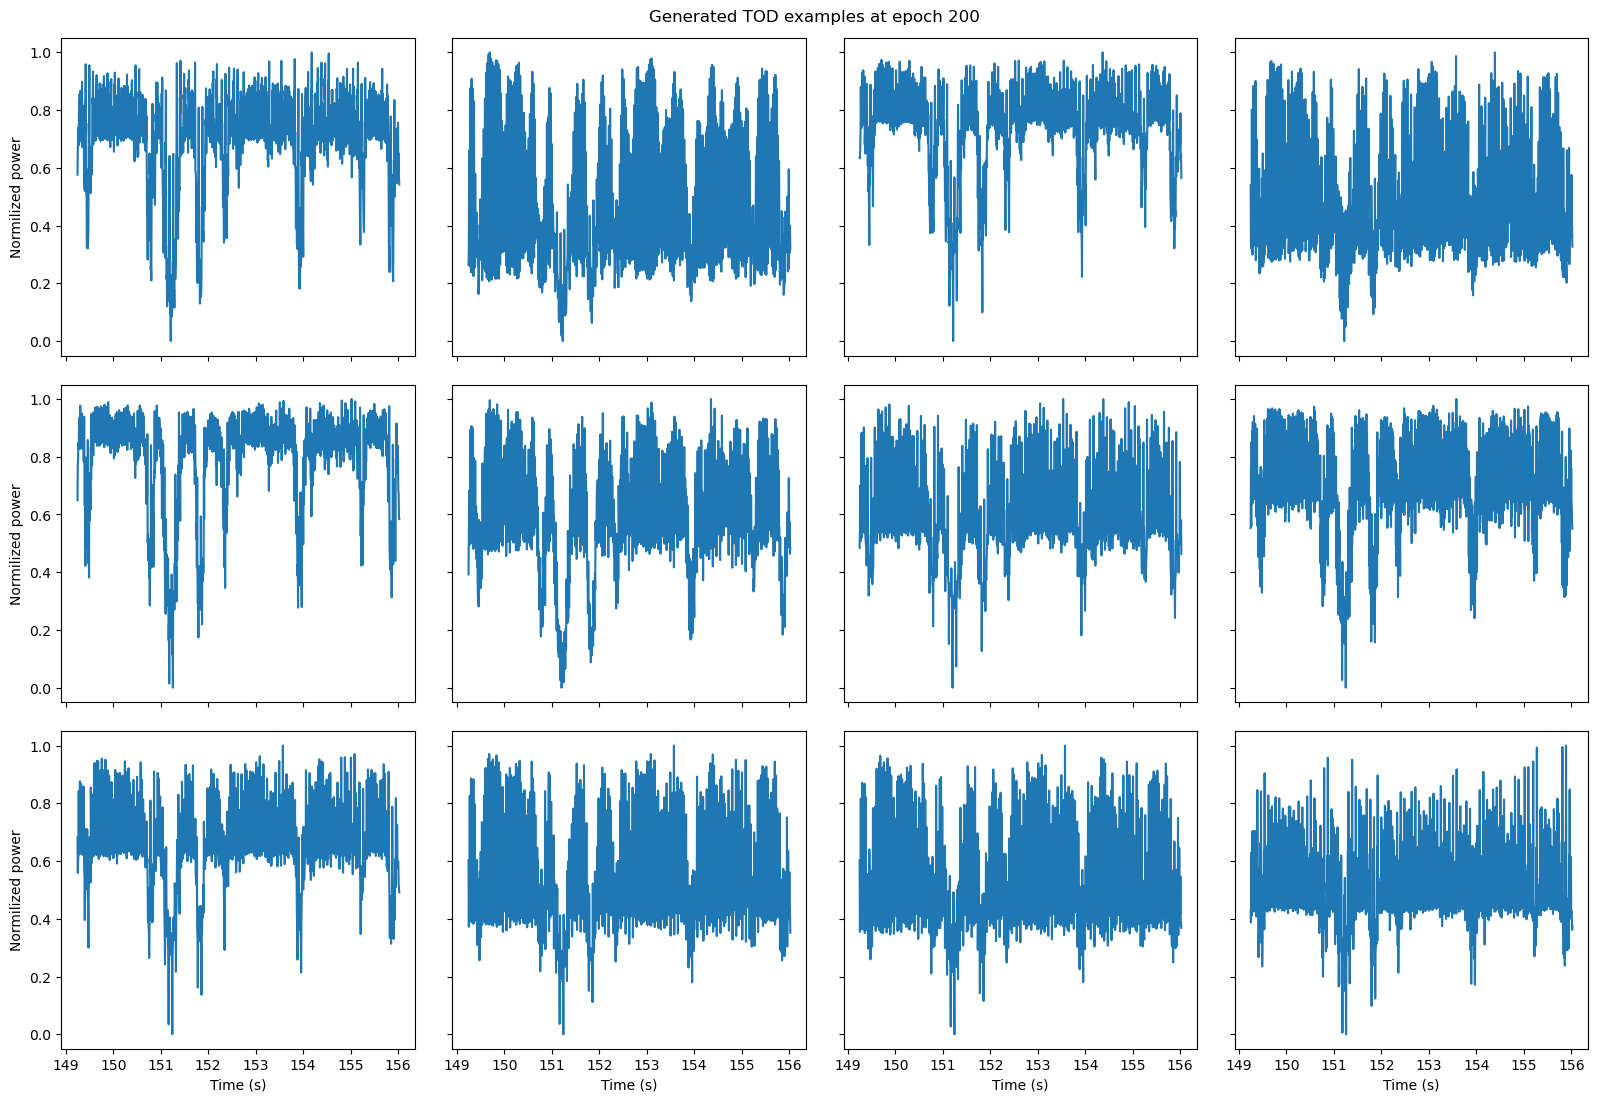

23/23 [==============================] - 0s 5ms/step


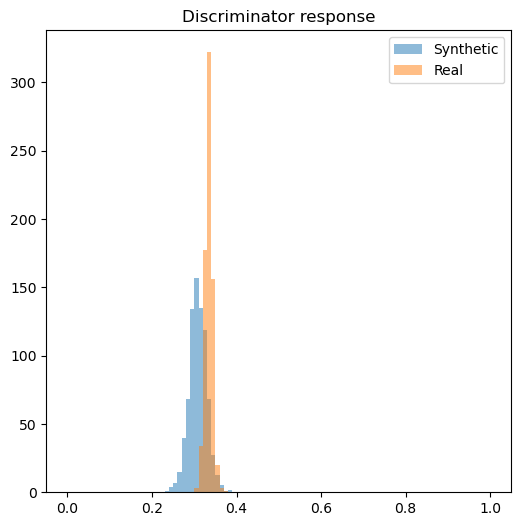

11/11 [==============================] - 8s 789ms/step - gen_loss: 1.1025 - discr_loss: 1.9005 - gen_loss_val: 1.1887 - discr_loss_val: 1.8168 - gen_acc: 0.0000e+00 - discr_acc: 0.5000


In [ ]:
# Standart compiling and training or grid search of the hyperparameterss
grid_search = False

if not grid_search:
    # Set the optimizers and train parameters
    batch_size = 64
    epochs = 200
    lr_gen = 1e-3
    lr_discr = 1e-2
    momentum = 0.1
    extra_discr = 5
    synth_weight = 2
    pretrain = False

    # Optimizer
    optim = 'Adam'

    if optim == 'SGD':
        gen_optimizer = SGD(learning_rate=lr_gen, momentum=momentum)
        discr_optimizer = SGD(learning_rate=lr_discr, momentum=momentum)
        
    if optim == 'Nadam':
        gen_optimizer = Nadam(learning_rate=lr_gen)
        discr_optimizer = Nadam(learning_rate=lr_discr)

    if optim == 'Adam':
        gen_optimizer = Adam(learning_rate=lr_gen)
        discr_optimizer = Adam(learning_rate=lr_discr)
        
    if optim == 'Adam_SGD':
        gen_optimizer = Adam(learning_rate=lr_gen)
        discr_optimizer = SGD(learning_rate=lr_discr, momentum=momentum)

    if optim == 'SGD_Namam':
        gen_optimizer = SGD(learning_rate=lr_gen, momentum=momentum)
        discr_optimizer = Nadam(learning_rate=lr_discr)

    if optim == 'Namam_SGD':
        gen_optimizer = Nadam(learning_rate=lr_gen)
        discr_optimizer = SGD(learning_rate=lr_discr, momentum=momentum)

    # Build the GAN
    gen = real_generator_model(time_bins, inputnoise_bins, hit_len)
    discr = real_discriminator_model(time_bins, hit_len)
    if pretrain:
        discr.load_weights(model_dir + '/pretrained_discr.h5')
    #mini_gan = mini_gan_model(gen, discr)
    gen.summary()
    discr.summary()

    with open(model_dir + '/model_summary.txt', 'a') as f:
        gen.summary(print_fn=lambda x: f.write(x + '\n'))
        discr.summary(print_fn=lambda x: f.write(x + '\n'))

    if model_struct == 'GAN_1':
        gan_toy = GAN_1(gen, discr, time_bins, inputnoise_bins)

    if model_struct == 'WGAN':
        gan_toy = WGAN(gen, discr, time_bins, inputnoise_bins)

    gan_toy.compile(gen_optimizer, discr_optimizer, gen_loss, discr_loss, synth_weight, extra_discr=extra_discr, val_data=TODs_val)

    # Check of correct weights load
    if pretrain:
        gan_toy_weights = gan_toy.discriminator.weights
        are_weights_equal = all([tf.reduce_all(w1 == w2) for w1, w2 in zip(gan_pretrain_weights, gan_toy_weights)])
        print('\nPre-trained discriminator weights loaded correctly:\t', are_weights_equal)

    # Adjust the dataset sample to be a multiple of the batch size (instead there is a training crash!)
    last_data = (TODs_train.shape[0]//batch_size)*batch_size
    TODs_train_cut = TODs_train[:last_data]
    print('Train dataset has the shape: ', TODs_train_cut.shape, '\n')
    
    # Train and validate the GAN
    epoch_snapshow2 = 10
    custom_callback2 = ShowTODCallback(gan_toy, time_steps, inputnoise_bins, TODs_train, epoch_snapshow=epoch_snapshow2)
    epoch_callback = EpochCounter(gan_toy.epoch_counter)

    history2 = gan_toy.fit(TODs_train_cut, batch_size=batch_size, epochs=epochs, callbacks=[custom_callback2, epoch_callback])

## Grid search of the hyperparameters with Tensor Board tool

In [ ]:
# Grid search and TensorBoard
if grid_search:
    # Build the GAN
    pretrain = True

    gen = real_generator_model(time_bins, inputnoise_bins, hit_len)
    discr = real_discriminator_model(time_bins, hit_len)
    if pretrain:
        discr.load_weights(model_dir + '/pretrained_discr.h5')
    #mini_gan = mini_gan_model(gen, discr)
    gen.summary()
    discr.summary()

    with open(model_dir + '/model_summary.txt', 'a') as f:
        gen.summary(print_fn=lambda x: f.write(x + '\n'))
        discr.summary(print_fn=lambda x: f.write(x + '\n'))

    if model_struct == 'GAN_1':
        gan_toy = GAN_1(gen, discr, time_bins, inputnoise_bins)

    if model_struct == 'WGAN':
        gan_toy = WGAN(gen, discr, time_bins, inputnoise_bins)

    # Check of correct weights load
    if pretrain:
        gan_toy_weights = gan_toy.discriminator.weights
        are_weights_equal = all([tf.reduce_all(w1 == w2) for w1, w2 in zip(gan_pretrain_weights, gan_toy_weights)])
        print('\nPre-trained discriminator weights loaded correctly:\t', are_weights_equal)

    # Set the optimizers and train parameters
    epochs = 200
    
    # Hyperparametrs grid of value to explore (hparams initialization)
    session_num = 0
    LR_GEN =       hp.HParam('lr_gen', hp.Discrete([1e-2, 1e-3, 1e-4]))
    LR_DISCR =     hp.HParam('lr_discr', hp.Discrete([1e-2, 1e-3, 1e-4]))
    BATCH_SIZE =   hp.HParam('batch_size', hp.Discrete([10, 20, 32, 64]))
    SYNTH_WEIGHT = hp.HParam('synth_weight', hp.Discrete([0.5, 0.8, 1.]))
    OPTIM =        hp.HParam('optim', hp.Discrete(['SGD', 'Nadam', 'Adam', 'Adam_SGD', 'SGD_Adam', 'SGD_Namam', 'Namam_SGD']))

    for lr_gen in LR_GEN.domain.values:
        for lr_discr in LR_DISCR.domain.values:
            for batch_size in BATCH_SIZE.domain.values:
                for synth_weight in SYNTH_WEIGHT.domain.values:
                    for optim in OPTIM.domain.values:
                        momentum = 0.1
                        extra_discr = 1

                        hparams = {
                            LR_GEN: lr_gen,
                            LR_DISCR: lr_discr,
                            BATCH_SIZE: batch_size,
                            SYNTH_WEIGHT: synth_weight,
                            OPTIM: optim
                        }

                        run_name = "run-%d" % session_num
                        print('--- Starting trial: %s' % run_name)
                        print({h.name: hparams[h] for h in hparams})
                        session_num += 1

                        lr_gen       = hparams[LR_GEN]
                        lr_discr     = hparams[LR_DISCR]
                        batch_size   = hparams[BATCH_SIZE]
                        synth_weight = hparams[SYNTH_WEIGHT]
                        optim        = hparams[OPTIM]

                        # Optimizer
                        if optim == 'SGD':
                            gen_optimizer = SGD(learning_rate=lr_gen, momentum=momentum)
                            discr_optimizer = SGD(learning_rate=lr_discr, momentum=momentum)
                            
                        elif optim == 'Nadam':
                            gen_optimizer = Nadam(learning_rate=lr_gen)
                            discr_optimizer = Nadam(learning_rate=lr_discr)

                        elif optim == 'Adam':
                            gen_optimizer = Adam(learning_rate=lr_gen)
                            discr_optimizer = Adam(learning_rate=lr_discr)
                            
                        elif optim == 'Adam_SGD':
                            gen_optimizer = Adam(learning_rate=lr_gen)
                            discr_optimizer = SGD(learning_rate=lr_discr, momentum=momentum)
                        
                        elif optim == 'SGD_Adam':
                            gen_optimizer = SGD(learning_rate=lr_discr, momentum=momentum)
                            discr_optimizer = Adam(learning_rate=lr_gen)

                        elif optim == 'SGD_Namam':
                            gen_optimizer = SGD(learning_rate=lr_gen, momentum=momentum)
                            discr_optimizer = Nadam(learning_rate=lr_discr)

                        elif optim == 'Namam_SGD':
                            gen_optimizer = Nadam(learning_rate=lr_gen)
                            discr_optimizer = SGD(learning_rate=lr_discr, momentum=momentum)

                        else:
                            print('ERROR: unknown optimizer configured\n')

                        # Save the TensorBoard logs in a file for each hyperparameters tested and define the callback
                        log_dir = f"{model_dir}/logs/{optim}_{lr_gen}_{lr_discr}_{batch_size}_{synth_weight}"
                        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

                        # Compile with the selected hyperparameters
                        gan_toy.compile(gen_optimizer, discr_optimizer, gen_loss, discr_loss, synth_weight, extra_discr=extra_discr, val_data=TODs_val, logdir=log_dir)

                        # Turn interactive plotting off
                        # plt.ioff()

                        # Adjust the dataset sample to be a multiple of the batch size (instead there is a training crash!)
                        last_data = (TODs_train.shape[0]//batch_size)*batch_size
                        TODs_train_cut = TODs_train[:last_data]
                        print('Train dataset has the shape: ', TODs_train_cut.shape, '\n')

                        # Train and validate the GAN
                        # epoch_snapshow2 = 10
                        # custom_callback2 = ShowTODCallback(gan_toy, time_steps, inputnoise_bins, TODs_train, epoch_snapshow=epoch_snapshow2)
                        epoch_callback = EpochCounter(gan_toy.epoch_counter)
                        
                        history2 = gan_toy.fit(TODs_train_cut, batch_size=batch_size, epochs=epochs, callbacks=[tensorboard_callback, epoch_callback])

## TOD nomalization test
Testing both the real training TODs normalization and the generator ones

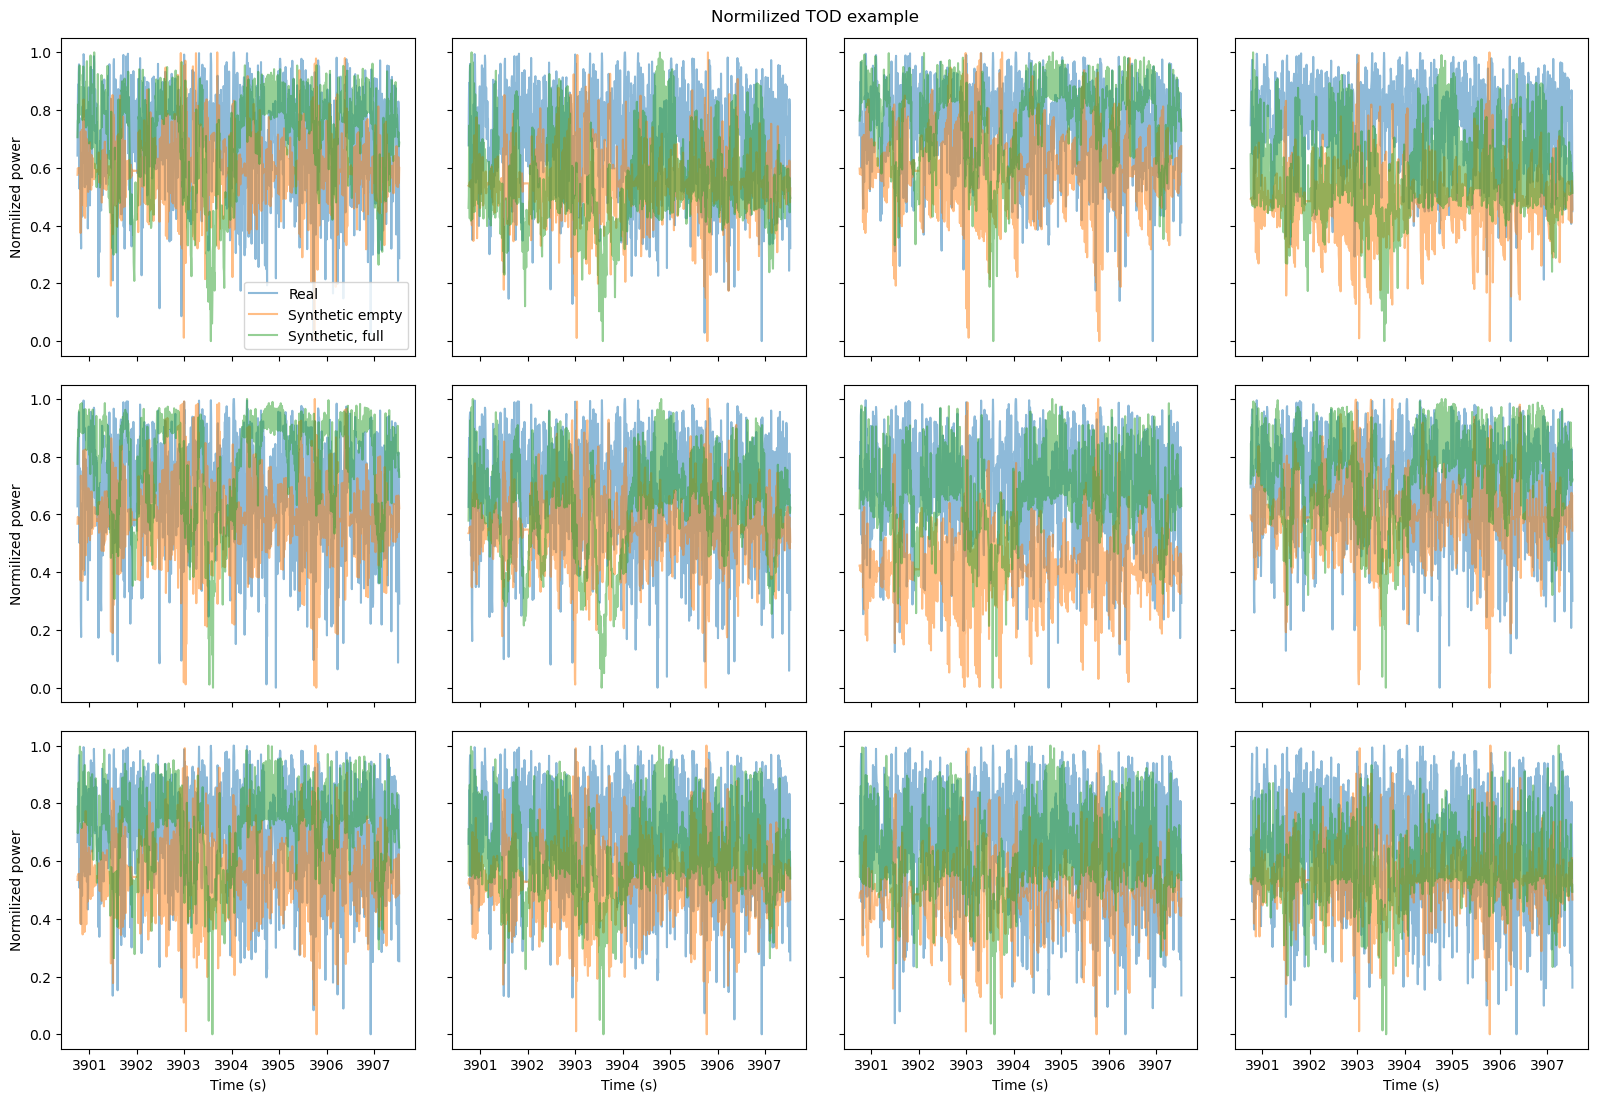

In [ ]:
# Test the normilization of the data
rows = int(np.sqrt(TODs_train.shape[2]))
cols = TODs_train.shape[2]//rows

prediction_inputnoise = np.random.normal(size=(1, inputnoise_bins))
empty_prediction_TODs = gan_pretrain.generator(prediction_inputnoise)
prediction_TODs = gan_toy.generator(prediction_inputnoise)
    
if rows == 1:
    fig, ax = plt.subplots(figsize = (5,5))
    fig.suptitle(f'Normilized TOD example')
    plt.tight_layout()

    TOD_id = int(np.random.rand()*time_steps.shape[0])
    
    ax.set_ylabel('Normilized power', loc='center')
    ax.set_xlabel('Time (s)', loc='center')
    ax.plot(time_steps[TOD_id,:,0], TODs_train[TOD_id,:,0], label='Real', alpha=0.5)
    ax.plot(time_steps[TOD_id,:,0], empty_prediction_TODs[0,:,0], label='Synthetic empty', alpha=0.5)
    ax.plot(time_steps[TOD_id,:,0], prediction_TODs[0,:,0], label='Synthetic full', alpha=0.5)
    ax.legend()

else:
    fig, ax = plt.subplots(rows, cols, figsize = (16,11), sharex=True, sharey=True)
    fig.suptitle(f'Normilized TOD example')
    plt.tight_layout()

    TOD_id = int(np.random.rand()*time_steps.shape[0])

    for i in range (rows):
        ax[i, 0].set_ylabel('Normilized power', loc='center')
        for k in range(cols):
            ax[rows-1, k].set_xlabel('Time (s)', loc='center')
            ax[i,k].plot(time_steps[TOD_id,:,k+i*cols], TODs_train[0,:,k+i*cols], label='Real', alpha=0.5)
            ax[i,k].plot(time_steps[TOD_id,:,k+i*cols], empty_prediction_TODs[0,:,k+i*cols], label='Synthetic empty', alpha=0.5)
            ax[i,k].plot(time_steps[TOD_id,:,k+i*cols], prediction_TODs[0,:,k+i*cols], label='Synthetic, full', alpha=0.5)
    
    ax[0,0].legend()
    
plt.show()
plt.close()

In [ ]:
intermediete_plot = False
if intermediete_plot:
    # Turn interactive plotting off
    plt.ioff()

    # GIF of the intermediate training stages of generated TODs
    TOD_im_array2 = custom_callback2.TOD_im_array
    print('Number of intemediete snapshots taken = ', np.shape(TOD_im_array2)[0])

    for i in range(np.shape(TOD_im_array2)[0]):
        fig_gif, ax_gif = plt.subplots()
        ax_gif.set_title(f'Generated TOD examples at epoch {(i+1)*epoch_snapshow2}')
        ax_gif.imshow(TOD_im_array2[i])

    resp_im_array2 = custom_callback2.resp_im_array

    for i in range(np.shape(resp_im_array2)[0]):
        fig_gif, ax_gif = plt.subplots()
        ax_gif.set_title(f'Discriminator response examples at epoch {(i+1)*epoch_snapshow2}')
        ax_gif.imshow(resp_im_array2[i])

    '''def update_im(i):
        ax_gif.imshow(im_array1[i])
        ax_gif.set_title(f'Generated TOD examples at epoch {i*epoch_snapshow2}')
        return ax_gif
    '''
    # Create the animation object
    # animation_fig1 = FuncAnimation(fig_gif, update_im, frames=np.shape(im_array1)[0], interval=200, repeat_delay=10)

    # Show and save the animation
    plt.show()
    #animation_fig.save(f"{model_dir}/pretrain_intermediate_TOD.gif")

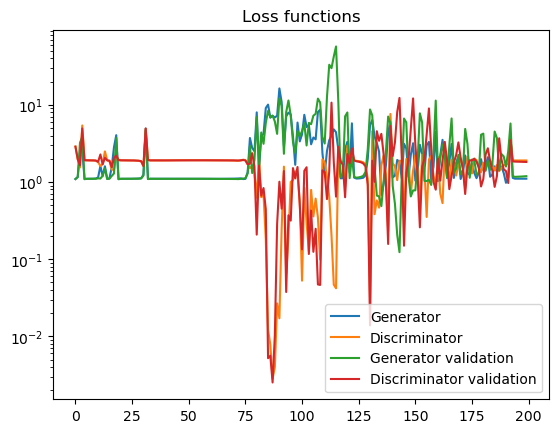

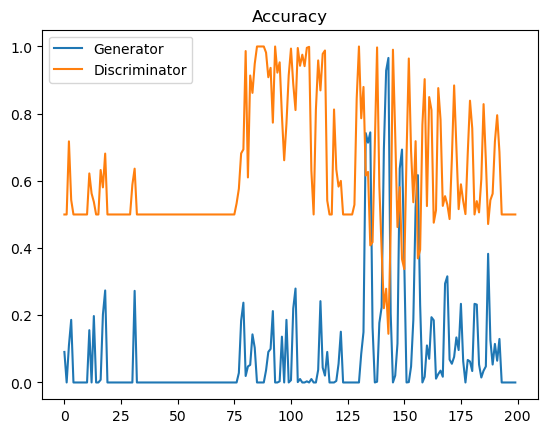

In [ ]:
# Save the final model
gan_toy.generator.save(model_dir + '/final_generator.keras')
gan_toy.discriminator.save(model_dir + '/final_discriminator.keras')

# Plot the training losses along the epochs
if model_struct == 'GAN_1':

    plt.plot(history2.history["gen_loss"], label="Generator")
    plt.plot(history2.history["discr_loss"], label="Discriminator")
    plt.plot(history2.history["gen_loss_val"], label="Generator validation")
    plt.plot(history2.history["discr_loss_val"], label="Discriminator validation")
    plt.yscale("log")
    plt.title("Loss functions")
    plt.legend()
    plt.savefig(model_dir + '/loss_final.pdf')
    plt.show()

    # Plot the accuracy along the epochs
    plt.plot(history2.history["gen_acc"], label="Generator")
    plt.plot(history2.history["discr_acc"], label="Discriminator")
    plt.title("Accuracy")
    plt.legend()
    plt.savefig(model_dir + '/acc_final.pdf')
    plt.show()

if model_struct == 'WGAN':

    plt.plot(history2.history["gen_loss"], label="Generator")
    plt.plot(history2.history["discr_loss"], label="Discriminator")
    plt.plot(history2.history["gen_loss_val"], label="Generator validation")
    plt.plot(history2.history["discr_loss_val"], label="Discriminator validation")
    # plt.yscale("log")
    plt.title("Loss functions")
    plt.legend()
    plt.savefig(model_dir + '/loss_final.pdf')
    plt.show()

    # Plot the accuracy along the epochs
    plt.plot(history2.history["gen_response"], label="Generator")
    plt.plot(history2.history["discr_real_response"], label="Discriminator on real")
    plt.plot(history2.history["discr_synth_response"], label="Discriminator on synthetic")
    plt.title("Responses")
    plt.legend()
    plt.savefig(model_dir + '/resp_final.pdf')
    plt.show()

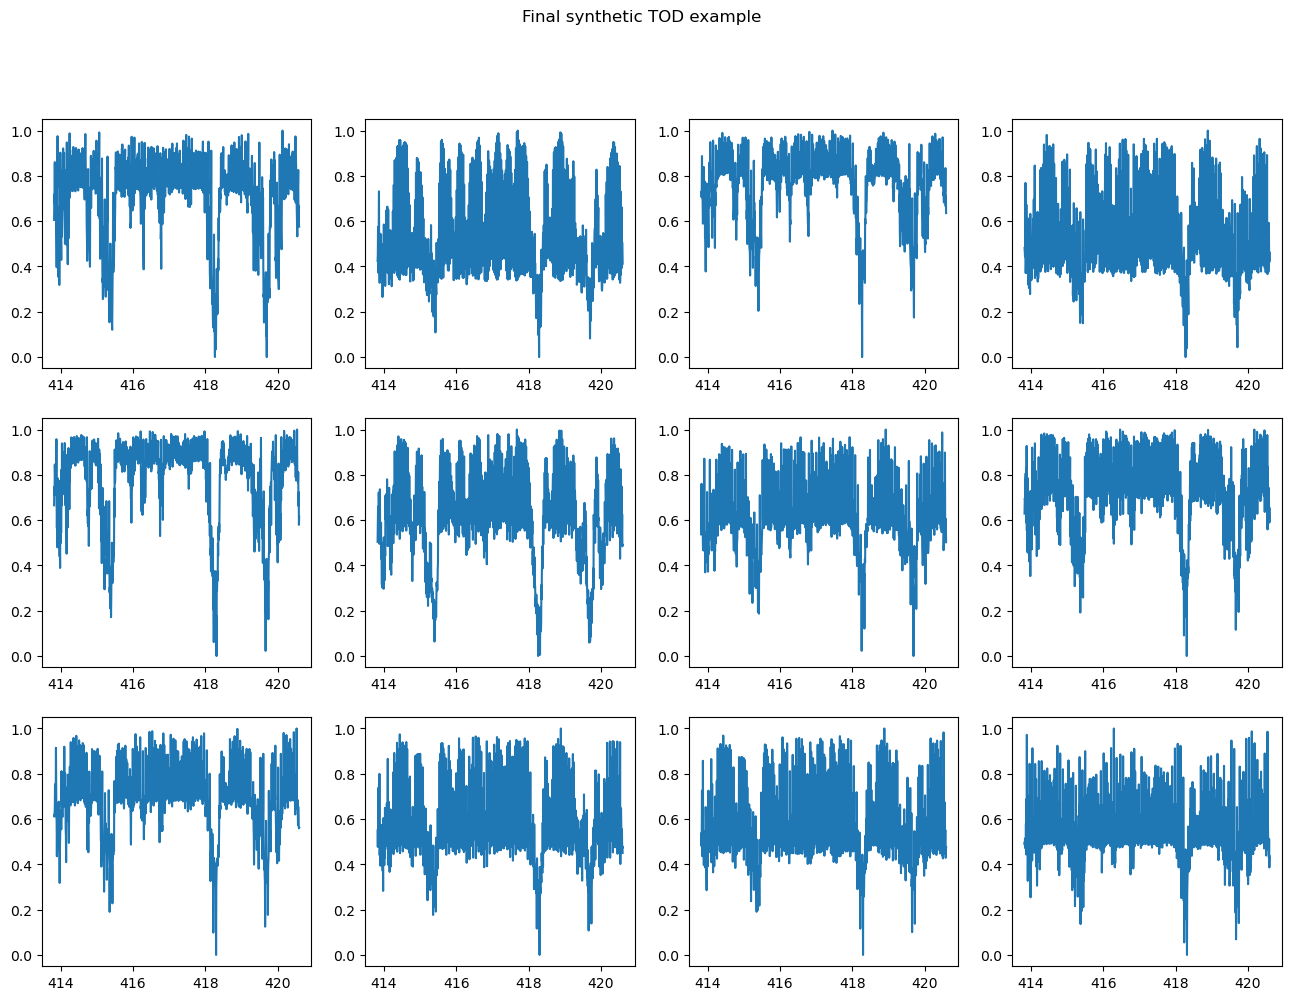

3/3 [==============================] - 0s 5ms/step


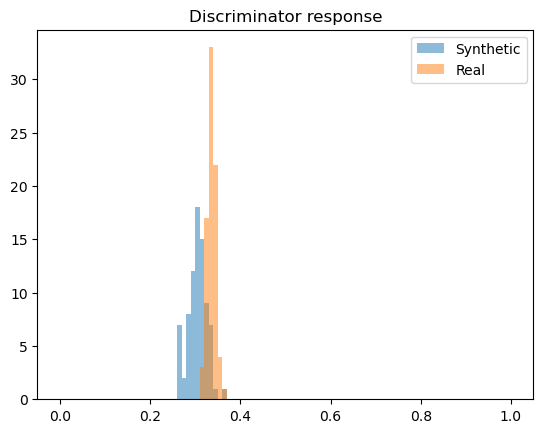

In [ ]:
# Plot some synthetic TOD after the training
test_inputnoise = np.random.normal(size=(TODs_val.shape[0], inputnoise_bins))
test_synth_TODs = gan_toy.generator(test_inputnoise)

rows = int(np.sqrt(test_synth_TODs.shape[2]))
cols = test_synth_TODs.shape[2]//rows

j = int(np.random.rand()*TODs_val.shape[0])
fig, ax = plt.subplots(rows, cols, figsize = (16,11))
fig.suptitle('Final synthetic TOD example')

for i in range (rows):
    for k in range(cols):
        ax[i,k].plot(time_steps[j,:,k+i*cols], test_synth_TODs[j,:,k+i*cols])

plt.savefig(model_dir + '/synth_TOD_exemple.pdf')
plt.show()

# TEst the Discriminator response for synthetic TOD
#test_response_synth = gan_toy.discriminator(test_synth_TODs)
#test_response_real = gan_toy.discriminator(TODs_val)
test_response_synth = gan_toy.discriminator.predict(test_synth_TODs)
test_response_real = gan_toy.discriminator.predict(TODs_val)
plt.hist(test_response_synth, label="Synthetic", range=(0,1), bins=100, alpha=0.5)
plt.hist(test_response_real, label="Real", range=(0,1), bins=100, alpha=0.5)
#plt.plot(test_response_synth - test_response_real, label="Difference")
plt.title("Discriminator response")
plt.legend()

plt.savefig(model_dir + '/response_test.pdf')
plt.show()

#print(reduce_mean(test_response_real))
#print(reduce_mean(test_response_synth))
#print(reduce_mean(test_response_synth) - reduce_mean(test_response_real))

In [ ]:
'''# Clean previous models
clear_session()

# Save figure for poster
model_dir = '../models/simple_gan_12'
inputnoise_bins_poster = 100
gen_poster = load_model(model_dir + '/final_generator.keras', safe_mode=False)
poster_inputnoise = np.random.normal(size=(1, inputnoise_bins_poster))
poster_synth_TOD = gen_poster.predict(poster_inputnoise)
#poster_synth_TOD = denormalize(poster_synth_TOD, mins, maxs)
print(poster_inputnoise.shape)
print(poster_synth_TOD.shape)

plt.plot(time_steps[0,:,0], poster_synth_TOD[0,:,0])
plt.title('Synthetic TOD signal output')
plt.xticks(np.arange(0, 1561, step=156), labels=[str(i) for i in range(11)])
plt.xlabel('Time (s)')
plt.ylabel('Normalized power')
plt.savefig(model_dir + '/synth_TOD_poster.jpg')
plt.show()'''

"# Clean previous models\nclear_session()\n\n# Save figure for poster\nmodel_dir = '../models/simple_gan_12'\ninputnoise_bins_poster = 100\ngen_poster = load_model(model_dir + '/final_generator.keras', safe_mode=False)\nposter_inputnoise = np.random.normal(size=(1, inputnoise_bins_poster))\nposter_synth_TOD = gen_poster.predict(poster_inputnoise)\n#poster_synth_TOD = denormalize(poster_synth_TOD, mins, maxs)\nprint(poster_inputnoise.shape)\nprint(poster_synth_TOD.shape)\n\nplt.plot(time_steps[0,:,0], poster_synth_TOD[0,:,0])\nplt.title('Synthetic TOD signal output')\nplt.xticks(np.arange(0, 1561, step=156), labels=[str(i) for i in range(11)])\nplt.xlabel('Time (s)')\nplt.ylabel('Normalized power')\nplt.savefig(model_dir + '/synth_TOD_poster.jpg')\nplt.show()"

## Tensor Board visualizer tool
[TensorBoard](https://www.tensorflow.org/tensorboard/get_started) is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.

In [ ]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

# Clear any logs from previous runs
%rm -rf ./logs/

# Launch TensorBoard
%tensorboard --logdir ../models/sam_complete_gan_31/logs

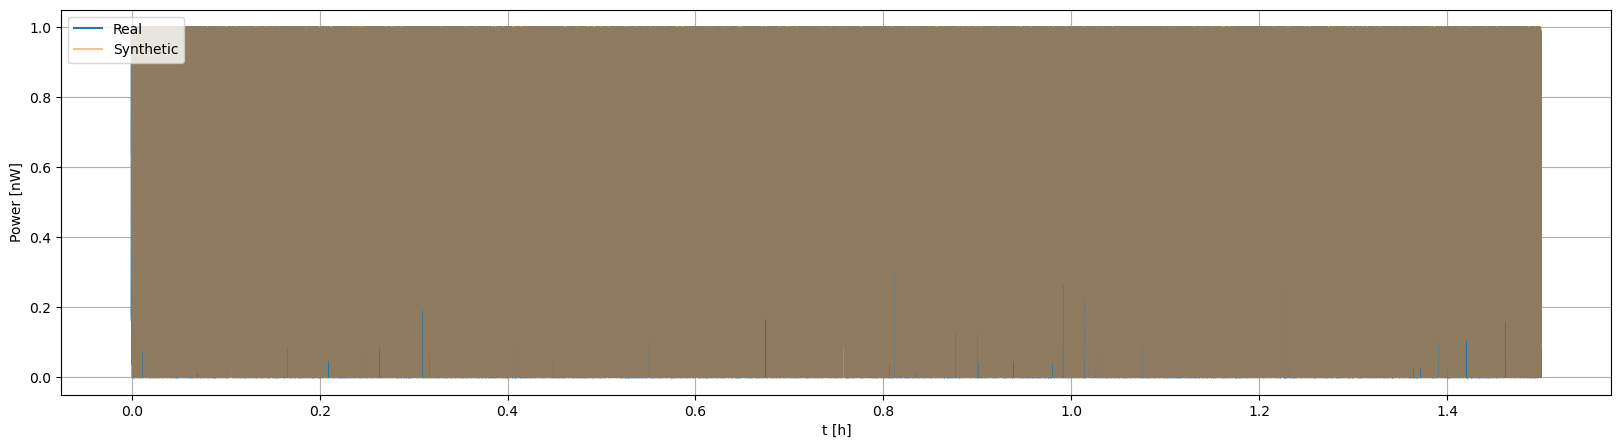

In [ ]:
# Synthetic TOD sample production (THE BEST PRACTICE IS TO USE A SEPARETED TEST SAMPLE)
sample_dim = TODs_train.shape[0]+TODs_val.shape[0]
final_inputnoise = np.random.normal(size=(sample_dim, inputnoise_bins))
final_synth_TODs = gan_toy.generator(final_inputnoise)
final_real_TODs_train = TODs_train
final_real_TODs_val = TODs_val
sample_synth_TODs = final_synth_TODs[0]
sample_real_TODs = final_real_TODs_train[0]
sample_time_steps = time_steps[0]

for i in range(sample_dim-1):
    sample_synth_TODs = np.append(sample_synth_TODs, final_synth_TODs[i+1])

for i in range(TODs_train.shape[0]-1):
    sample_real_TODs = np.append(sample_real_TODs, final_real_TODs_train[i+1])
for i in range(TODs_val.shape[0]):
    sample_real_TODs = np.append(sample_real_TODs, final_real_TODs_val[i])

for i in range(sample_dim-1):
    sample_time_steps = np.append(sample_time_steps, time_steps[i+1])

# Comparison between generated and original TODs in amplitude and spectrogram
plt.figure(figsize=(20,5))
plt.plot(sample_time_steps/3600, sample_real_TODs, label='Real')
plt.plot(sample_time_steps/3600, sample_synth_TODs, alpha=0.5, label='Synthetic')
plt.xlabel("t [h]")
plt.ylabel("Power [nW]")
plt.grid()
plt.legend(loc='upper left')
plt.show()